<a href="https://colab.research.google.com/github/vsairam-uc/GenAI-and-LLM/blob/main/energy_based_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np

import tensorflow as tf
from tensorflow.keras import (
    datasets,
    layers,
    models,
    optimizers,
    activations,
    metrics,
    callbacks,
)
import random

In [ ]:
import matplotlib.pyplot as plt


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

## Parameters

In [ ]:
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 40
NOISE = 0.005
ALPHA = 0.1
GRADIENT_CLIP = 0.03
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 0.0001
EPOCHS = 120
LOAD_MODEL = False

In [ ]:
# Load the data
(x_train, _), (x_test, _) = datasets.mnist.load_data()

In [ ]:
# Preprocess the data
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = (imgs.astype("float32") - 127.5) / 127.5
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=-1.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

In [ ]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [ ]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)

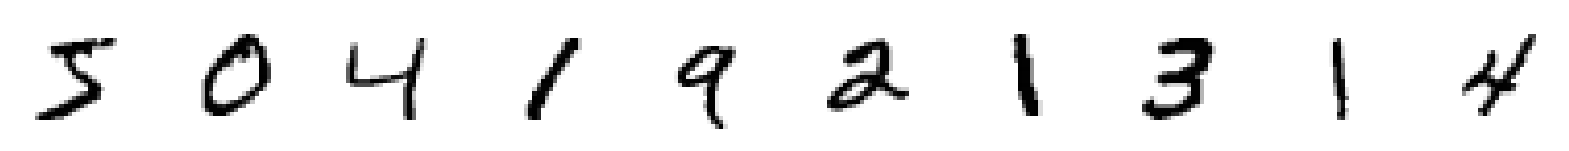

In [ ]:
# Show some items of clothing from the training set
train_sample = sample_batch(x_train)
display(train_sample)

## Build the EBM network

In [ ]:
ebm_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(
    8, kernel_size=5, strides=2, padding="same", activation=activations.swish
)(ebm_input)
x = layers.Conv2D(
    16, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    32, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation=activations.swish)(x)
ebm_output = layers.Dense(1)(x)
model = models.Model(ebm_input, ebm_output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,025 (160.25 KB)

 Trainable params: 41,025 (160.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
if LOAD_MODEL:
    model.load_weights("./models/model.weights.h5")

## Set up a Langevin sampler function

In [ ]:
# Function to generate samples using Langevin Dynamics
def generate_samples(
    model, inp_imgs, steps, step_size, noise, return_img_per_step=False
):
    imgs_per_step = []
    for _ in range(steps):
        inp_imgs += tf.random.normal(inp_imgs.shape, mean=0, stddev=noise)
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        with tf.GradientTape() as tape:
            tape.watch(inp_imgs)
            out_score = model(inp_imgs)
        grads = tape.gradient(out_score, inp_imgs)
        grads = tf.clip_by_value(grads, -GRADIENT_CLIP, GRADIENT_CLIP)
        inp_imgs += step_size * grads
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        if return_img_per_step:
            imgs_per_step.append(inp_imgs)
    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0)
    else:
        return inp_imgs

## Set up a buffer to store examples

In [ ]:
class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.examples = [
            tf.random.uniform(shape=(1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2
            - 1
            for _ in range(BATCH_SIZE)
        ]

    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(BATCH_SIZE, 0.05)
        rand_imgs = (
            tf.random.uniform((n_new, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
        )
        old_imgs = tf.concat(
            random.choices(self.examples, k=BATCH_SIZE - n_new), axis=0
        )
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)
        inp_imgs = generate_samples(
            self.model, inp_imgs, steps=steps, step_size=step_size, noise=noise
        )
        self.examples = tf.split(inp_imgs, BATCH_SIZE, axis=0) + self.examples
        self.examples = self.examples[:BUFFER_SIZE]
        return inp_imgs

In [ ]:
class EBM(models.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.model = model
        self.buffer = Buffer(self.model)
        self.alpha = ALPHA
        self.loss_metric = metrics.Mean(name="loss")
        self.reg_loss_metric = metrics.Mean(name="reg")
        self.cdiv_loss_metric = metrics.Mean(name="cdiv")
        self.real_out_metric = metrics.Mean(name="real")
        self.fake_out_metric = metrics.Mean(name="fake")

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric,
        ]

    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(
            shape=tf.shape(real_imgs), mean=0, stddev=NOISE
        )
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.buffer.sample_new_exmps(
            steps=STEPS, step_size=STEP_SIZE, noise=NOISE
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
                real_out, axis=0
            )
            reg_loss = self.alpha * tf.reduce_mean(
                real_out**2 + fake_out**2, axis=0
            )
            loss = cdiv_loss + reg_loss
        grads = training_tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables)
        )
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, real_imgs):
        batch_size = real_imgs.shape[0]
        fake_imgs = (
            tf.random.uniform((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
            * 2
            - 1
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
        cdiv = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
            real_out, axis=0
        )
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics[2:]}

In [ ]:
ebm = EBM()

## Train the EBM network

In [ ]:
# Compile and train the model
ebm.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), run_eagerly=True
)

In [ ]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = (
            np.random.uniform(
                size=(self.num_img, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
            )
            * 2
            - 1
        )
        generated_images = generate_samples(
            ebm.model,
            start_imgs,
            steps=1000,
            step_size=STEP_SIZE,
            noise=NOISE,
            return_img_per_step=False,
        )
        generated_images = generated_images.numpy()
        display(generated_images)

        example_images = tf.concat(
            random.choices(ebm.buffer.examples, k=10), axis=0
        )
        example_images = example_images.numpy()
        display(example_images)


image_generator_callback = ImageGenerator(num_img=10)

In [ ]:
class SaveModel(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        model.save_weights("./models/model.weights.h5")


save_model_callback = SaveModel()

Epoch 1/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - cdiv: -0.0859 - fake: 0.2446 - loss: -0.0592 - real: 0.3305 - reg: 0.0267

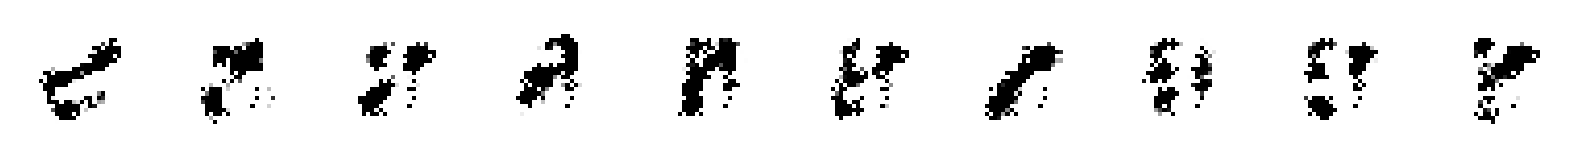

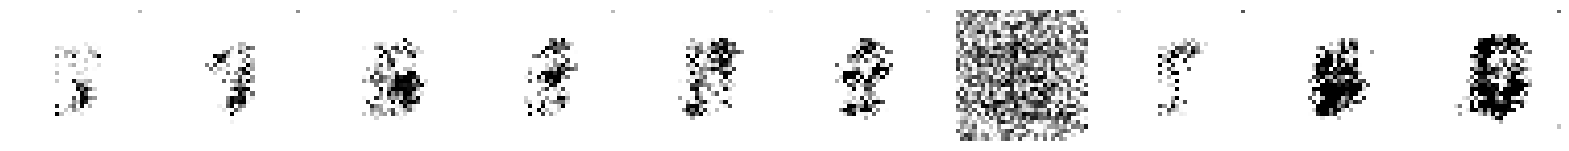

469/469 ━━━━━━━━━━━━━━━━━━━━ 334s 712ms/step - cdiv: -0.0859 - fake: 0.2446 - loss: -0.0592 - real: 0.3304 - reg: 0.0267 - val_cdiv: -1.2163 - val_fake: -1.1966 - val_real: 0.0197
Epoch 2/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - cdiv: -0.0430 - fake: 0.0298 - loss: -0.0356 - real: 0.0728 - reg: 0.0075

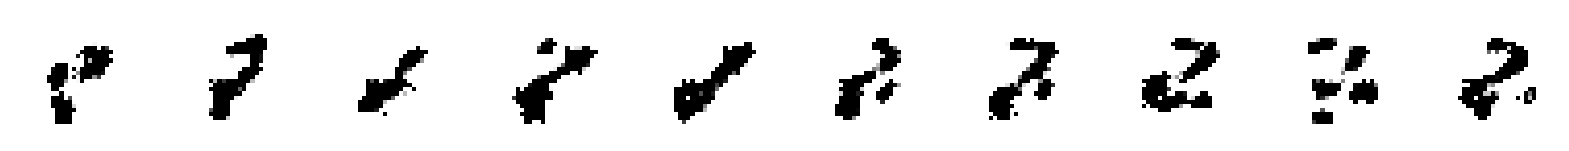

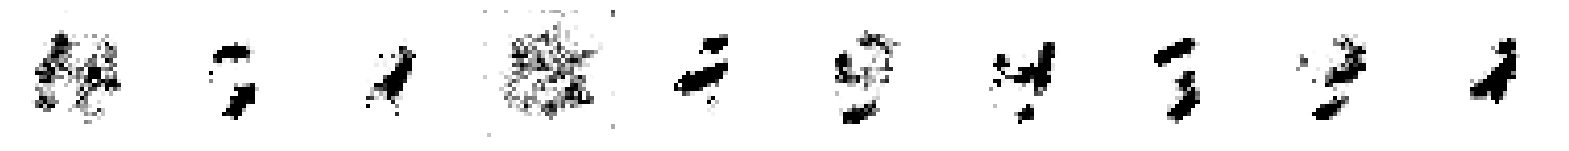

469/469 ━━━━━━━━━━━━━━━━━━━━ 335s 714ms/step - cdiv: -0.0430 - fake: 0.0297 - loss: -0.0355 - real: 0.0727 - reg: 0.0075 - val_cdiv: -2.3233 - val_fake: -2.4070 - val_real: -0.0837
Epoch 3/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - cdiv: -0.0166 - fake: -1.6732e-04 - loss: -0.0113 - real: 0.0164 - reg: 0.0053

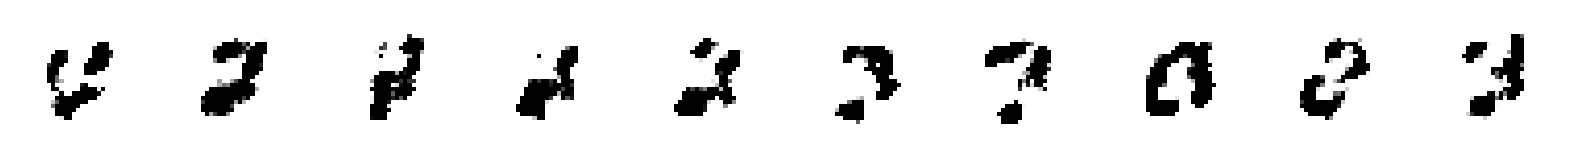

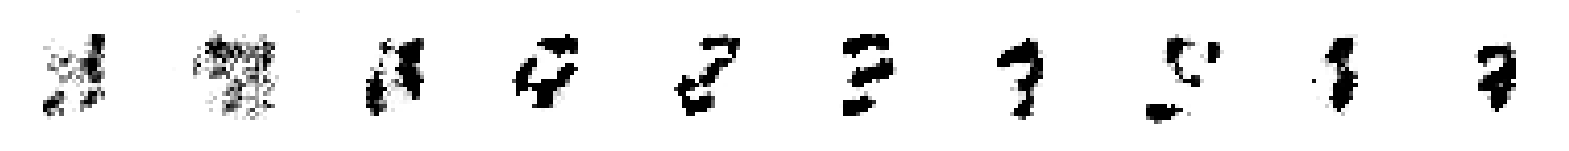

469/469 ━━━━━━━━━━━━━━━━━━━━ 335s 714ms/step - cdiv: -0.0166 - fake: -1.6416e-04 - loss: -0.0113 - real: 0.0164 - reg: 0.0053 - val_cdiv: -3.0434 - val_fake: -3.1014 - val_real: -0.0579
Epoch 4/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - cdiv: -0.0067 - fake: 4.1128e-04 - loss: -0.0041 - real: 0.0071 - reg: 0.0026

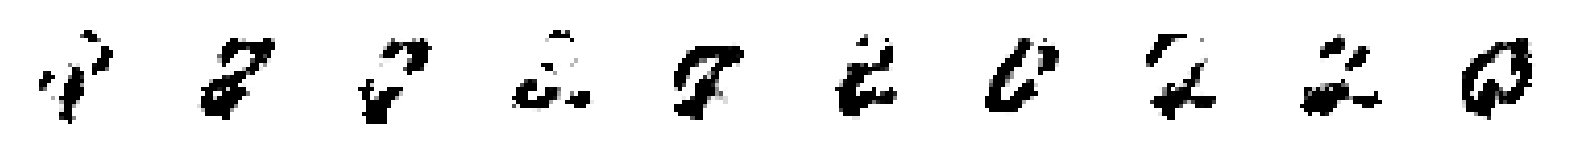

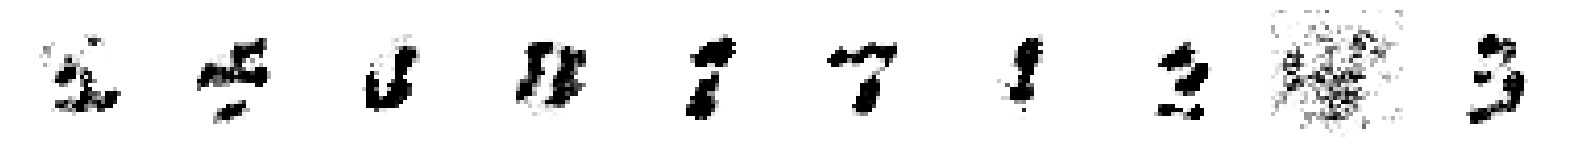

469/469 ━━━━━━━━━━━━━━━━━━━━ 337s 718ms/step - cdiv: -0.0067 - fake: 4.1350e-04 - loss: -0.0041 - real: 0.0071 - reg: 0.0026 - val_cdiv: -3.5145 - val_fake: -3.5365 - val_real: -0.0221
Epoch 5/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - cdiv: -0.0035 - fake: 5.4068e-04 - loss: -0.0022 - real: 0.0040 - reg: 0.0013

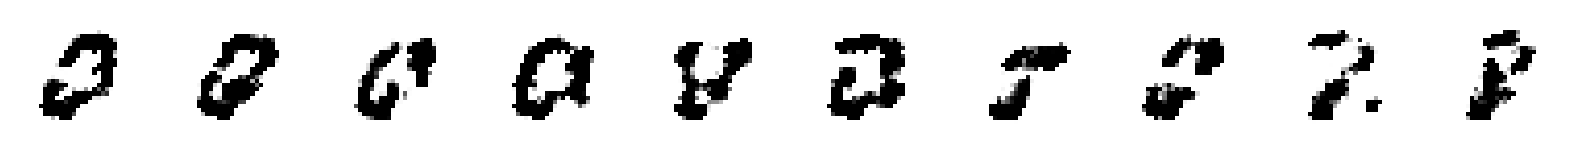

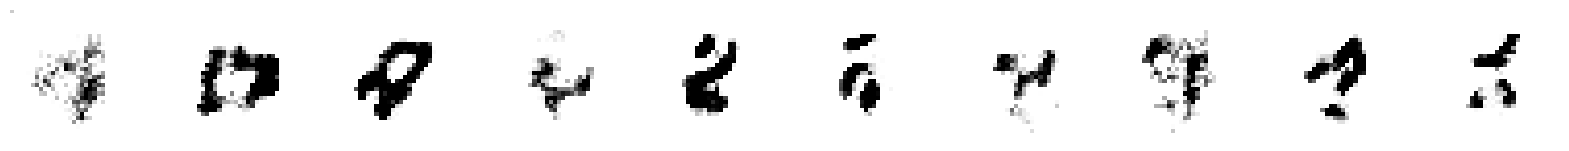

469/469 ━━━━━━━━━━━━━━━━━━━━ 338s 721ms/step - cdiv: -0.0035 - fake: 5.4275e-04 - loss: -0.0022 - real: 0.0040 - reg: 0.0013 - val_cdiv: -4.0463 - val_fake: -4.0477 - val_real: -0.0014
Epoch 6/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - cdiv: -7.4544e-04 - fake: -2.2960e-04 - loss: -3.6291e-05 - real: 5.1584e-04 - reg: 7.0915e-04

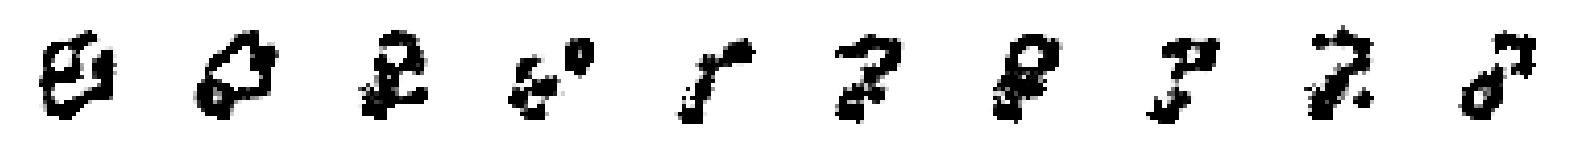

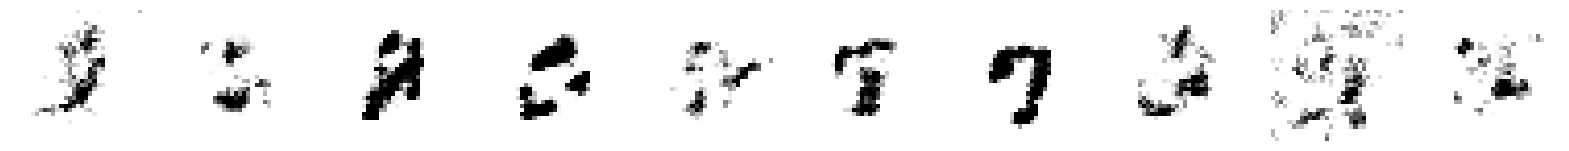

469/469 ━━━━━━━━━━━━━━━━━━━━ 336s 716ms/step - cdiv: -7.4523e-04 - fake: -2.2630e-04 - loss: -3.6305e-05 - real: 5.1892e-04 - reg: 7.0892e-04 - val_cdiv: -4.5260 - val_fake: -4.5177 - val_real: 0.0082
Epoch 7/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - cdiv: -0.0023 - fake: -0.0012 - loss: -0.0016 - real: 0.0012 - reg: 7.0283e-04

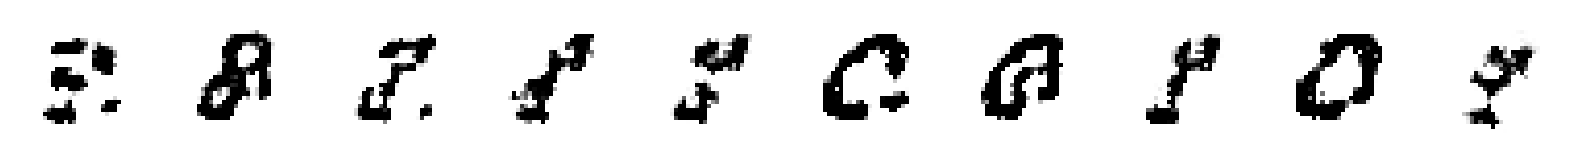

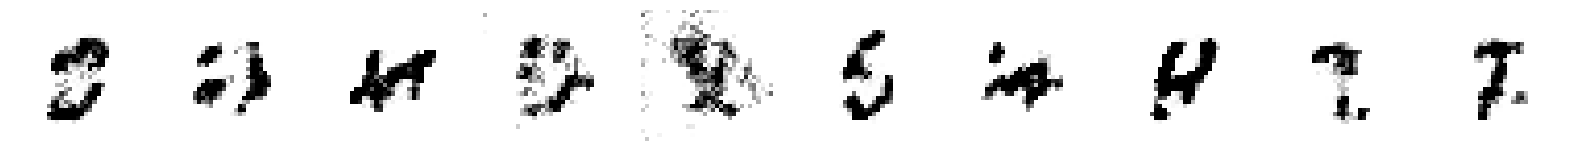

469/469 ━━━━━━━━━━━━━━━━━━━━ 336s 717ms/step - cdiv: -0.0023 - fake: -0.0012 - loss: -0.0016 - real: 0.0012 - reg: 7.0265e-04 - val_cdiv: -5.2190 - val_fake: -5.1816 - val_real: 0.0373
Epoch 8/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - cdiv: -0.0021 - fake: -0.0028 - loss: -0.0014 - real: -6.8854e-04 - reg: 7.3781e-04

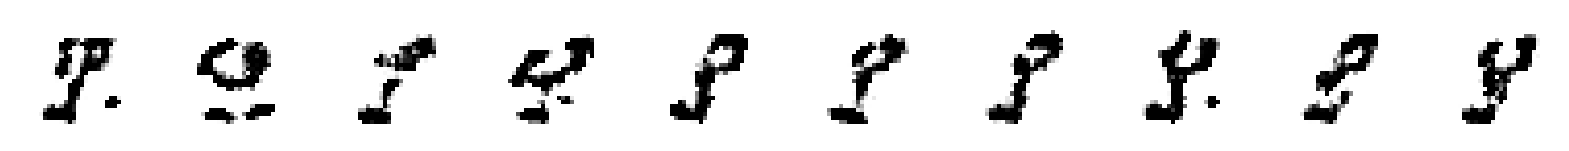

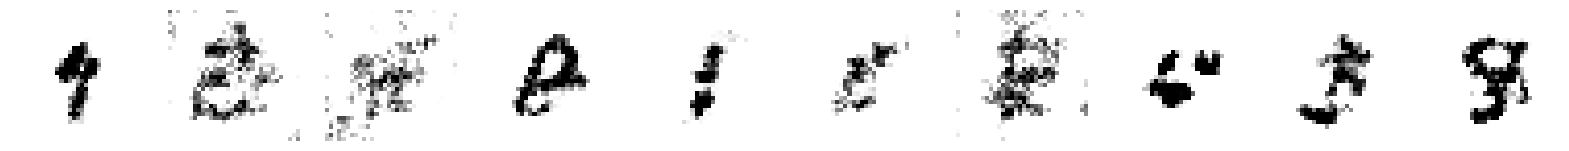

469/469 ━━━━━━━━━━━━━━━━━━━━ 333s 710ms/step - cdiv: -0.0021 - fake: -0.0028 - loss: -0.0014 - real: -6.8352e-04 - reg: 7.3744e-04 - val_cdiv: -5.8122 - val_fake: -5.7651 - val_real: 0.0471
Epoch 9/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - cdiv: -0.0018 - fake: -0.0029 - loss: -0.0011 - real: -0.0011 - reg: 6.7000e-04

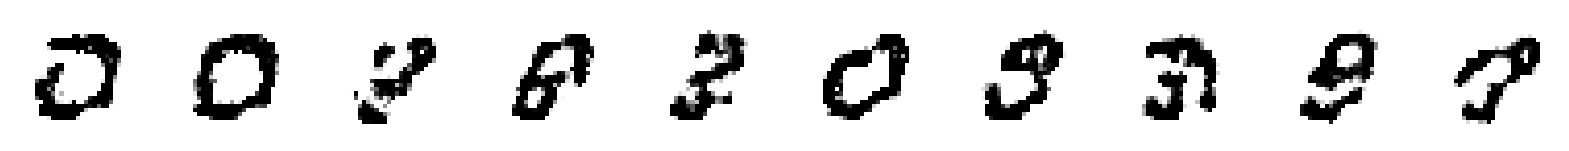

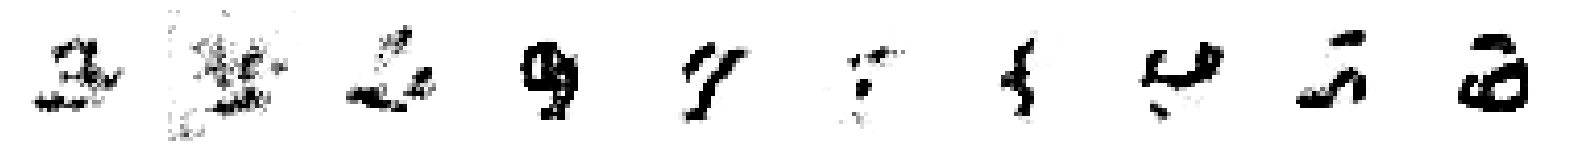

469/469 ━━━━━━━━━━━━━━━━━━━━ 317s 676ms/step - cdiv: -0.0018 - fake: -0.0029 - loss: -0.0011 - real: -0.0011 - reg: 6.6972e-04 - val_cdiv: -6.4124 - val_fake: -6.3820 - val_real: 0.0304
Epoch 10/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - cdiv: -0.0026 - fake: -0.0048 - loss: -0.0018 - real: -0.0022 - reg: 7.8554e-04

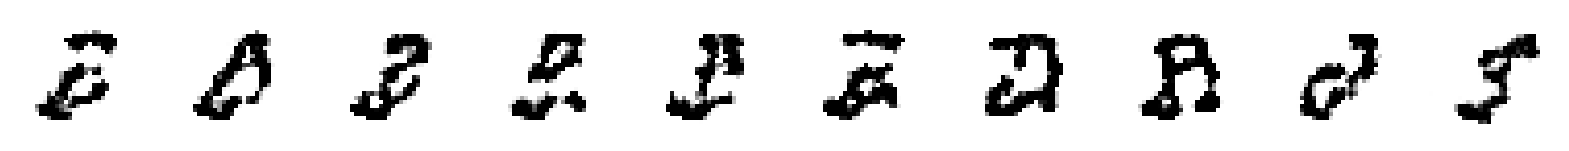

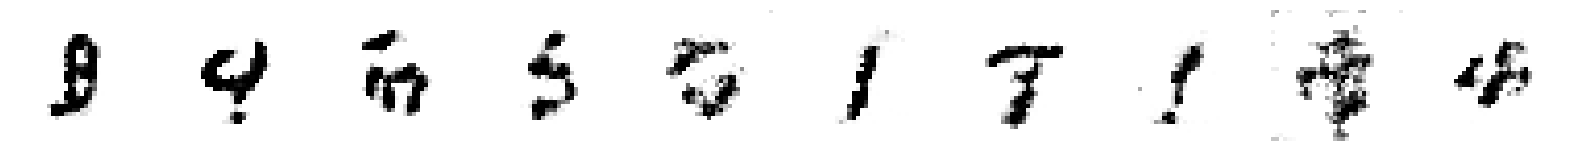

469/469 ━━━━━━━━━━━━━━━━━━━━ 318s 678ms/step - cdiv: -0.0026 - fake: -0.0048 - loss: -0.0018 - real: -0.0022 - reg: 7.8512e-04 - val_cdiv: -7.2213 - val_fake: -7.1831 - val_real: 0.0382
Epoch 11/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - cdiv: -0.0024 - fake: -0.0041 - loss: -0.0017 - real: -0.0016 - reg: 7.1852e-04

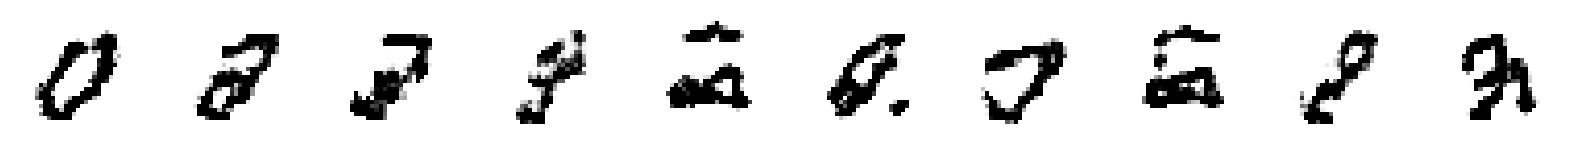

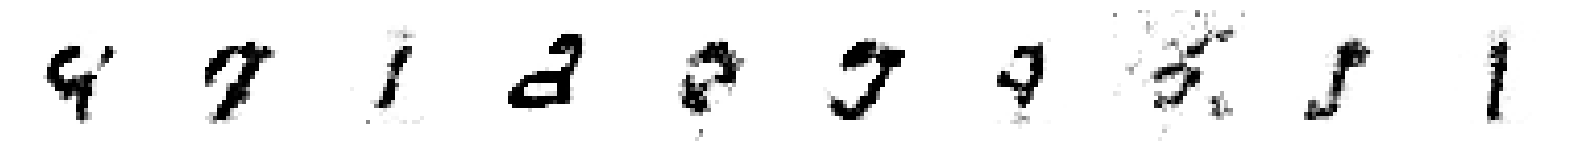

469/469 ━━━━━━━━━━━━━━━━━━━━ 318s 678ms/step - cdiv: -0.0024 - fake: -0.0041 - loss: -0.0017 - real: -0.0016 - reg: 7.1813e-04 - val_cdiv: -7.9743 - val_fake: -7.9303 - val_real: 0.0440
Epoch 12/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - cdiv: -0.0020 - fake: -0.0029 - loss: -0.0013 - real: -9.2203e-04 - reg: 6.4246e-04

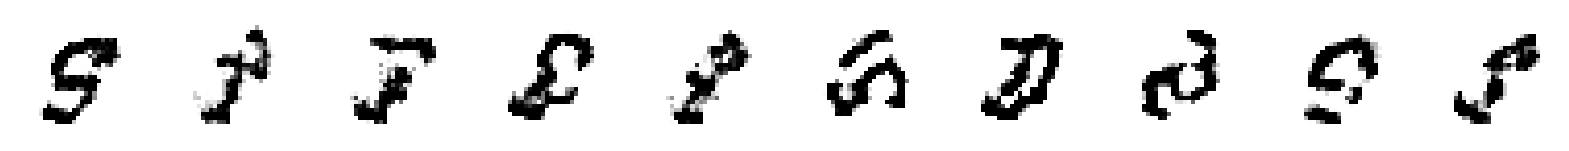

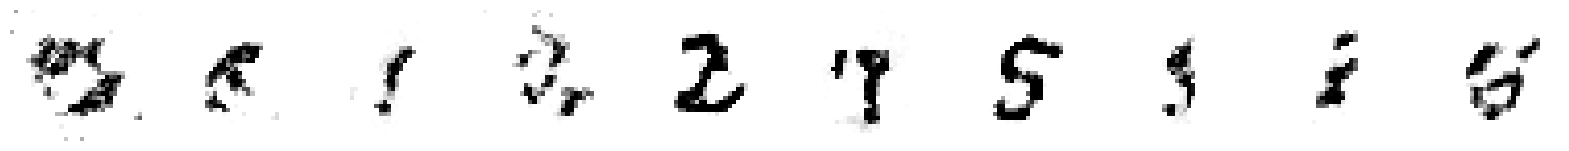

469/469 ━━━━━━━━━━━━━━━━━━━━ 318s 679ms/step - cdiv: -0.0020 - fake: -0.0029 - loss: -0.0013 - real: -9.1725e-04 - reg: 6.4220e-04 - val_cdiv: -8.7758 - val_fake: -8.7251 - val_real: 0.0507
Epoch 13/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - cdiv: -0.0016 - fake: -0.0013 - loss: -9.1391e-04 - real: 2.6105e-04 - reg: 6.5615e-04

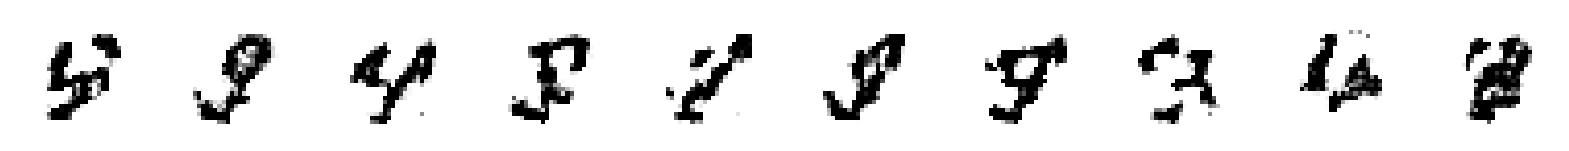

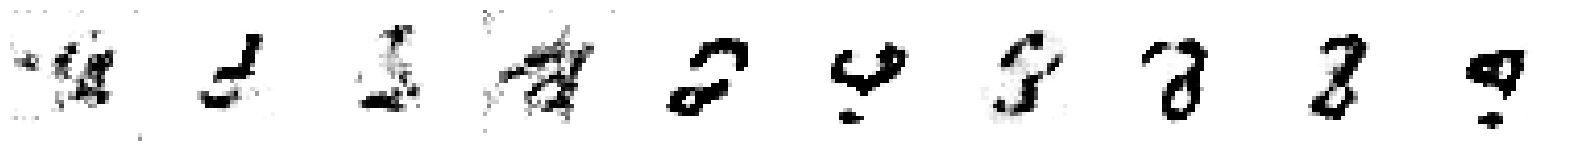

469/469 ━━━━━━━━━━━━━━━━━━━━ 321s 684ms/step - cdiv: -0.0016 - fake: -0.0013 - loss: -9.1299e-04 - real: 2.6315e-04 - reg: 6.5571e-04 - val_cdiv: -9.3537 - val_fake: -9.3238 - val_real: 0.0299
Epoch 14/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - cdiv: -0.0016 - fake: -0.0025 - loss: -0.0011 - real: -9.3570e-04 - reg: 4.7878e-04

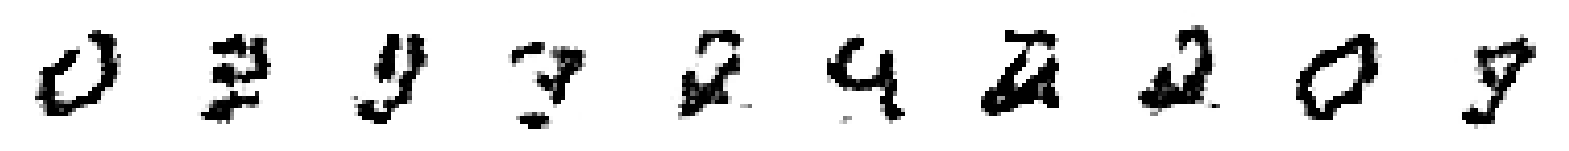

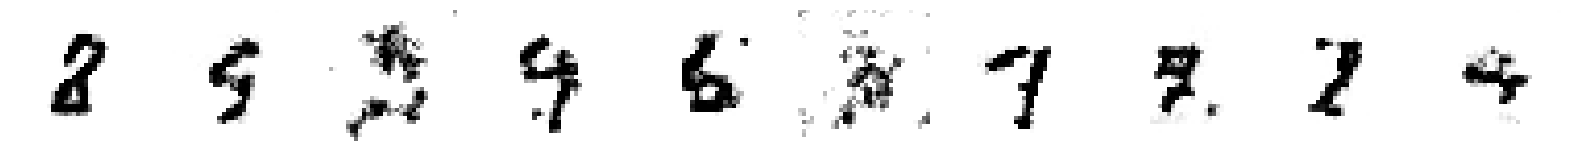

469/469 ━━━━━━━━━━━━━━━━━━━━ 320s 682ms/step - cdiv: -0.0016 - fake: -0.0025 - loss: -0.0011 - real: -9.3161e-04 - reg: 4.7857e-04 - val_cdiv: -9.9894 - val_fake: -9.9656 - val_real: 0.0238
Epoch 15/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - cdiv: -0.0015 - fake: -0.0026 - loss: -9.7541e-04 - real: -0.0012 - reg: 4.8212e-04

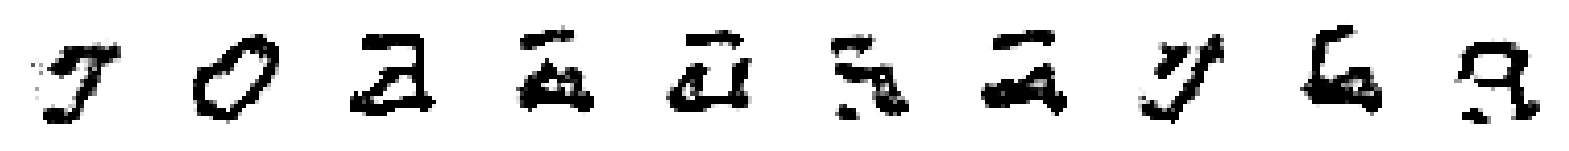

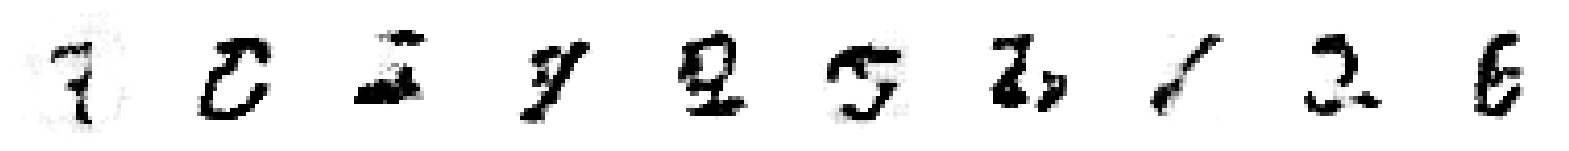

469/469 ━━━━━━━━━━━━━━━━━━━━ 320s 683ms/step - cdiv: -0.0015 - fake: -0.0026 - loss: -9.7413e-04 - real: -0.0012 - reg: 4.8189e-04 - val_cdiv: -10.5439 - val_fake: -10.5136 - val_real: 0.0304
Epoch 16/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - cdiv: -0.0016 - fake: -0.0025 - loss: -0.0012 - real: -9.0108e-04 - reg: 4.3423e-04

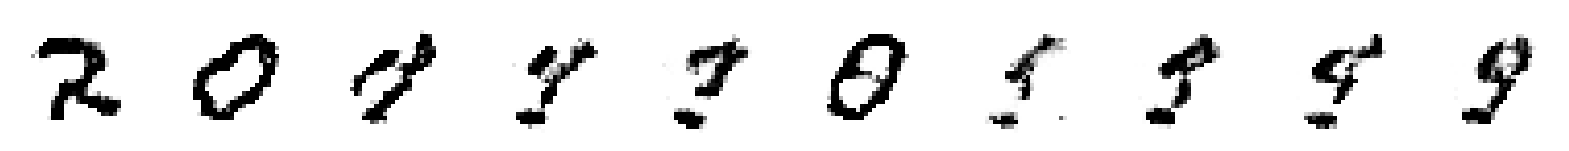

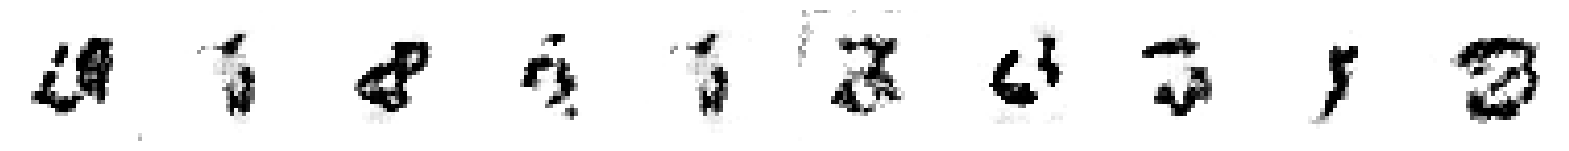

469/469 ━━━━━━━━━━━━━━━━━━━━ 321s 685ms/step - cdiv: -0.0016 - fake: -0.0025 - loss: -0.0012 - real: -8.9679e-04 - reg: 4.3412e-04 - val_cdiv: -11.1600 - val_fake: -11.1362 - val_real: 0.0238
Epoch 17/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - cdiv: -0.0015 - fake: -0.0019 - loss: -0.0011 - real: -3.5277e-04 - reg: 4.5184e-04

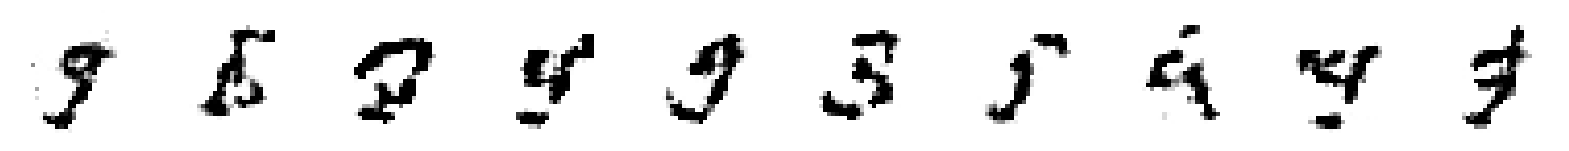

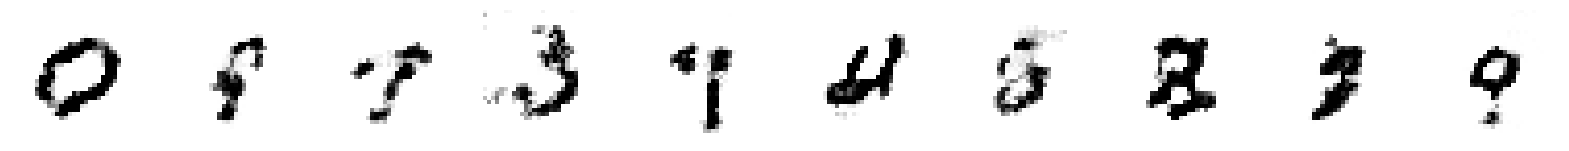

469/469 ━━━━━━━━━━━━━━━━━━━━ 324s 690ms/step - cdiv: -0.0015 - fake: -0.0019 - loss: -0.0011 - real: -3.5077e-04 - reg: 4.5162e-04 - val_cdiv: -11.7648 - val_fake: -11.7441 - val_real: 0.0207
Epoch 18/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - cdiv: -0.0013 - fake: -0.0018 - loss: -8.4326e-04 - real: -4.7798e-04 - reg: 4.7291e-04

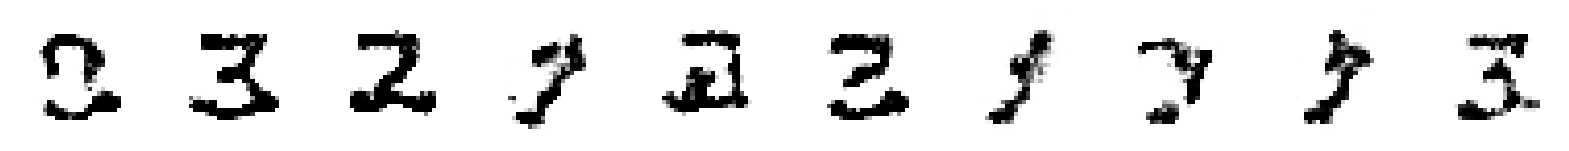

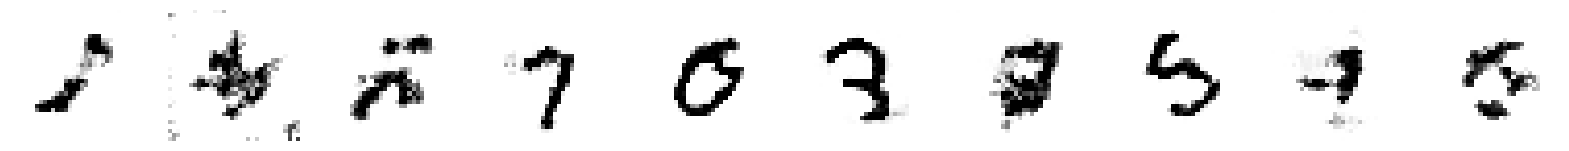

469/469 ━━━━━━━━━━━━━━━━━━━━ 323s 688ms/step - cdiv: -0.0013 - fake: -0.0018 - loss: -8.4277e-04 - real: -4.7539e-04 - reg: 4.7267e-04 - val_cdiv: -12.5271 - val_fake: -12.4990 - val_real: 0.0281
Epoch 19/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - cdiv: -0.0015 - fake: -6.2575e-04 - loss: -0.0011 - real: 9.1376e-04 - reg: 4.3432e-04

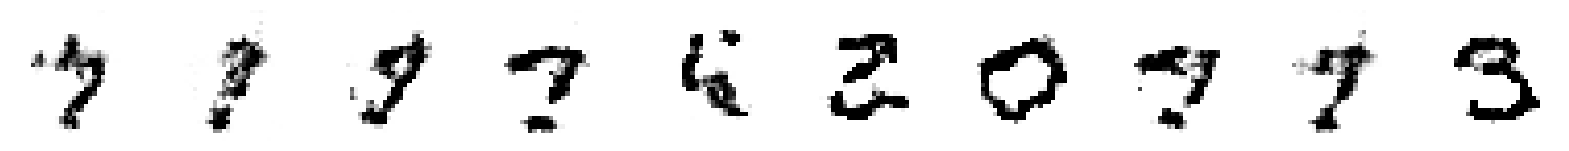

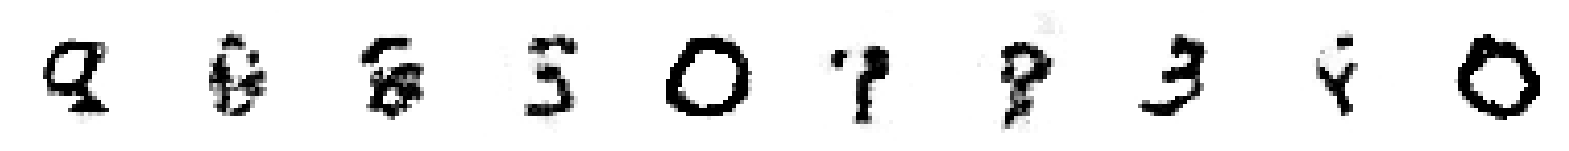

469/469 ━━━━━━━━━━━━━━━━━━━━ 323s 689ms/step - cdiv: -0.0015 - fake: -6.2388e-04 - loss: -0.0011 - real: 9.1394e-04 - reg: 4.3407e-04 - val_cdiv: -13.2760 - val_fake: -13.2538 - val_real: 0.0223
Epoch 20/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - cdiv: -0.0011 - fake: -0.0013 - loss: -7.5395e-04 - real: -2.0026e-04 - reg: 3.3834e-04

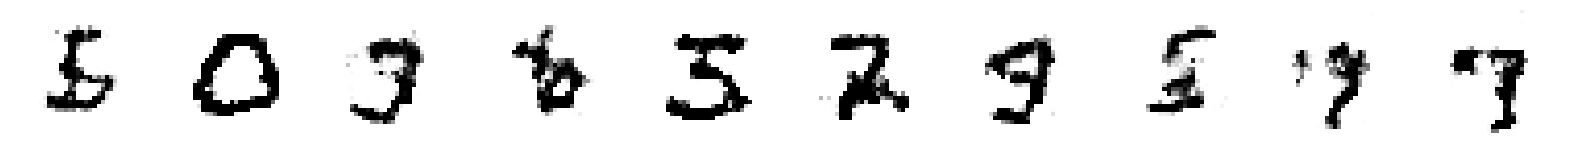

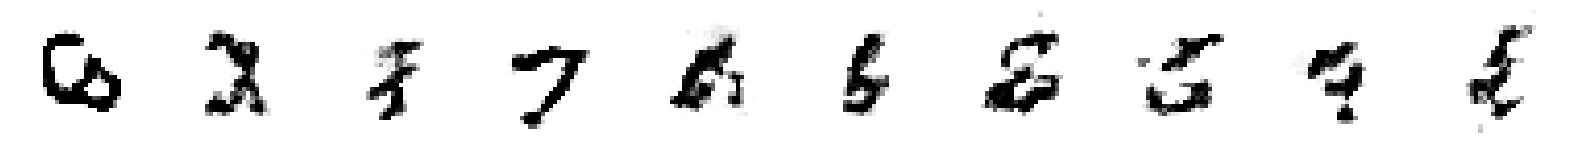

469/469 ━━━━━━━━━━━━━━━━━━━━ 323s 688ms/step - cdiv: -0.0011 - fake: -0.0013 - loss: -7.5322e-04 - real: -1.9874e-04 - reg: 3.3820e-04 - val_cdiv: -13.9845 - val_fake: -13.9567 - val_real: 0.0278
Epoch 21/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - cdiv: -0.0010 - fake: -8.5240e-04 - loss: -6.4294e-04 - real: 1.6206e-04 - reg: 3.7152e-04

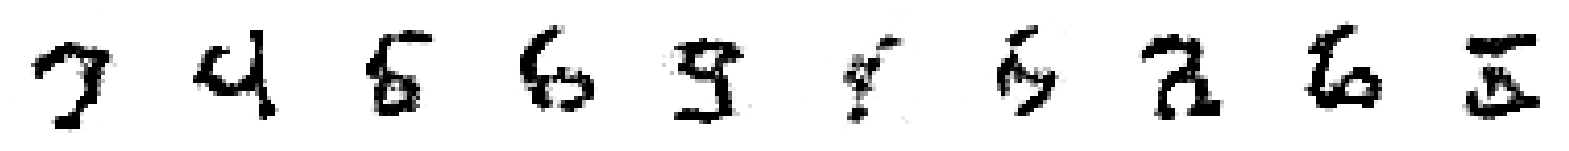

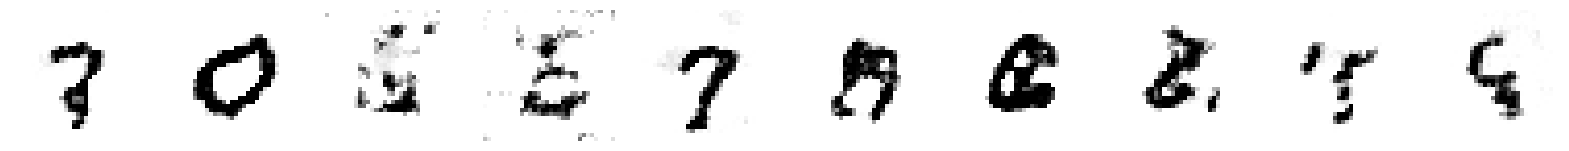

469/469 ━━━━━━━━━━━━━━━━━━━━ 326s 695ms/step - cdiv: -0.0010 - fake: -8.5093e-04 - loss: -6.4146e-04 - real: 1.6185e-04 - reg: 3.7131e-04 - val_cdiv: -14.2541 - val_fake: -14.2391 - val_real: 0.0150
Epoch 22/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - cdiv: -0.0014 - fake: 1.7142e-04 - loss: -0.0011 - real: 0.0015 - reg: 3.0463e-04

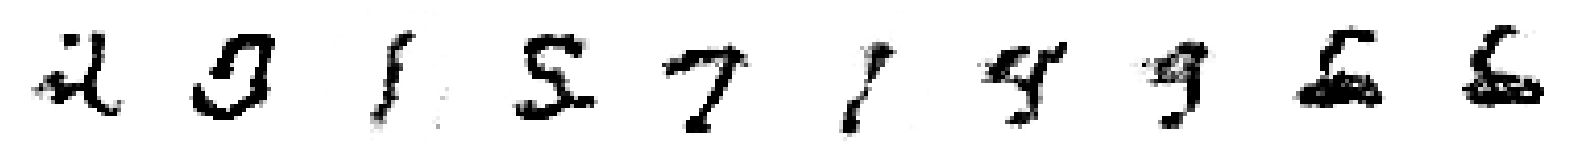

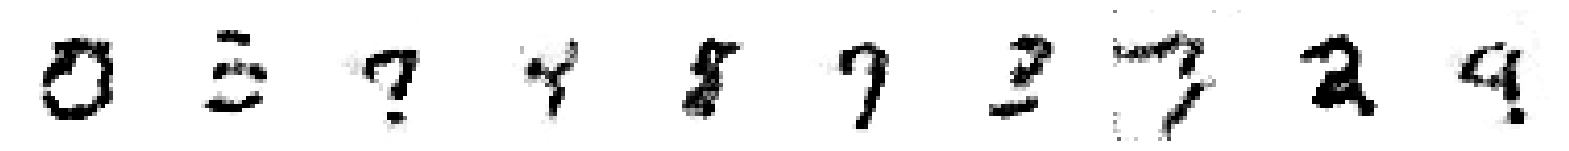

469/469 ━━━━━━━━━━━━━━━━━━━━ 324s 690ms/step - cdiv: -0.0014 - fake: 1.7131e-04 - loss: -0.0010 - real: 0.0015 - reg: 3.0457e-04 - val_cdiv: -15.0716 - val_fake: -15.0544 - val_real: 0.0172
Epoch 23/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - cdiv: -5.5894e-04 - fake: -5.8516e-04 - loss: -2.3820e-04 - real: -2.6228e-05 - reg: 3.2073e-04

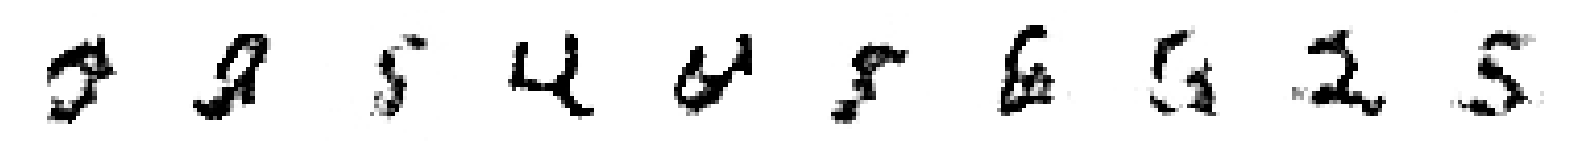

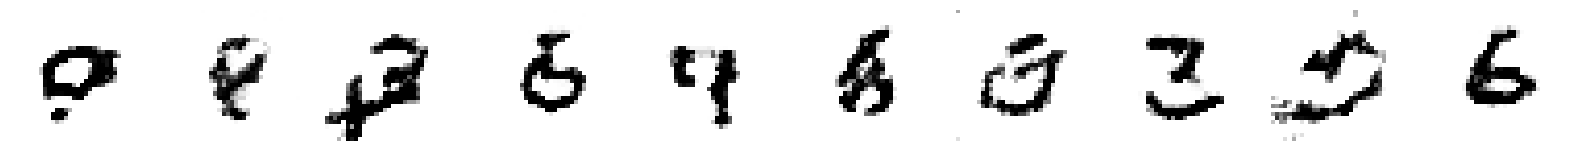

469/469 ━━━━━━━━━━━━━━━━━━━━ 326s 696ms/step - cdiv: -5.5868e-04 - fake: -5.8379e-04 - loss: -2.3804e-04 - real: -2.5107e-05 - reg: 3.2064e-04 - val_cdiv: -15.5240 - val_fake: -15.5108 - val_real: 0.0133
Epoch 24/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - cdiv: -0.0012 - fake: -1.6826e-04 - loss: -9.5057e-04 - real: 0.0011 - reg: 2.7510e-04

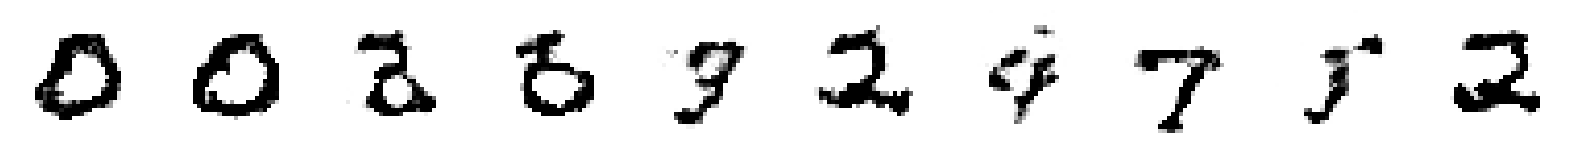

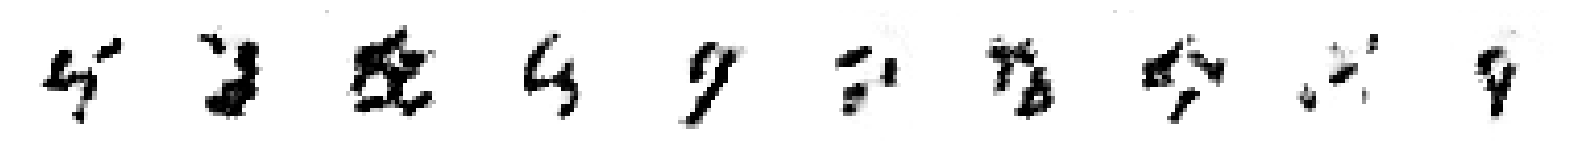

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 692ms/step - cdiv: -0.0012 - fake: -1.6780e-04 - loss: -9.5007e-04 - real: 0.0011 - reg: 2.7504e-04 - val_cdiv: -16.3794 - val_fake: -16.3662 - val_real: 0.0132
Epoch 25/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - cdiv: -0.0010 - fake: -0.0014 - loss: -7.2400e-04 - real: -3.7987e-04 - reg: 2.9163e-04

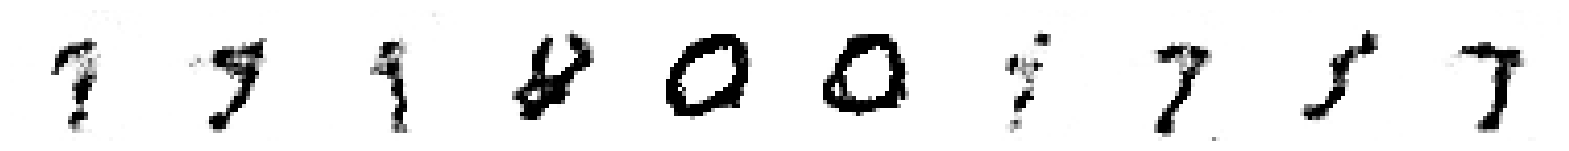

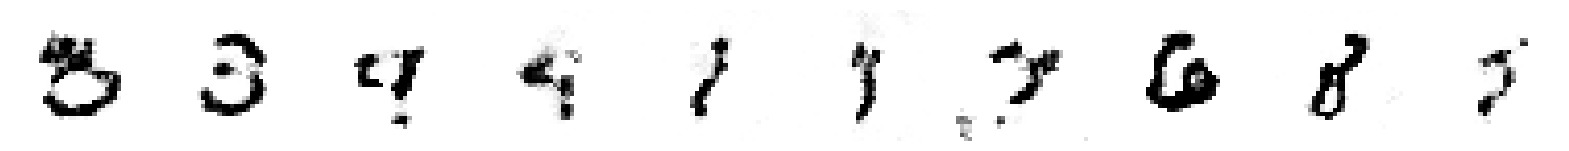

469/469 ━━━━━━━━━━━━━━━━━━━━ 318s 678ms/step - cdiv: -0.0010 - fake: -0.0014 - loss: -7.2249e-04 - real: -3.7863e-04 - reg: 2.9153e-04 - val_cdiv: -16.5341 - val_fake: -16.5271 - val_real: 0.0069
Epoch 26/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - cdiv: -5.3996e-04 - fake: -6.9765e-04 - loss: -2.3554e-04 - real: -1.5769e-04 - reg: 3.0442e-04

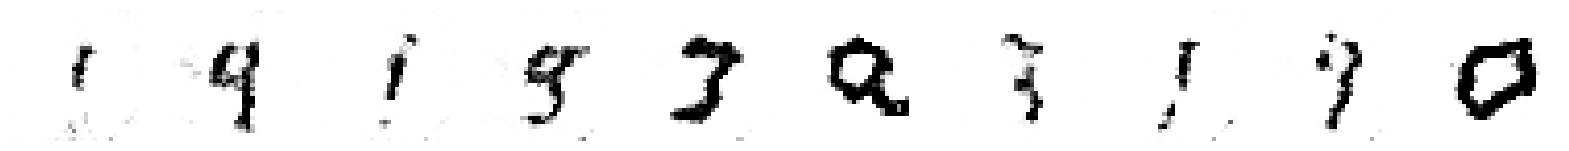

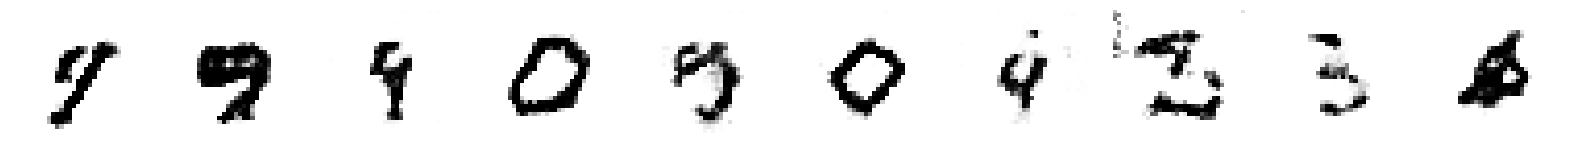

469/469 ━━━━━━━━━━━━━━━━━━━━ 323s 689ms/step - cdiv: -5.3924e-04 - fake: -6.9600e-04 - loss: -2.3491e-04 - real: -1.5676e-04 - reg: 3.0433e-04 - val_cdiv: -16.9261 - val_fake: -16.9114 - val_real: 0.0147
Epoch 27/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - cdiv: -0.0010 - fake: 2.9406e-05 - loss: -7.8959e-04 - real: 0.0011 - reg: 2.4160e-04

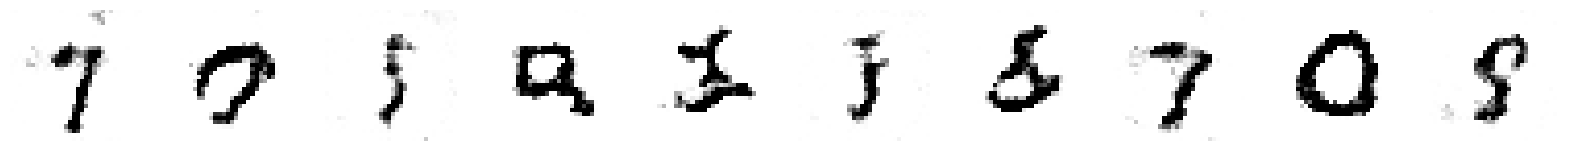

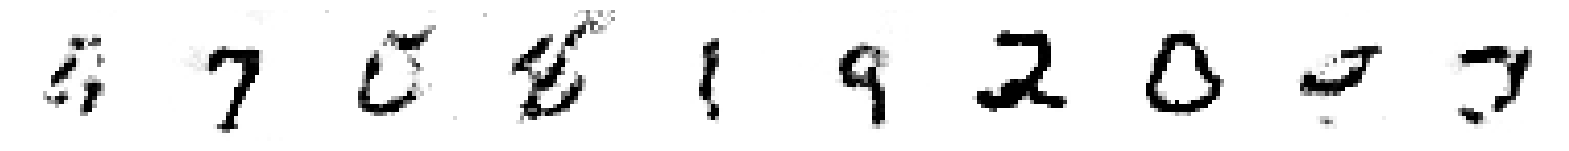

469/469 ━━━━━━━━━━━━━━━━━━━━ 327s 697ms/step - cdiv: -0.0010 - fake: 2.9484e-05 - loss: -7.8814e-04 - real: 0.0011 - reg: 2.4155e-04 - val_cdiv: -17.4912 - val_fake: -17.4804 - val_real: 0.0108
Epoch 28/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - cdiv: -0.0016 - fake: -8.4026e-04 - loss: -0.0013 - real: 7.7697e-04 - reg: 3.2529e-04

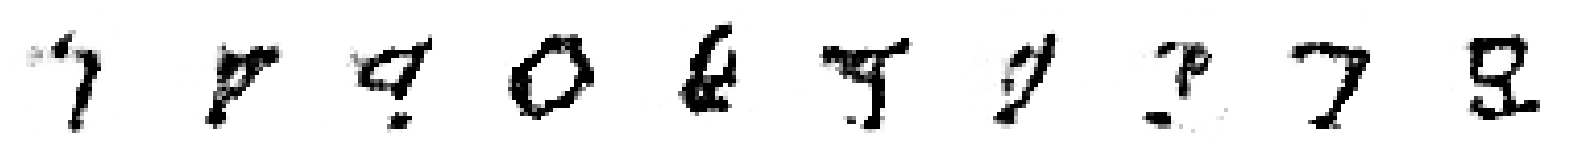

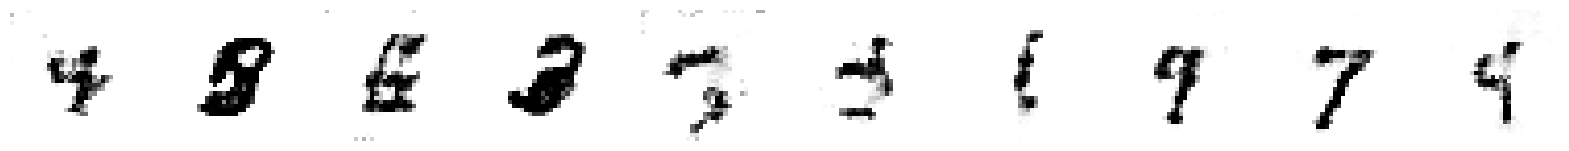

469/469 ━━━━━━━━━━━━━━━━━━━━ 331s 706ms/step - cdiv: -0.0016 - fake: -8.3785e-04 - loss: -0.0013 - real: 7.7786e-04 - reg: 3.2517e-04 - val_cdiv: -17.9728 - val_fake: -17.9574 - val_real: 0.0154
Epoch 29/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - cdiv: -6.5511e-04 - fake: -7.9335e-05 - loss: -3.5654e-04 - real: 5.7578e-04 - reg: 2.9857e-04

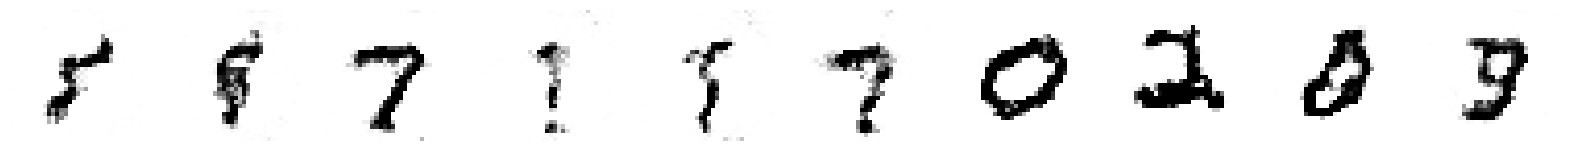

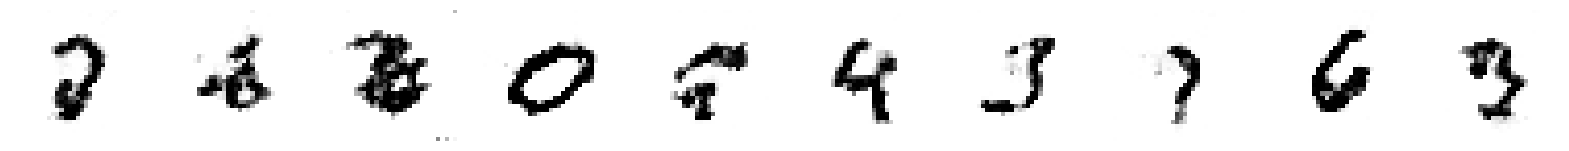

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 693ms/step - cdiv: -6.5392e-04 - fake: -7.8901e-05 - loss: -3.5550e-04 - real: 5.7502e-04 - reg: 2.9842e-04 - val_cdiv: -18.2776 - val_fake: -18.2677 - val_real: 0.0099
Epoch 30/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - cdiv: -0.0014 - fake: -6.5605e-04 - loss: -0.0011 - real: 7.2994e-04 - reg: 3.1607e-04

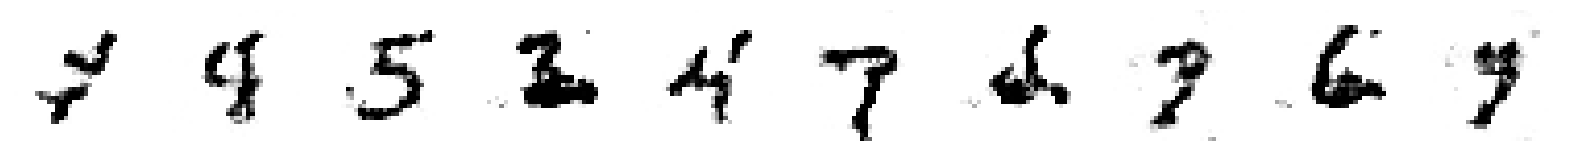

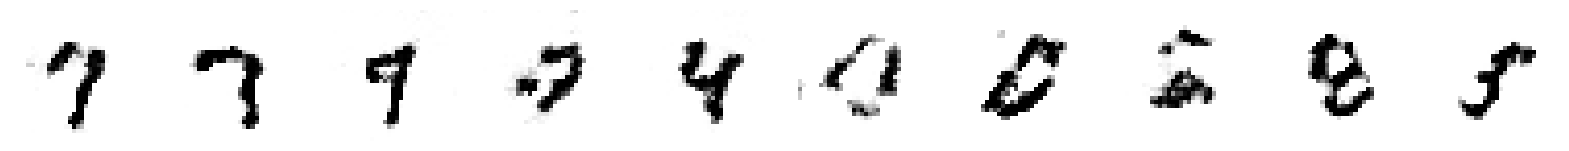

469/469 ━━━━━━━━━━━━━━━━━━━━ 335s 713ms/step - cdiv: -0.0014 - fake: -6.5470e-04 - loss: -0.0011 - real: 7.2953e-04 - reg: 3.1593e-04 - val_cdiv: -18.8846 - val_fake: -18.8719 - val_real: 0.0127
Epoch 31/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - cdiv: -7.2012e-04 - fake: -7.0581e-05 - loss: -4.6856e-04 - real: 6.4954e-04 - reg: 2.5155e-04

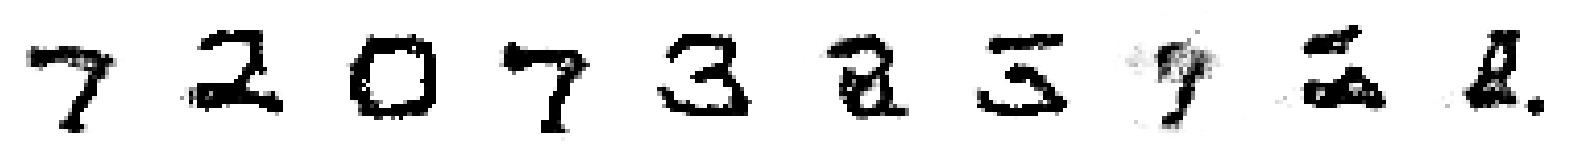

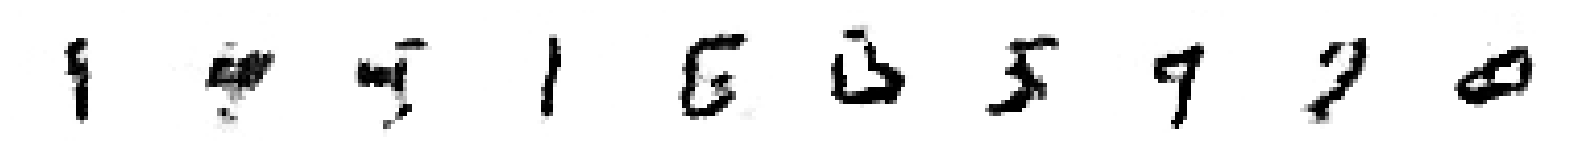

469/469 ━━━━━━━━━━━━━━━━━━━━ 338s 720ms/step - cdiv: -7.1910e-04 - fake: -7.0129e-05 - loss: -4.6760e-04 - real: 6.4897e-04 - reg: 2.5150e-04 - val_cdiv: -19.1957 - val_fake: -19.1809 - val_real: 0.0148
Epoch 32/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - cdiv: -0.0012 - fake: -5.6317e-04 - loss: -9.0417e-04 - real: 6.4857e-04 - reg: 3.0756e-04

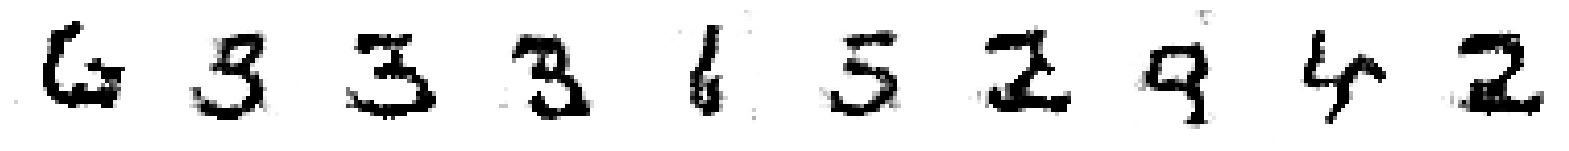

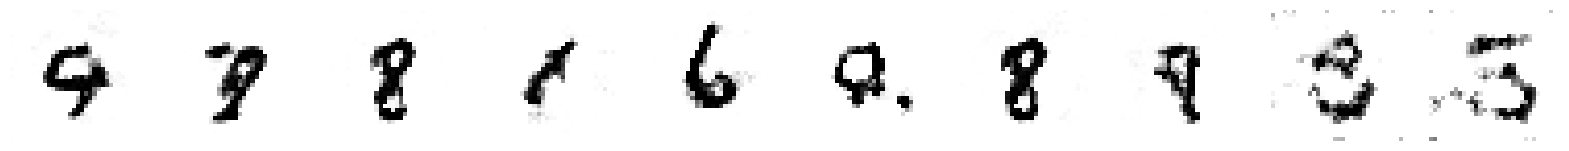

469/469 ━━━━━━━━━━━━━━━━━━━━ 338s 721ms/step - cdiv: -0.0012 - fake: -5.6201e-04 - loss: -9.0251e-04 - real: 6.4794e-04 - reg: 3.0743e-04 - val_cdiv: -19.5916 - val_fake: -19.5841 - val_real: 0.0075
Epoch 33/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - cdiv: -0.0010 - fake: -2.9832e-04 - loss: -7.3530e-04 - real: 7.0335e-04 - reg: 2.6636e-04

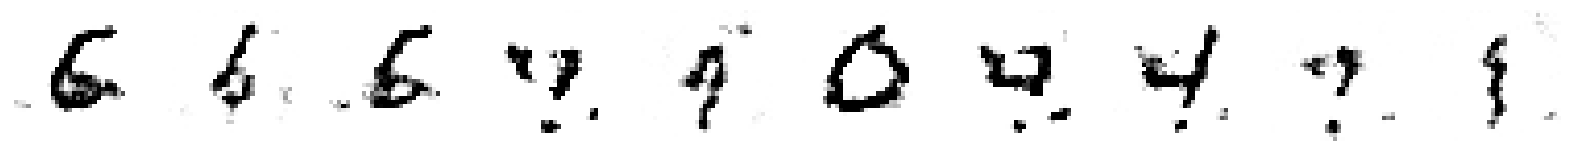

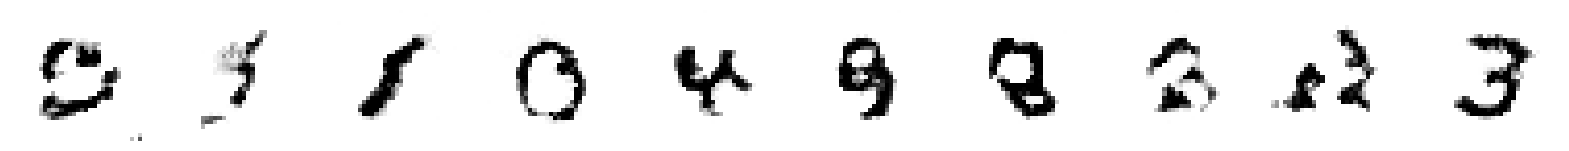

469/469 ━━━━━━━━━━━━━━━━━━━━ 326s 694ms/step - cdiv: -0.0010 - fake: -2.9749e-04 - loss: -7.3461e-04 - real: 7.0348e-04 - reg: 2.6636e-04 - val_cdiv: -19.8833 - val_fake: -19.8689 - val_real: 0.0144
Epoch 34/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - cdiv: -3.6920e-04 - fake: -6.9951e-04 - loss: -2.5728e-05 - real: -3.3032e-04 - reg: 3.4347e-04

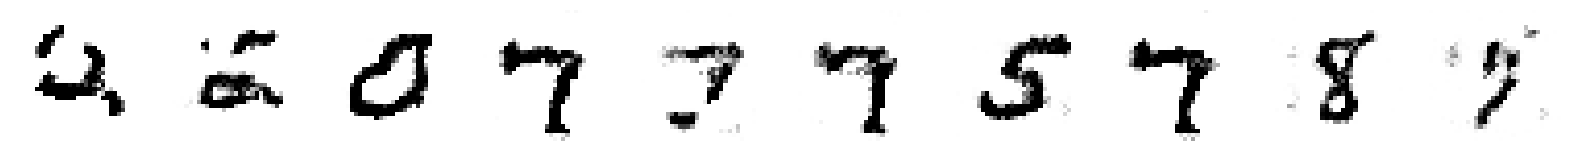

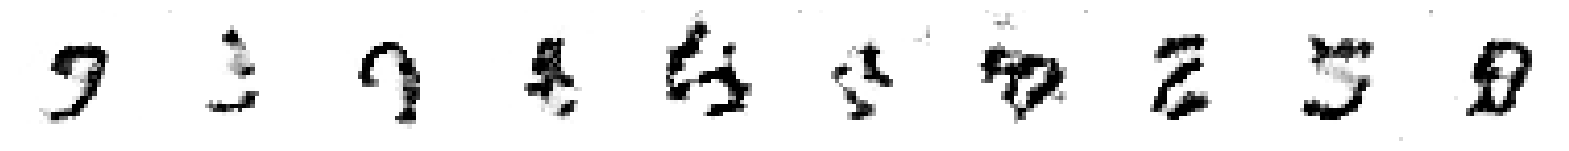

469/469 ━━━━━━━━━━━━━━━━━━━━ 329s 702ms/step - cdiv: -3.6852e-04 - fake: -6.9834e-04 - loss: -2.5228e-05 - real: -3.2982e-04 - reg: 3.4329e-04 - val_cdiv: -20.4277 - val_fake: -20.4069 - val_real: 0.0208
Epoch 35/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - cdiv: -4.4147e-04 - fake: 7.4647e-04 - loss: -1.9545e-04 - real: 0.0012 - reg: 2.4603e-04

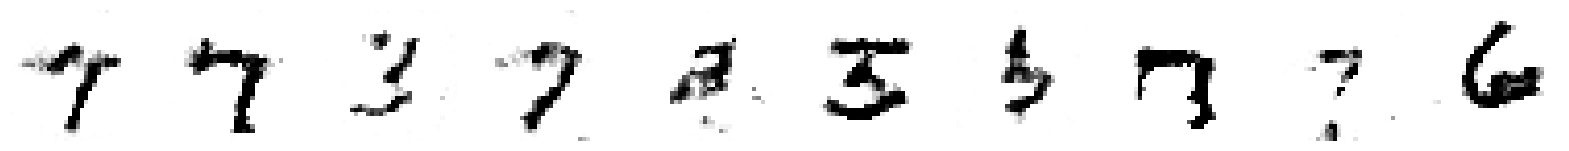

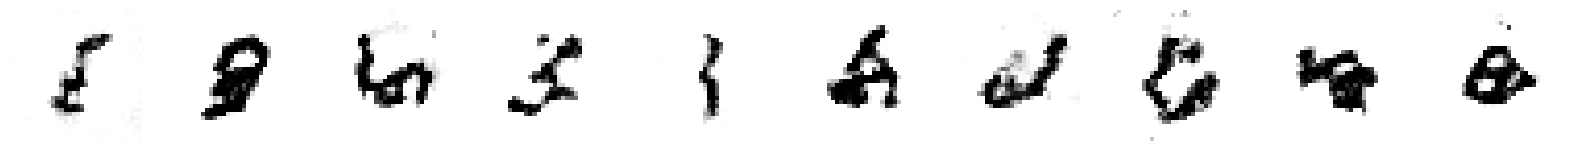

469/469 ━━━━━━━━━━━━━━━━━━━━ 329s 702ms/step - cdiv: -4.4064e-04 - fake: 7.4542e-04 - loss: -1.9470e-04 - real: 0.0012 - reg: 2.4594e-04 - val_cdiv: -20.5458 - val_fake: -20.5303 - val_real: 0.0155
Epoch 36/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - cdiv: -0.0010 - fake: 1.3207e-04 - loss: -7.6007e-04 - real: 0.0012 - reg: 2.6926e-04

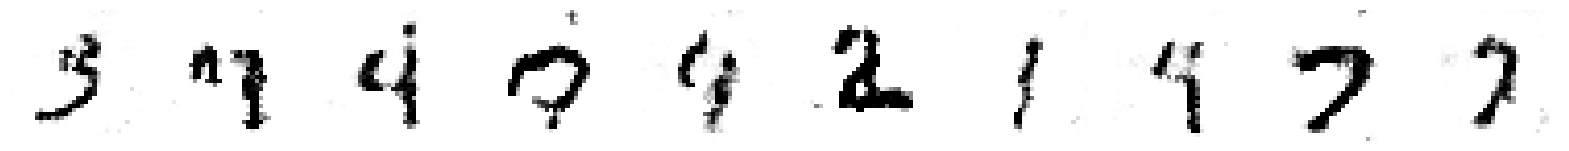

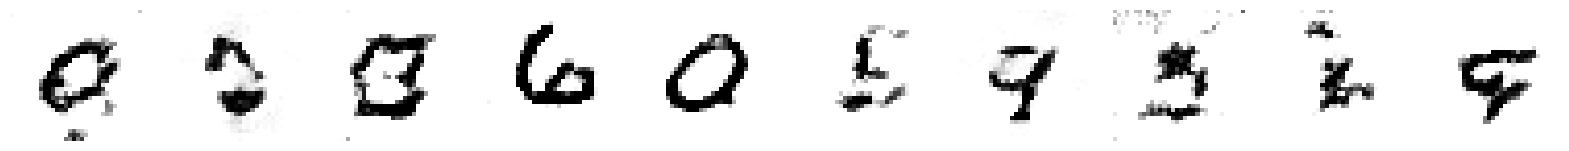

469/469 ━━━━━━━━━━━━━━━━━━━━ 328s 699ms/step - cdiv: -0.0010 - fake: 1.3170e-04 - loss: -7.5894e-04 - real: 0.0012 - reg: 2.6918e-04 - val_cdiv: -20.9359 - val_fake: -20.9229 - val_real: 0.0130
Epoch 37/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - cdiv: -6.6854e-04 - fake: -1.5955e-04 - loss: -4.2932e-04 - real: 5.0899e-04 - reg: 2.3922e-04

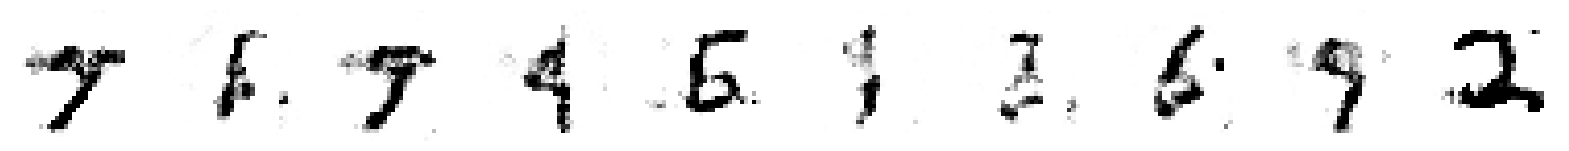

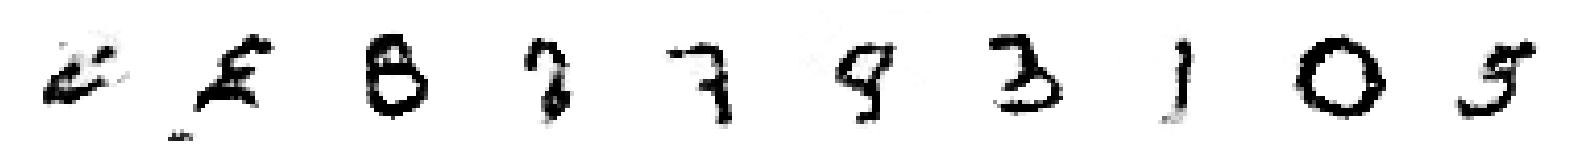

469/469 ━━━━━━━━━━━━━━━━━━━━ 327s 698ms/step - cdiv: -6.6742e-04 - fake: -1.5920e-04 - loss: -4.2827e-04 - real: 5.0822e-04 - reg: 2.3915e-04 - val_cdiv: -21.3515 - val_fake: -21.3334 - val_real: 0.0181
Epoch 38/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - cdiv: -7.0508e-04 - fake: 6.4479e-04 - loss: -4.3660e-04 - real: 0.0013 - reg: 2.6848e-04

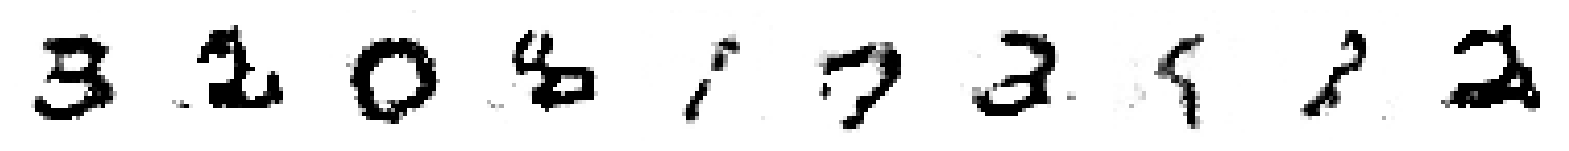

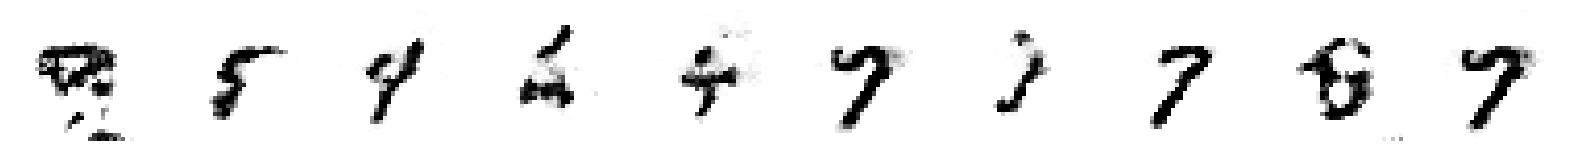

469/469 ━━━━━━━━━━━━━━━━━━━━ 328s 698ms/step - cdiv: -7.0435e-04 - fake: 6.4348e-04 - loss: -4.3595e-04 - real: 0.0013 - reg: 2.6841e-04 - val_cdiv: -21.4793 - val_fake: -21.4638 - val_real: 0.0156
Epoch 39/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - cdiv: -5.4773e-04 - fake: 6.4219e-04 - loss: -2.2269e-04 - real: 0.0012 - reg: 3.2504e-04

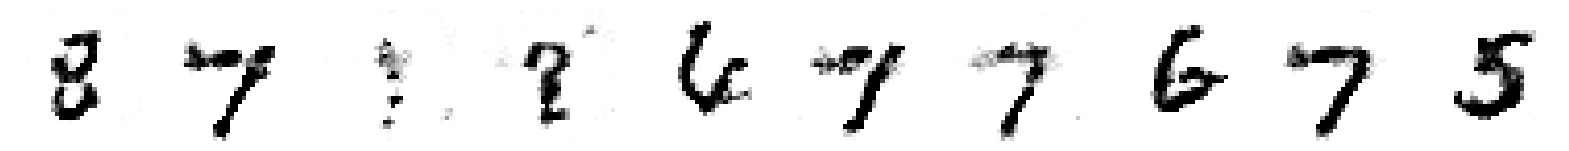

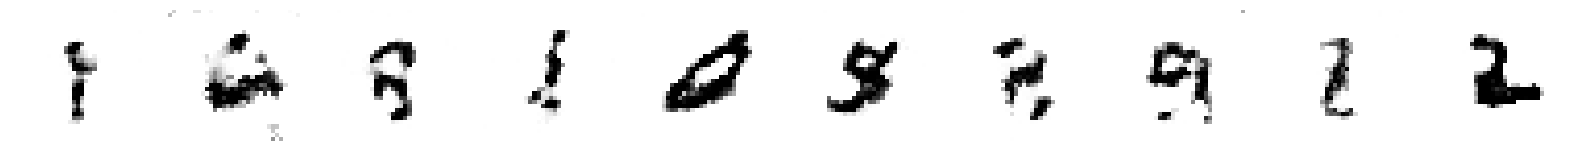

469/469 ━━━━━━━━━━━━━━━━━━━━ 327s 696ms/step - cdiv: -5.4674e-04 - fake: 6.4128e-04 - loss: -2.2182e-04 - real: 0.0012 - reg: 3.2492e-04 - val_cdiv: -21.9540 - val_fake: -21.9378 - val_real: 0.0161
Epoch 40/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - cdiv: -7.9424e-04 - fake: 3.4133e-04 - loss: -5.4078e-04 - real: 0.0011 - reg: 2.5346e-04

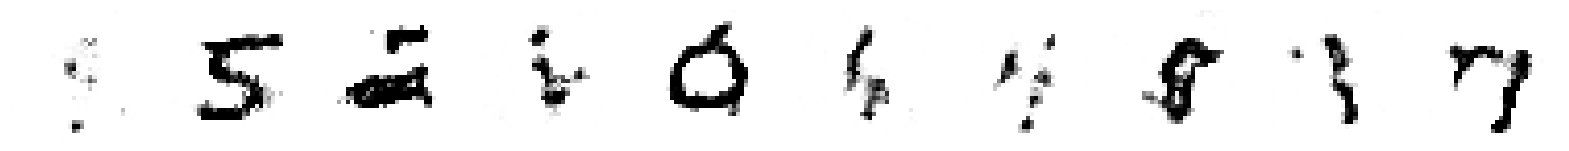

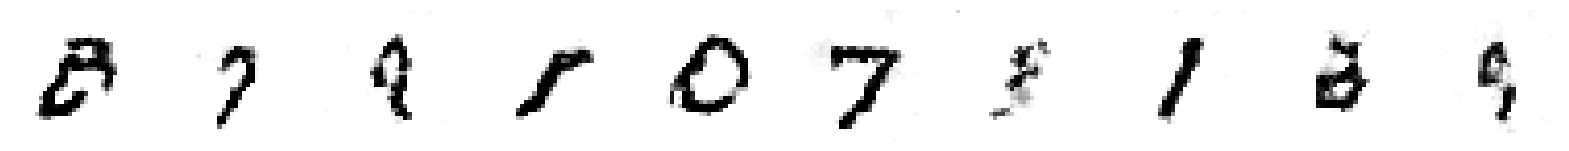

469/469 ━━━━━━━━━━━━━━━━━━━━ 327s 698ms/step - cdiv: -7.9344e-04 - fake: 3.4046e-04 - loss: -5.4009e-04 - real: 0.0011 - reg: 2.5335e-04 - val_cdiv: -22.6867 - val_fake: -22.6712 - val_real: 0.0155
Epoch 41/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - cdiv: -5.0066e-04 - fake: 2.7262e-04 - loss: -2.9411e-04 - real: 7.7328e-04 - reg: 2.0656e-04

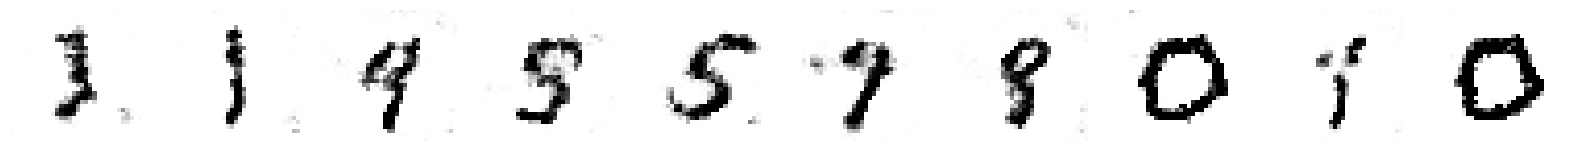

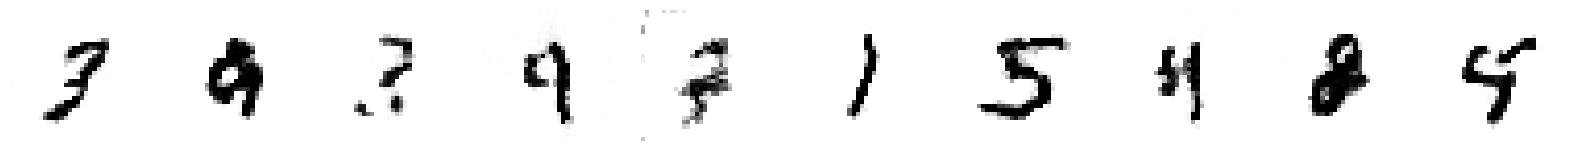

469/469 ━━━━━━━━━━━━━━━━━━━━ 327s 697ms/step - cdiv: -5.0049e-04 - fake: 2.7170e-04 - loss: -2.9393e-04 - real: 7.7219e-04 - reg: 2.0656e-04 - val_cdiv: -23.0006 - val_fake: -22.9886 - val_real: 0.0120
Epoch 42/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - cdiv: -6.7475e-04 - fake: 6.4058e-04 - loss: -3.9809e-04 - real: 0.0013 - reg: 2.7666e-04

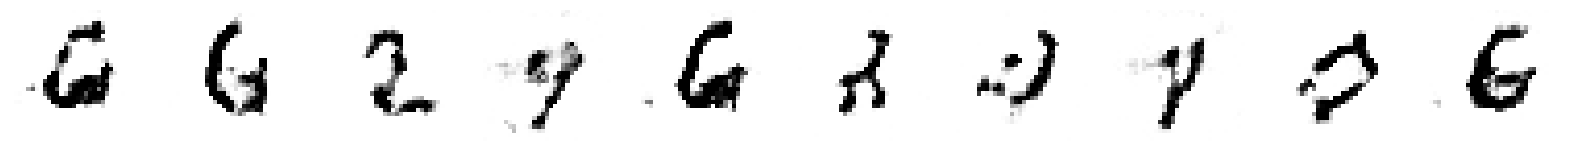

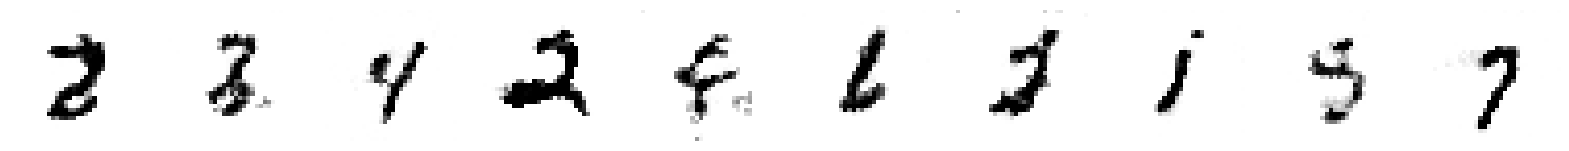

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 693ms/step - cdiv: -6.7390e-04 - fake: 6.3967e-04 - loss: -3.9733e-04 - real: 0.0013 - reg: 2.7657e-04 - val_cdiv: -23.2663 - val_fake: -23.2515 - val_real: 0.0149
Epoch 43/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - cdiv: -6.4507e-04 - fake: -1.2614e-05 - loss: -3.7327e-04 - real: 6.3245e-04 - reg: 2.7180e-04

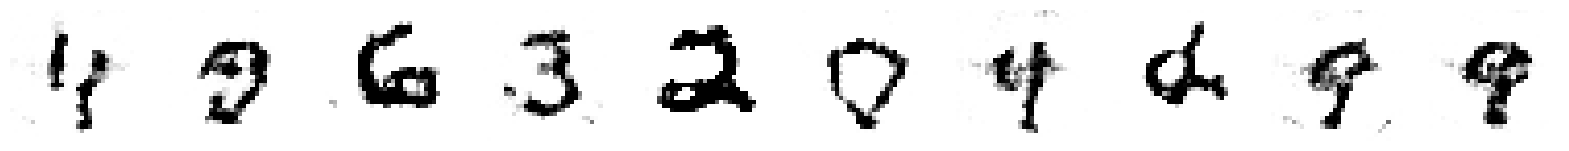

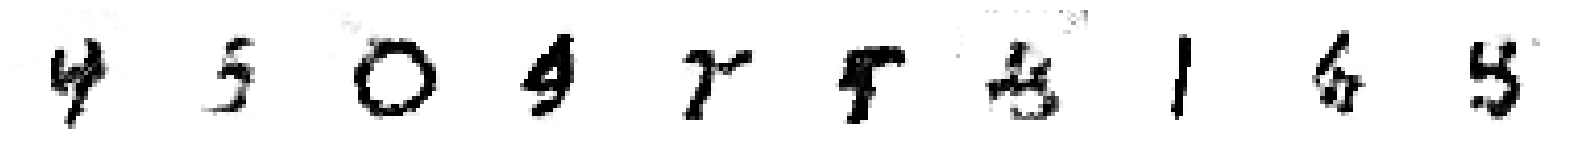

469/469 ━━━━━━━━━━━━━━━━━━━━ 324s 690ms/step - cdiv: -6.4383e-04 - fake: -1.2921e-05 - loss: -3.7214e-04 - real: 6.3091e-04 - reg: 2.7169e-04 - val_cdiv: -23.6136 - val_fake: -23.5970 - val_real: 0.0166
Epoch 44/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - cdiv: -2.9565e-04 - fake: 9.0215e-04 - loss: -7.2750e-05 - real: 0.0012 - reg: 2.2290e-04

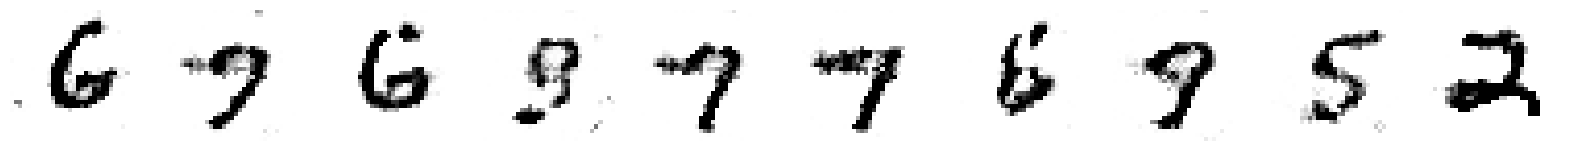

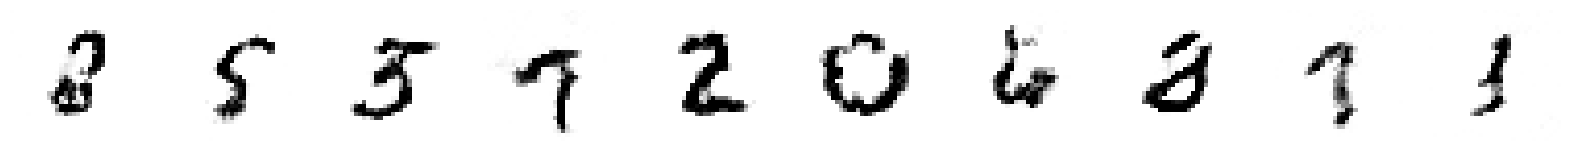

469/469 ━━━━━━━━━━━━━━━━━━━━ 324s 691ms/step - cdiv: -2.9556e-04 - fake: 9.0091e-04 - loss: -7.2681e-05 - real: 0.0012 - reg: 2.2288e-04 - val_cdiv: -23.8410 - val_fake: -23.8293 - val_real: 0.0117
Epoch 45/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - cdiv: -0.0010 - fake: -6.4975e-04 - loss: -6.8320e-04 - real: 3.5639e-04 - reg: 3.2294e-04

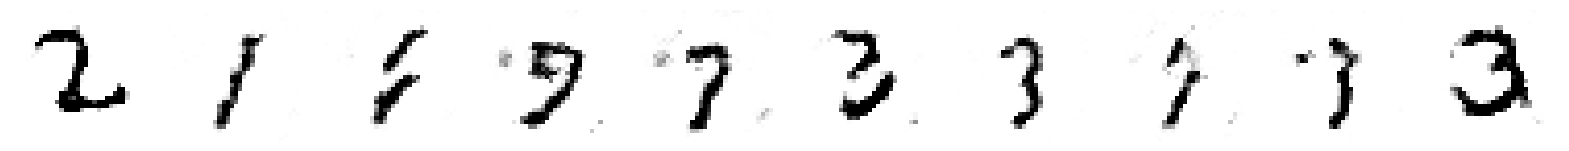

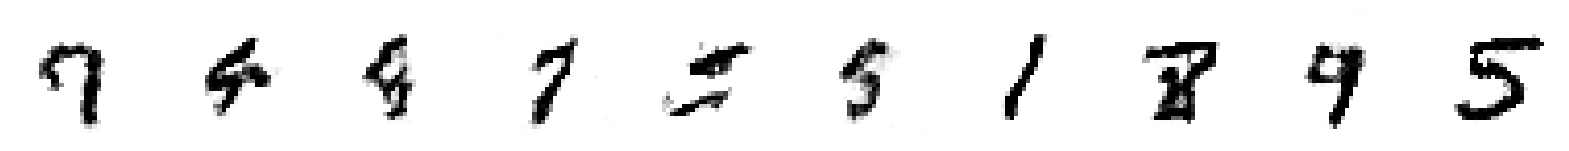

469/469 ━━━━━━━━━━━━━━━━━━━━ 329s 701ms/step - cdiv: -0.0010 - fake: -6.4889e-04 - loss: -6.8196e-04 - real: 3.5585e-04 - reg: 3.2278e-04 - val_cdiv: -24.2679 - val_fake: -24.2492 - val_real: 0.0187
Epoch 46/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - cdiv: -8.2703e-04 - fake: 6.6533e-04 - loss: -5.6259e-04 - real: 0.0015 - reg: 2.6444e-04

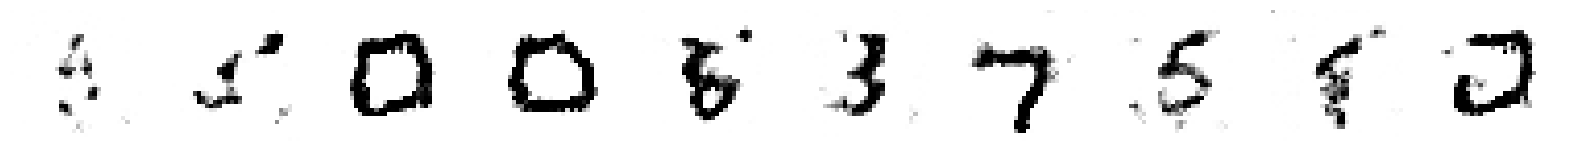

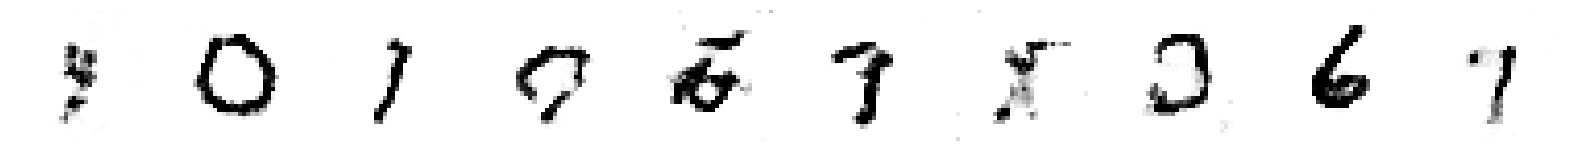

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 694ms/step - cdiv: -8.2621e-04 - fake: 6.6397e-04 - loss: -5.6185e-04 - real: 0.0015 - reg: 2.6436e-04 - val_cdiv: -24.5879 - val_fake: -24.5744 - val_real: 0.0135
Epoch 47/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - cdiv: -7.3283e-04 - fake: -8.0557e-05 - loss: -4.7444e-04 - real: 6.5228e-04 - reg: 2.5839e-04

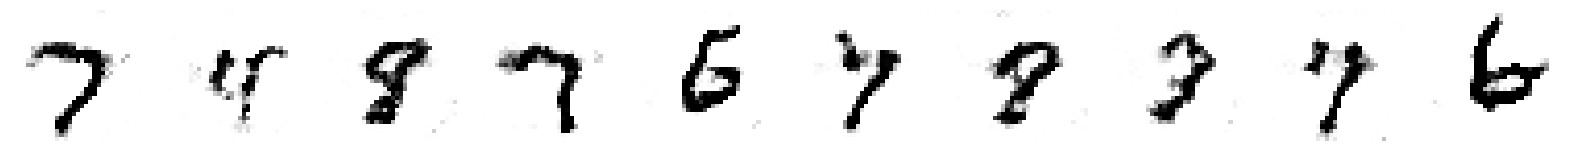

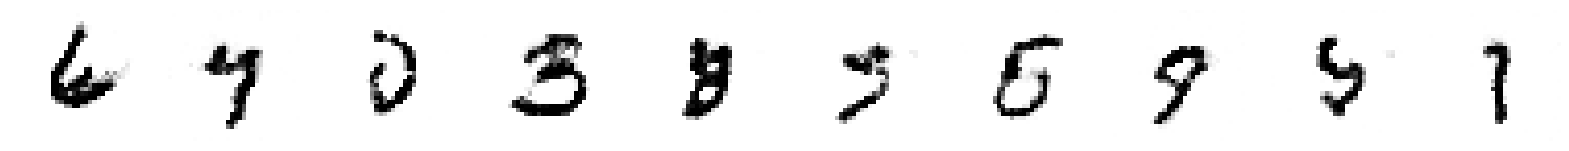

469/469 ━━━━━━━━━━━━━━━━━━━━ 326s 694ms/step - cdiv: -7.3186e-04 - fake: -8.1209e-05 - loss: -4.7354e-04 - real: 6.5066e-04 - reg: 2.5832e-04 - val_cdiv: -24.7542 - val_fake: -24.7351 - val_real: 0.0191
Epoch 48/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - cdiv: -7.4799e-04 - fake: 0.0016 - loss: -4.2582e-04 - real: 0.0023 - reg: 3.2216e-04

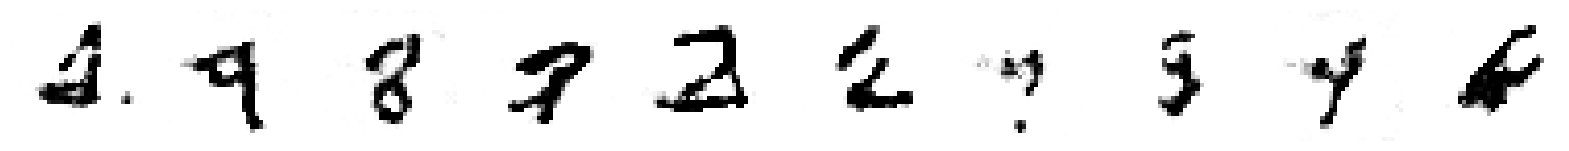

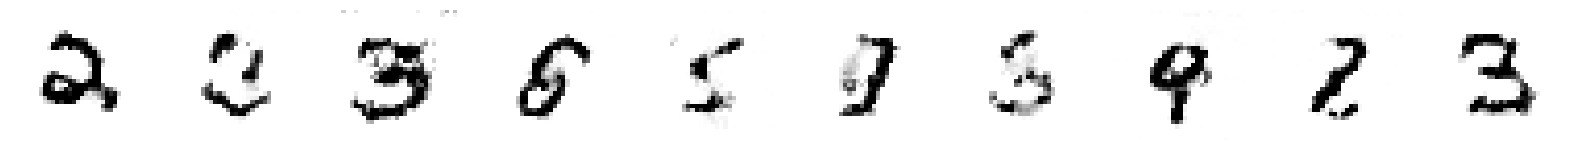

469/469 ━━━━━━━━━━━━━━━━━━━━ 329s 701ms/step - cdiv: -7.4664e-04 - fake: 0.0015 - loss: -4.2462e-04 - real: 0.0023 - reg: 3.2201e-04 - val_cdiv: -24.8256 - val_fake: -24.8119 - val_real: 0.0137
Epoch 49/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - cdiv: -7.8276e-04 - fake: 8.8012e-04 - loss: -4.7838e-04 - real: 0.0017 - reg: 3.0438e-04

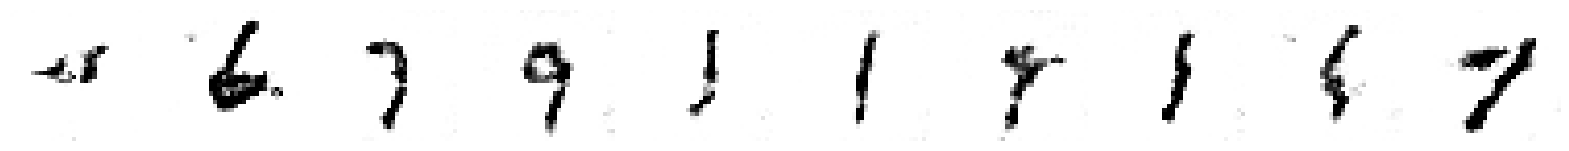

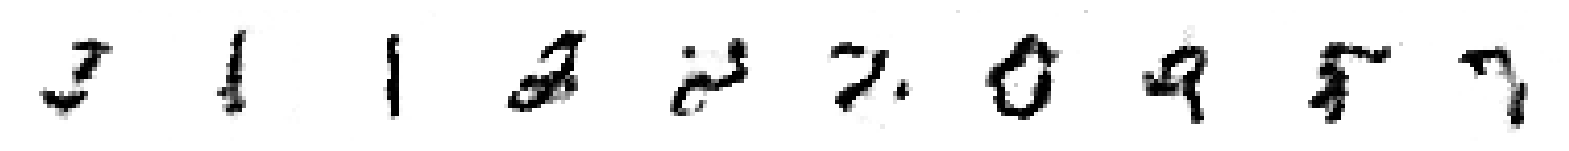

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 694ms/step - cdiv: -7.8180e-04 - fake: 8.7862e-04 - loss: -4.7752e-04 - real: 0.0017 - reg: 3.0428e-04 - val_cdiv: -25.1586 - val_fake: -25.1436 - val_real: 0.0150
Epoch 50/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - cdiv: -6.5746e-04 - fake: 1.3448e-04 - loss: -3.3177e-04 - real: 7.9193e-04 - reg: 3.2569e-04

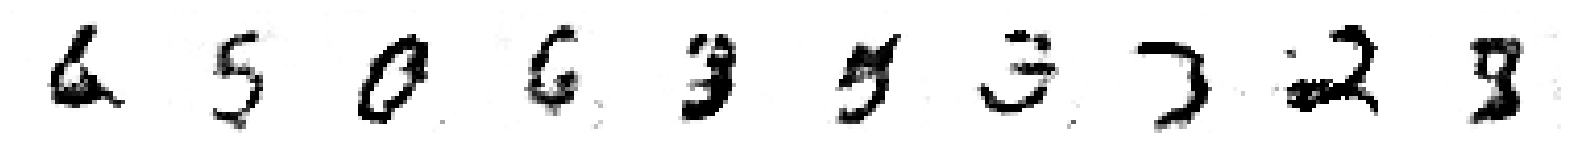

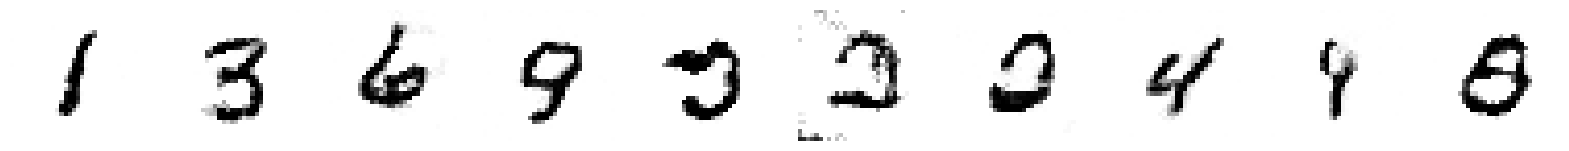

469/469 ━━━━━━━━━━━━━━━━━━━━ 319s 681ms/step - cdiv: -6.5581e-04 - fake: 1.3342e-04 - loss: -3.3029e-04 - real: 7.8922e-04 - reg: 3.2552e-04 - val_cdiv: -25.4092 - val_fake: -25.4004 - val_real: 0.0088
Epoch 51/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - cdiv: -6.8013e-05 - fake: 3.9942e-04 - loss: 1.0614e-04 - real: 4.6744e-04 - reg: 1.7416e-04

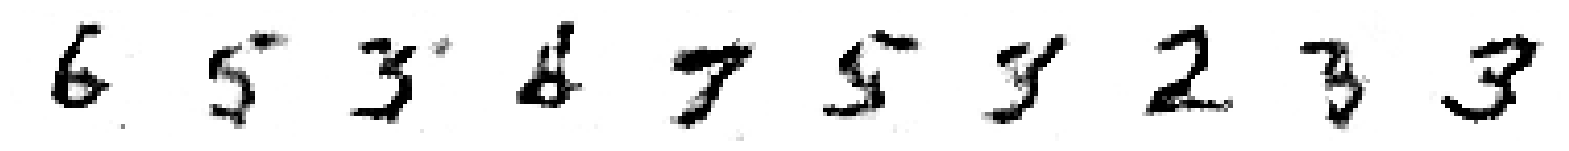

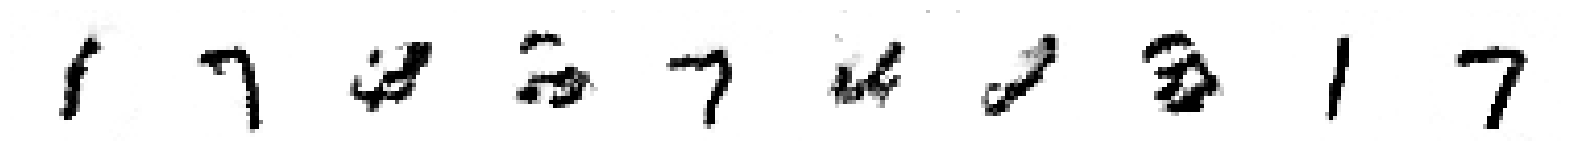

469/469 ━━━━━━━━━━━━━━━━━━━━ 322s 686ms/step - cdiv: -6.8344e-05 - fake: 3.9937e-04 - loss: 1.0586e-04 - real: 4.6771e-04 - reg: 1.7420e-04 - val_cdiv: -25.6088 - val_fake: -25.6002 - val_real: 0.0087
Epoch 52/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - cdiv: -7.8525e-04 - fake: -2.7211e-05 - loss: -5.1995e-04 - real: 7.5803e-04 - reg: 2.6529e-04

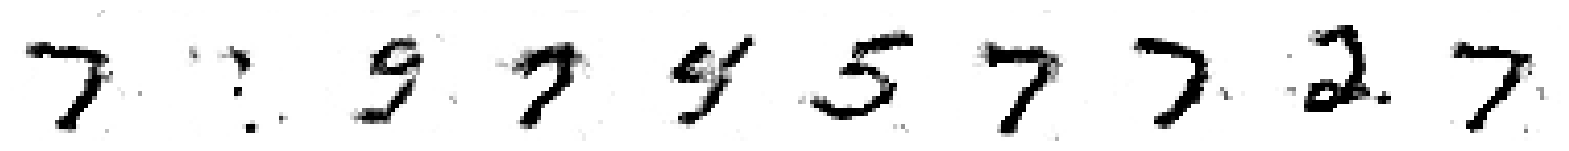

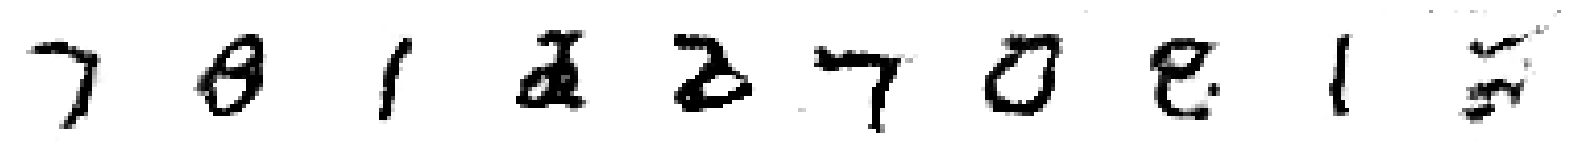

469/469 ━━━━━━━━━━━━━━━━━━━━ 326s 696ms/step - cdiv: -7.8451e-04 - fake: -2.7589e-05 - loss: -5.1926e-04 - real: 7.5692e-04 - reg: 2.6524e-04 - val_cdiv: -25.9251 - val_fake: -25.9137 - val_real: 0.0114
Epoch 53/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - cdiv: -5.0614e-04 - fake: 9.6579e-06 - loss: -2.4543e-04 - real: 5.1580e-04 - reg: 2.6071e-04

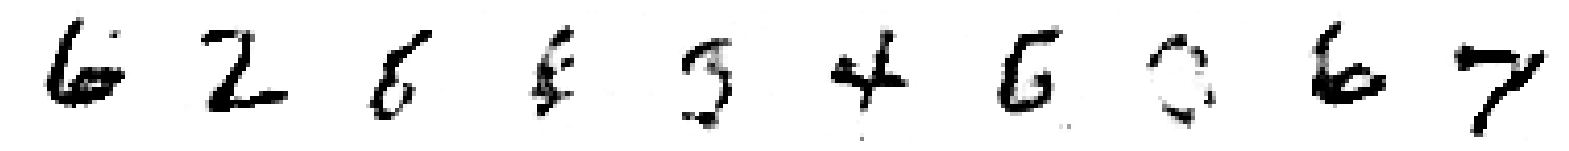

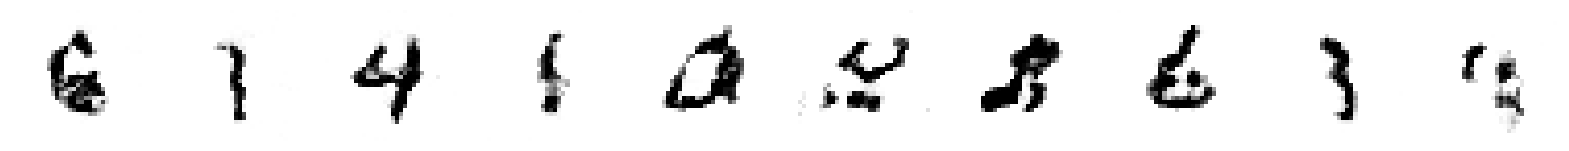

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 692ms/step - cdiv: -5.0536e-04 - fake: 8.8097e-06 - loss: -2.4470e-04 - real: 5.1417e-04 - reg: 2.6066e-04 - val_cdiv: -26.1149 - val_fake: -26.1045 - val_real: 0.0104
Epoch 54/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - cdiv: -6.6346e-04 - fake: 7.5846e-04 - loss: -4.0235e-04 - real: 0.0014 - reg: 2.6110e-04

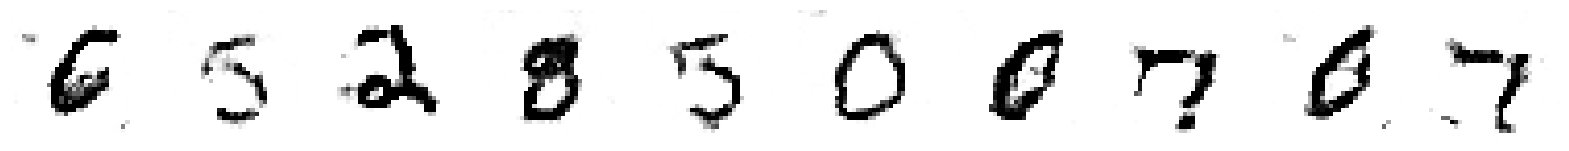

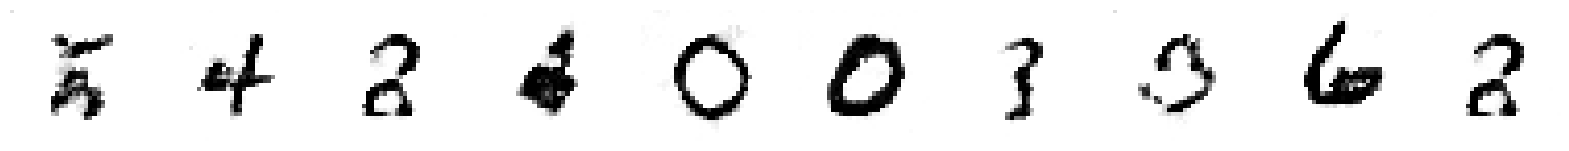

469/469 ━━━━━━━━━━━━━━━━━━━━ 323s 688ms/step - cdiv: -6.6264e-04 - fake: 7.5699e-04 - loss: -4.0160e-04 - real: 0.0014 - reg: 2.6105e-04 - val_cdiv: -26.2602 - val_fake: -26.2485 - val_real: 0.0116
Epoch 55/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - cdiv: -3.8810e-04 - fake: 6.1556e-04 - loss: -1.5639e-04 - real: 0.0010 - reg: 2.3171e-04

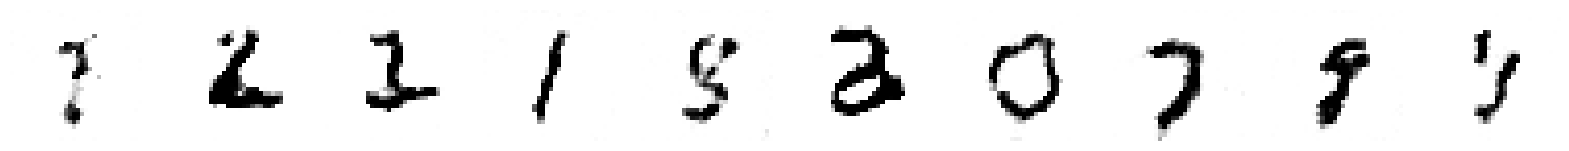

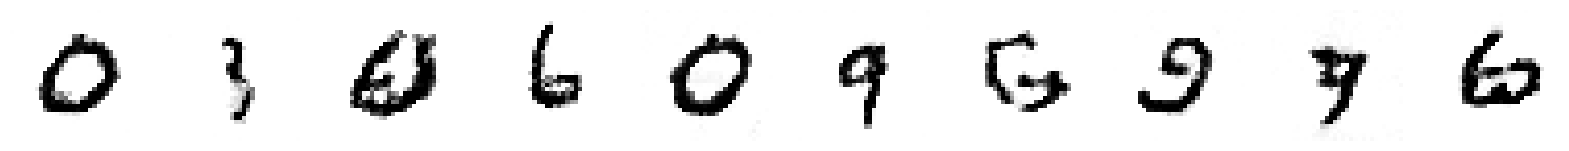

469/469 ━━━━━━━━━━━━━━━━━━━━ 328s 699ms/step - cdiv: -3.8758e-04 - fake: 6.1458e-04 - loss: -1.5593e-04 - real: 0.0010 - reg: 2.3166e-04 - val_cdiv: -26.4896 - val_fake: -26.4867 - val_real: 0.0029
Epoch 56/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - cdiv: -4.5725e-04 - fake: -2.1224e-04 - loss: -2.2465e-04 - real: 2.4501e-04 - reg: 2.3260e-04

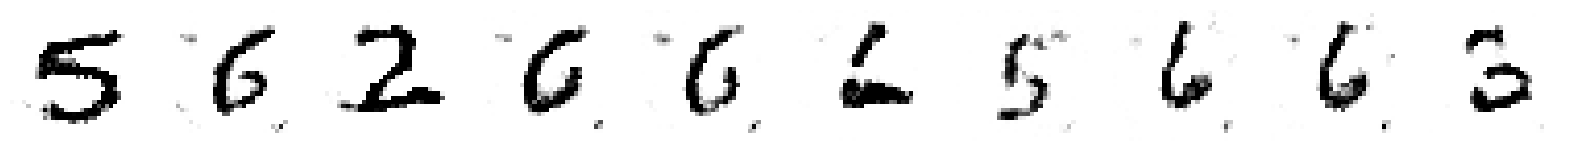

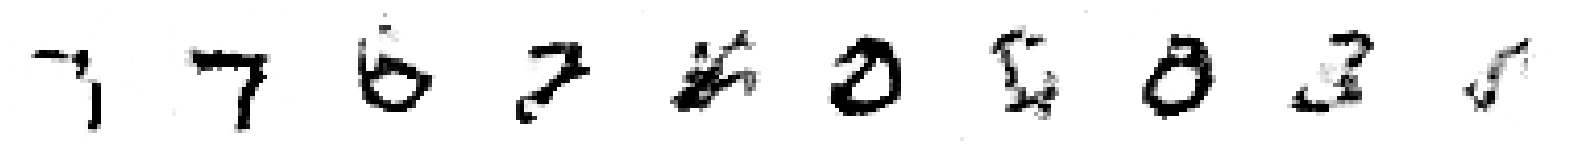

469/469 ━━━━━━━━━━━━━━━━━━━━ 321s 684ms/step - cdiv: -4.5641e-04 - fake: -2.1224e-04 - loss: -2.2383e-04 - real: 2.4417e-04 - reg: 2.3258e-04 - val_cdiv: -26.5227 - val_fake: -26.5127 - val_real: 0.0100
Epoch 57/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - cdiv: -1.8850e-04 - fake: 8.7969e-04 - loss: 4.0296e-05 - real: 0.0011 - reg: 2.2880e-04

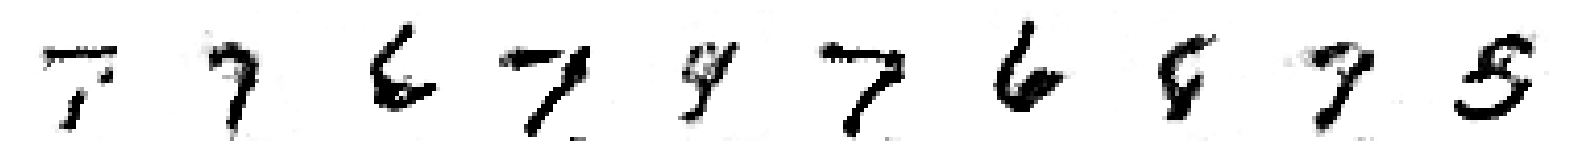

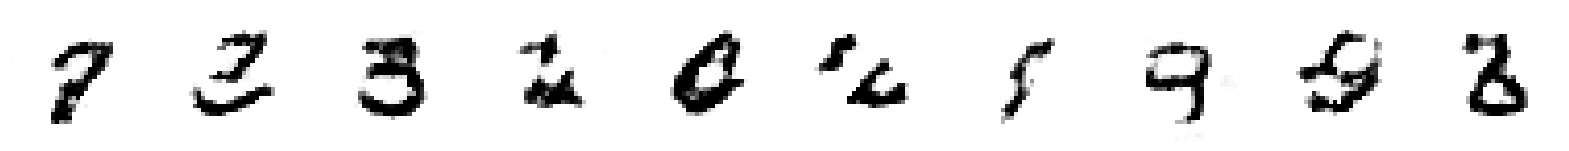

469/469 ━━━━━━━━━━━━━━━━━━━━ 323s 688ms/step - cdiv: -1.8857e-04 - fake: 8.7786e-04 - loss: 4.0262e-05 - real: 0.0011 - reg: 2.2883e-04 - val_cdiv: -26.6707 - val_fake: -26.6649 - val_real: 0.0058
Epoch 58/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - cdiv: -8.1491e-04 - fake: -2.7779e-04 - loss: -5.5138e-04 - real: 5.3711e-04 - reg: 2.6353e-04

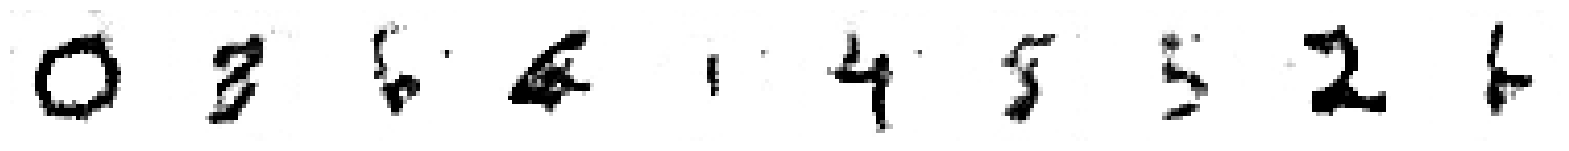

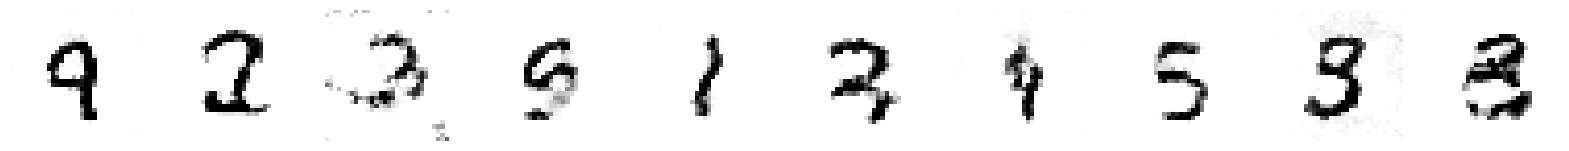

469/469 ━━━━━━━━━━━━━━━━━━━━ 324s 690ms/step - cdiv: -8.1353e-04 - fake: -2.7760e-04 - loss: -5.5005e-04 - real: 5.3593e-04 - reg: 2.6348e-04 - val_cdiv: -26.9444 - val_fake: -26.9337 - val_real: 0.0108
Epoch 59/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - cdiv: -5.7806e-04 - fake: 4.7678e-04 - loss: -3.1988e-04 - real: 0.0011 - reg: 2.5818e-04

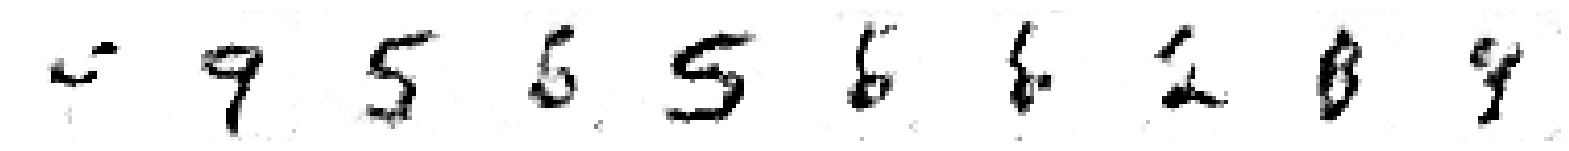

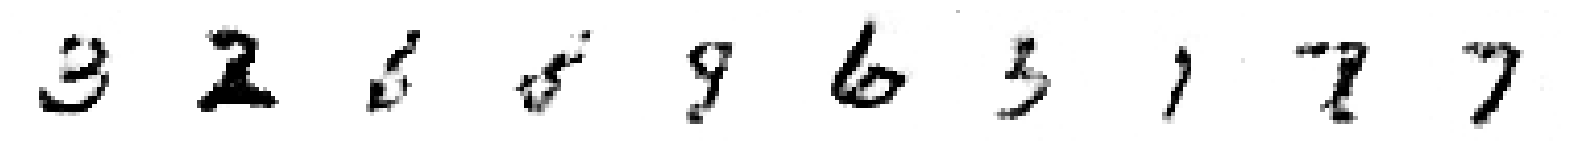

469/469 ━━━━━━━━━━━━━━━━━━━━ 323s 689ms/step - cdiv: -5.7735e-04 - fake: 4.7576e-04 - loss: -3.1922e-04 - real: 0.0011 - reg: 2.5813e-04 - val_cdiv: -27.1418 - val_fake: -27.1366 - val_real: 0.0052
Epoch 60/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - cdiv: -2.3018e-04 - fake: 3.2549e-04 - loss: -3.4131e-07 - real: 5.5567e-04 - reg: 2.2984e-04

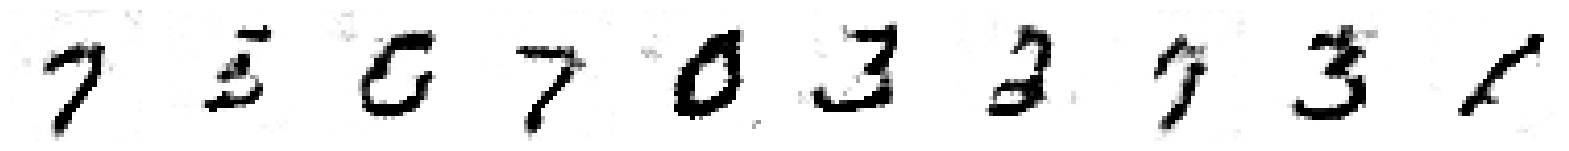

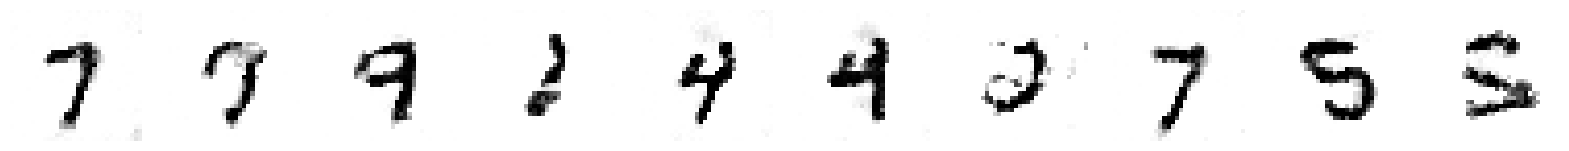

469/469 ━━━━━━━━━━━━━━━━━━━━ 323s 689ms/step - cdiv: -2.2951e-04 - fake: 3.2489e-04 - loss: 2.9079e-07 - real: 5.5440e-04 - reg: 2.2980e-04 - val_cdiv: -27.1374 - val_fake: -27.1324 - val_real: 0.0050
Epoch 61/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - cdiv: -2.9274e-04 - fake: 3.7170e-04 - loss: -1.1332e-04 - real: 6.6444e-04 - reg: 1.7942e-04

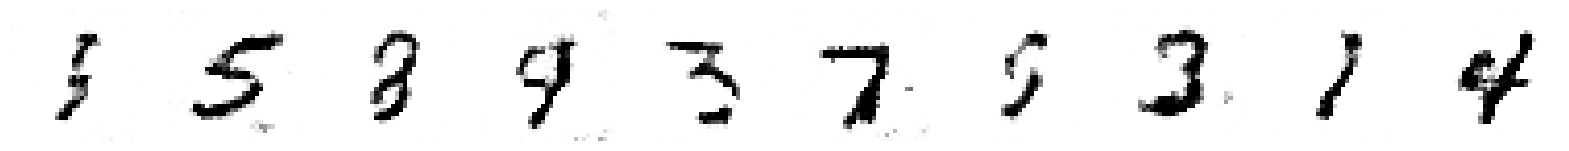

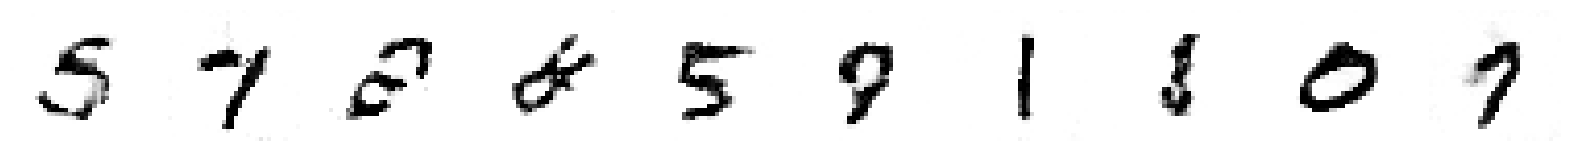

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 693ms/step - cdiv: -2.9231e-04 - fake: 3.7117e-04 - loss: -1.1285e-04 - real: 6.6348e-04 - reg: 1.7946e-04 - val_cdiv: -26.8906 - val_fake: -26.8804 - val_real: 0.0102
Epoch 62/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - cdiv: -5.2270e-04 - fake: 6.3613e-04 - loss: -2.5094e-04 - real: 0.0012 - reg: 2.7176e-04

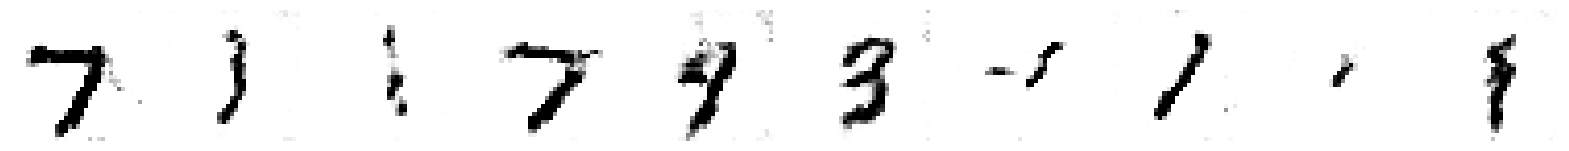

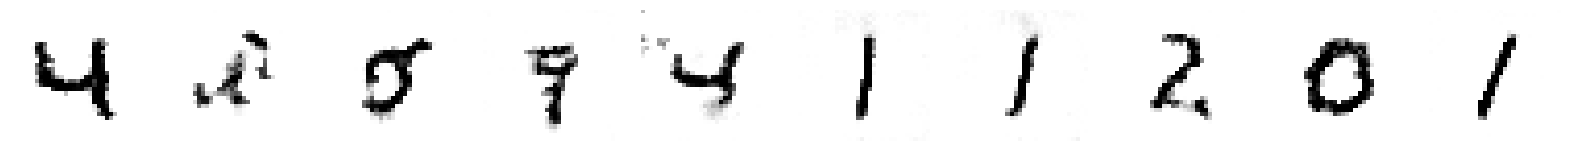

469/469 ━━━━━━━━━━━━━━━━━━━━ 322s 687ms/step - cdiv: -5.2209e-04 - fake: 6.3500e-04 - loss: -2.5042e-04 - real: 0.0012 - reg: 2.7168e-04 - val_cdiv: -27.0977 - val_fake: -27.0908 - val_real: 0.0069
Epoch 63/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - cdiv: -1.5881e-04 - fake: 1.8818e-05 - loss: 8.8843e-05 - real: 1.7763e-04 - reg: 2.4765e-04

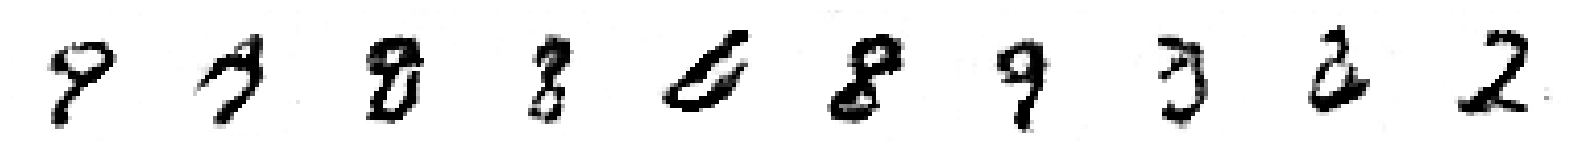

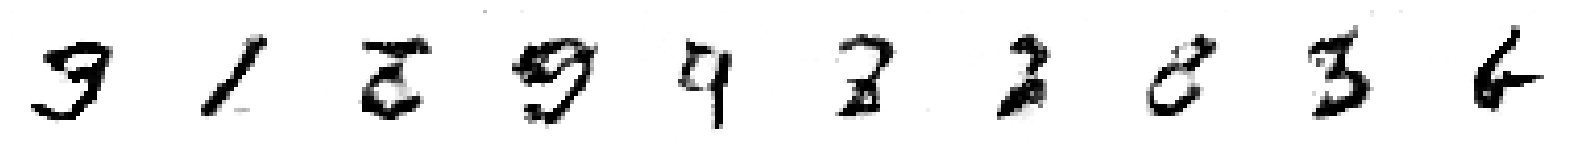

469/469 ━━━━━━━━━━━━━━━━━━━━ 321s 685ms/step - cdiv: -1.5809e-04 - fake: 1.8630e-05 - loss: 8.9454e-05 - real: 1.7672e-04 - reg: 2.4754e-04 - val_cdiv: -26.9894 - val_fake: -26.9836 - val_real: 0.0058
Epoch 64/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - cdiv: -2.7421e-04 - fake: 6.1166e-04 - loss: -8.5175e-05 - real: 8.8587e-04 - reg: 1.8904e-04

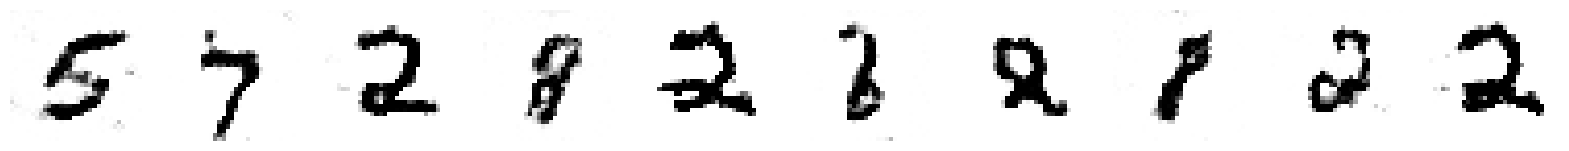

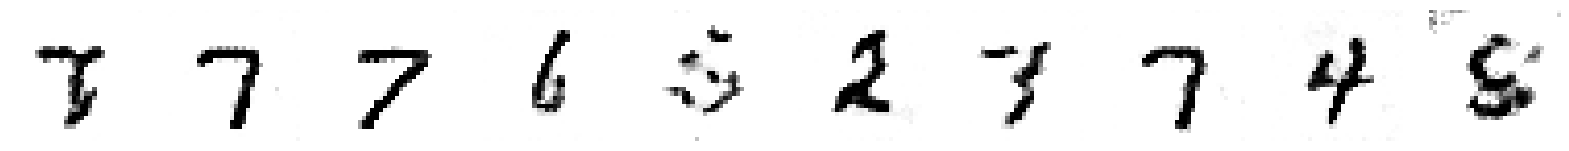

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 694ms/step - cdiv: -2.7397e-04 - fake: 6.1066e-04 - loss: -8.4923e-05 - real: 8.8463e-04 - reg: 1.8904e-04 - val_cdiv: -27.2351 - val_fake: -27.2289 - val_real: 0.0062
Epoch 65/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - cdiv: -7.6714e-04 - fake: -3.4841e-04 - loss: -5.3644e-04 - real: 4.1873e-04 - reg: 2.3071e-04

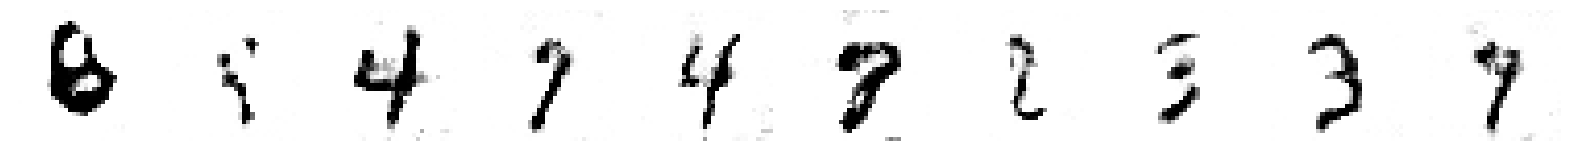

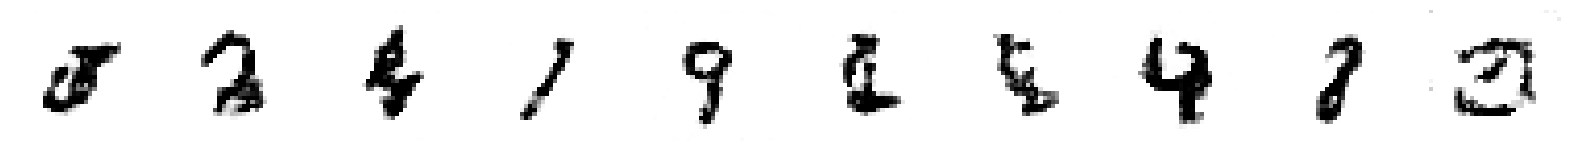

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 692ms/step - cdiv: -7.6684e-04 - fake: -3.4841e-04 - loss: -5.3611e-04 - real: 4.1843e-04 - reg: 2.3073e-04 - val_cdiv: -27.4558 - val_fake: -27.4408 - val_real: 0.0150
Epoch 66/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - cdiv: -6.0196e-04 - fake: 4.7911e-04 - loss: -3.2120e-04 - real: 0.0011 - reg: 2.8076e-04

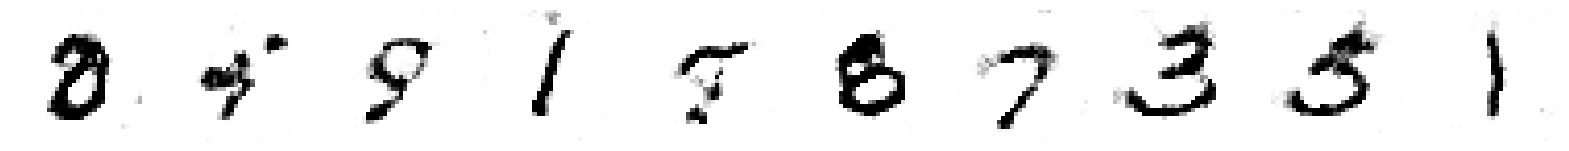

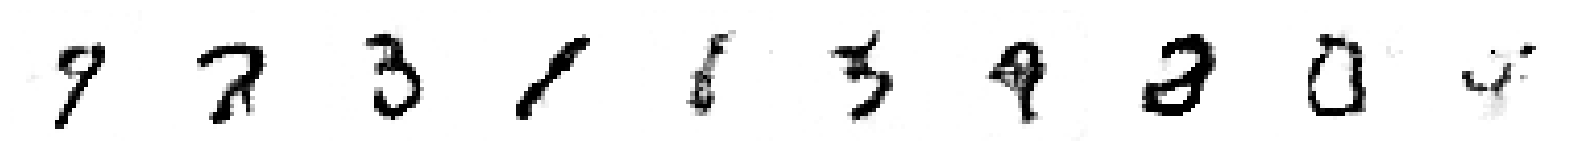

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 693ms/step - cdiv: -6.0131e-04 - fake: 4.7736e-04 - loss: -3.2059e-04 - real: 0.0011 - reg: 2.8072e-04 - val_cdiv: -27.6569 - val_fake: -27.6485 - val_real: 0.0084
Epoch 67/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - cdiv: -2.6246e-04 - fake: 5.0167e-04 - loss: -2.7275e-05 - real: 7.6413e-04 - reg: 2.3519e-04

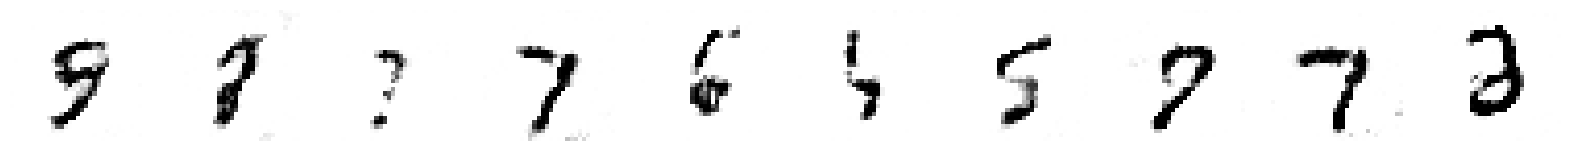

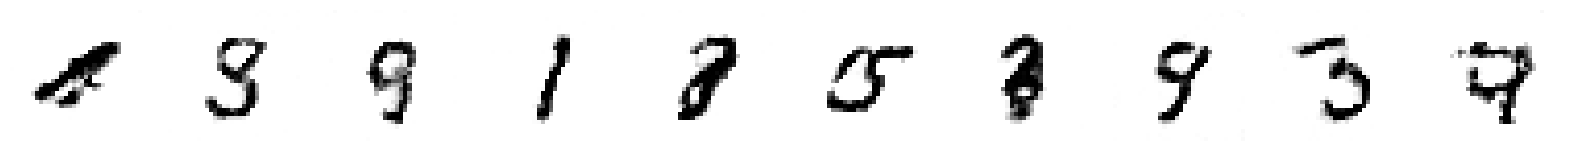

469/469 ━━━━━━━━━━━━━━━━━━━━ 327s 697ms/step - cdiv: -2.6218e-04 - fake: 5.0111e-04 - loss: -2.6940e-05 - real: 7.6329e-04 - reg: 2.3523e-04 - val_cdiv: -27.4387 - val_fake: -27.4337 - val_real: 0.0050
Epoch 68/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - cdiv: -4.0054e-04 - fake: -9.8291e-05 - loss: -1.0750e-04 - real: 3.0225e-04 - reg: 2.9304e-04

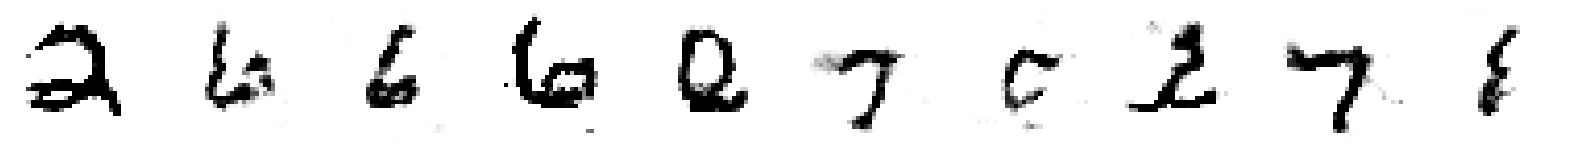

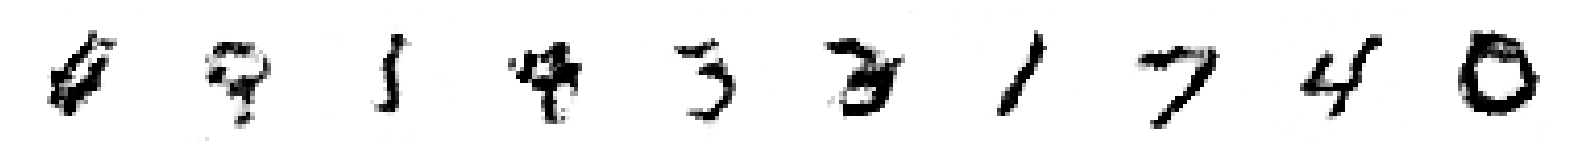

469/469 ━━━━━━━━━━━━━━━━━━━━ 326s 695ms/step - cdiv: -3.9981e-04 - fake: -9.8472e-05 - loss: -1.0685e-04 - real: 3.0133e-04 - reg: 2.9295e-04 - val_cdiv: -27.6120 - val_fake: -27.6062 - val_real: 0.0058
Epoch 69/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - cdiv: -0.0010 - fake: 3.5656e-04 - loss: -7.3121e-04 - real: 0.0014 - reg: 2.8894e-04

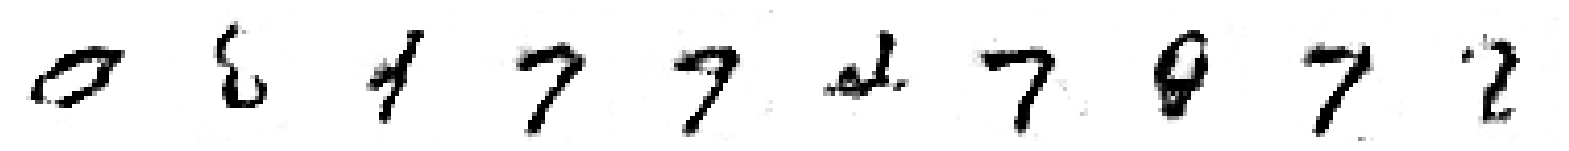

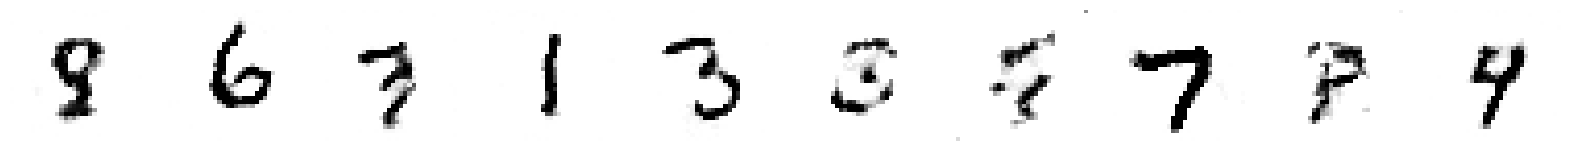

469/469 ━━━━━━━━━━━━━━━━━━━━ 335s 713ms/step - cdiv: -0.0010 - fake: 3.5601e-04 - loss: -7.2975e-04 - real: 0.0014 - reg: 2.8892e-04 - val_cdiv: -27.6057 - val_fake: -27.5963 - val_real: 0.0095
Epoch 70/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - cdiv: -7.2436e-04 - fake: 7.3620e-05 - loss: -4.7517e-04 - real: 7.9798e-04 - reg: 2.4919e-04

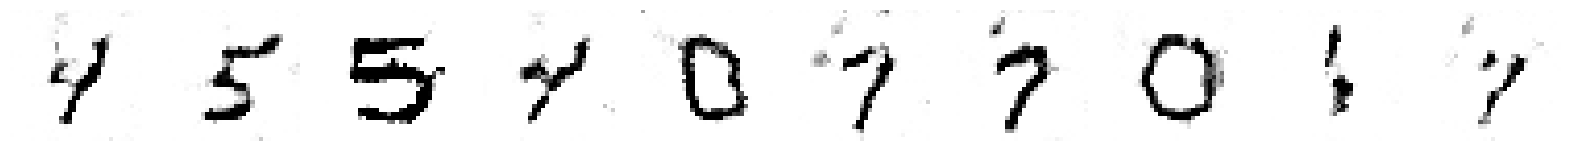

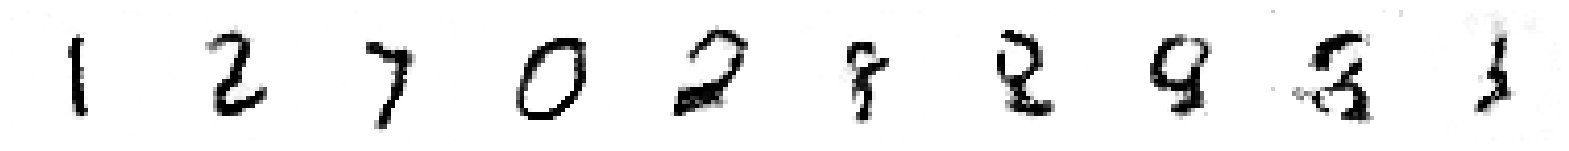

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 692ms/step - cdiv: -7.2347e-04 - fake: 7.3325e-05 - loss: -4.7433e-04 - real: 7.9679e-04 - reg: 2.4914e-04 - val_cdiv: -28.2476 - val_fake: -28.2354 - val_real: 0.0121
Epoch 71/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - cdiv: -4.7895e-04 - fake: 2.1509e-04 - loss: -2.2093e-04 - real: 6.9404e-04 - reg: 2.5803e-04

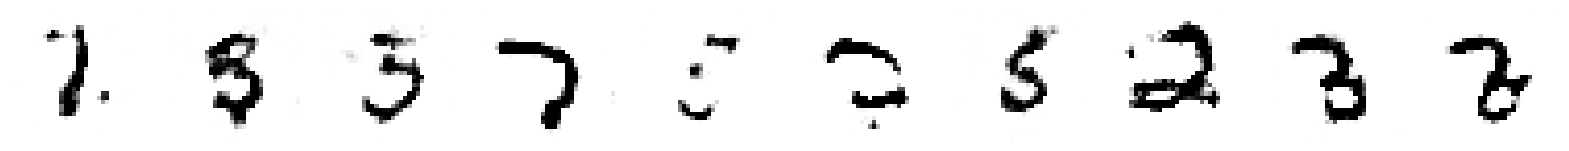

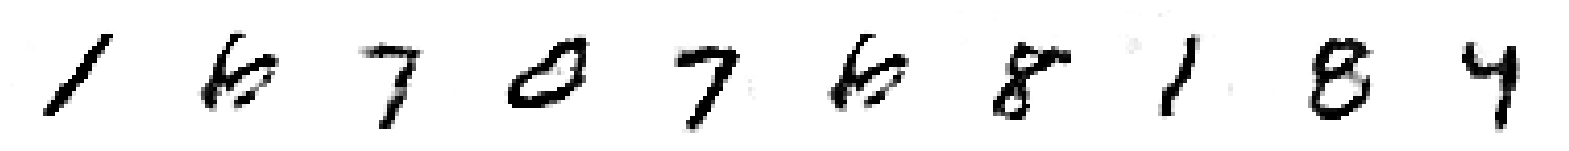

469/469 ━━━━━━━━━━━━━━━━━━━━ 328s 700ms/step - cdiv: -4.7815e-04 - fake: 2.1447e-04 - loss: -2.2020e-04 - real: 6.9262e-04 - reg: 2.5795e-04 - val_cdiv: -28.1252 - val_fake: -28.1177 - val_real: 0.0075
Epoch 72/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - cdiv: -3.0227e-04 - fake: 3.3143e-04 - loss: -6.2582e-05 - real: 6.3369e-04 - reg: 2.3969e-04

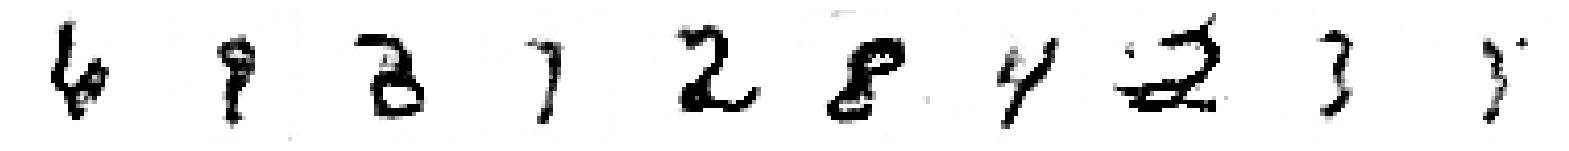

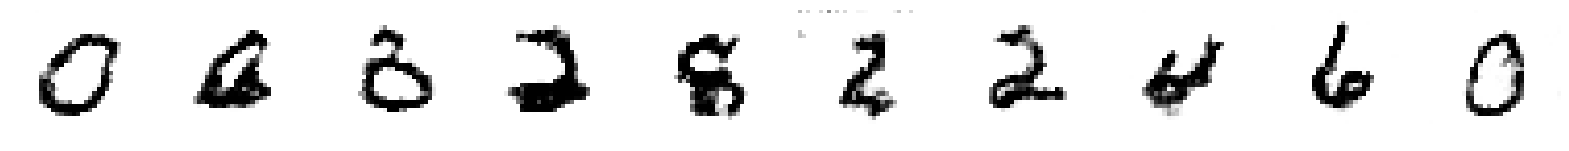

469/469 ━━━━━━━━━━━━━━━━━━━━ 328s 699ms/step - cdiv: -3.0217e-04 - fake: 3.3026e-04 - loss: -6.2497e-05 - real: 6.3243e-04 - reg: 2.3968e-04 - val_cdiv: -28.1468 - val_fake: -28.1381 - val_real: 0.0086
Epoch 73/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - cdiv: -8.7823e-04 - fake: -8.6124e-05 - loss: -5.6896e-04 - real: 7.9211e-04 - reg: 3.0928e-04

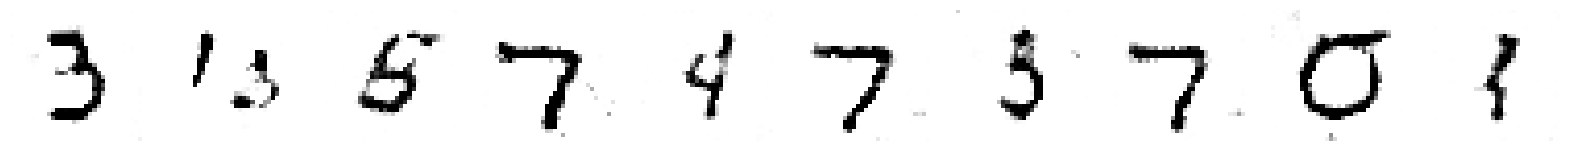

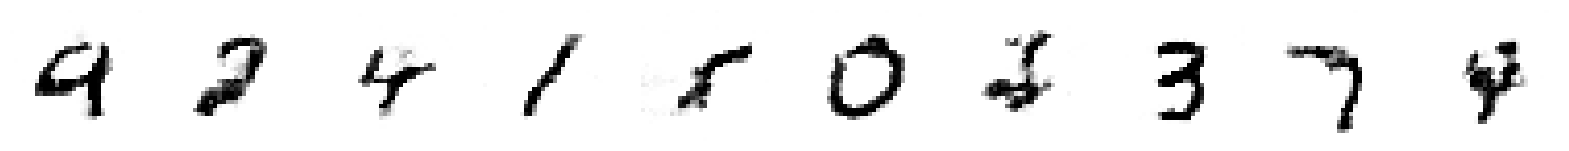

469/469 ━━━━━━━━━━━━━━━━━━━━ 330s 704ms/step - cdiv: -8.7754e-04 - fake: -8.6145e-05 - loss: -5.6829e-04 - real: 7.9139e-04 - reg: 3.0925e-04 - val_cdiv: -28.9376 - val_fake: -28.9309 - val_real: 0.0067
Epoch 74/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - cdiv: -3.2709e-04 - fake: -2.9877e-05 - loss: -9.0762e-05 - real: 2.9721e-04 - reg: 2.3633e-04

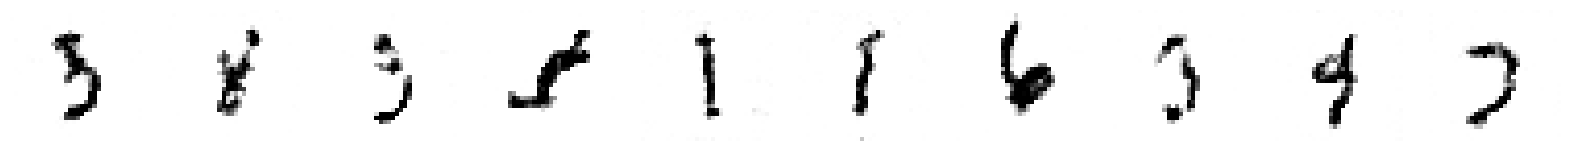

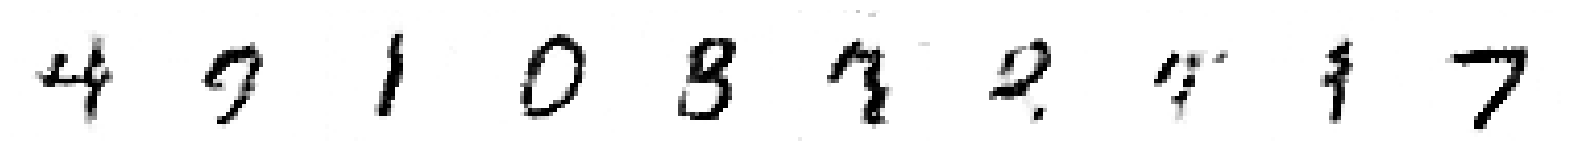

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 693ms/step - cdiv: -3.2626e-04 - fake: -2.9502e-05 - loss: -8.9997e-05 - real: 2.9676e-04 - reg: 2.3626e-04 - val_cdiv: -29.0280 - val_fake: -29.0228 - val_real: 0.0052
Epoch 75/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - cdiv: -4.8835e-04 - fake: -9.2783e-05 - loss: -2.7180e-04 - real: 3.9557e-04 - reg: 2.1655e-04

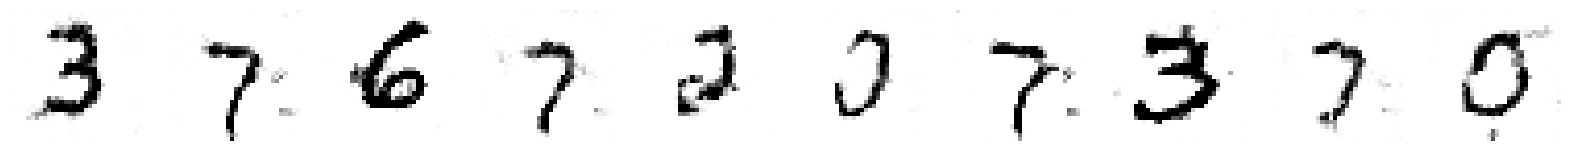

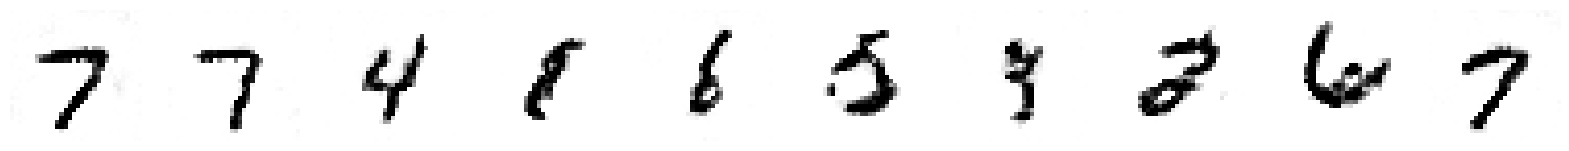

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 693ms/step - cdiv: -4.8757e-04 - fake: -9.2347e-05 - loss: -2.7104e-04 - real: 3.9522e-04 - reg: 2.1653e-04 - val_cdiv: -29.4292 - val_fake: -29.4222 - val_real: 0.0070
Epoch 76/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - cdiv: -2.6218e-04 - fake: -6.3331e-04 - loss: -7.7432e-05 - real: -3.7112e-04 - reg: 1.8475e-04

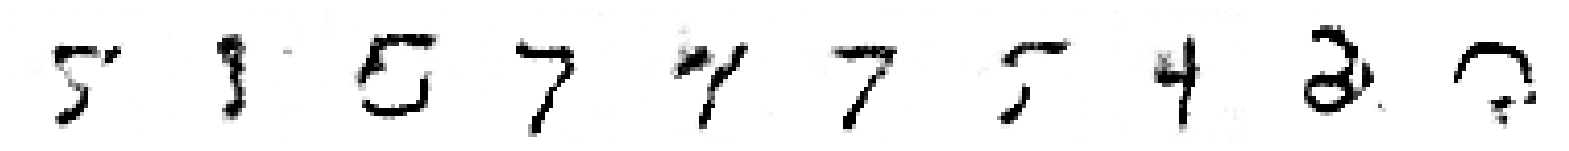

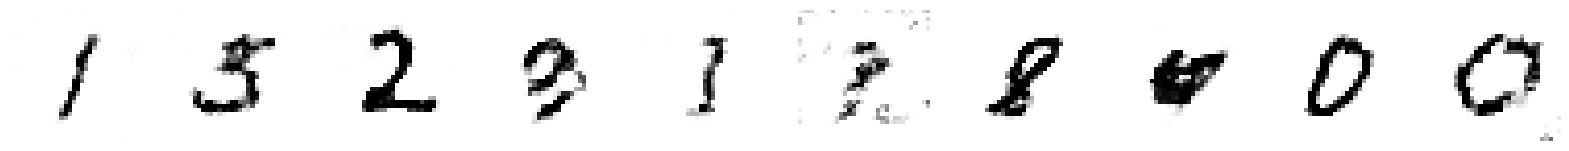

469/469 ━━━━━━━━━━━━━━━━━━━━ 329s 700ms/step - cdiv: -2.6204e-04 - fake: -6.3170e-04 - loss: -7.7280e-05 - real: -3.6966e-04 - reg: 1.8476e-04 - val_cdiv: -29.7217 - val_fake: -29.7137 - val_real: 0.0080
Epoch 77/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - cdiv: -4.2284e-04 - fake: 5.3185e-04 - loss: -1.8164e-04 - real: 9.5468e-04 - reg: 2.4120e-04

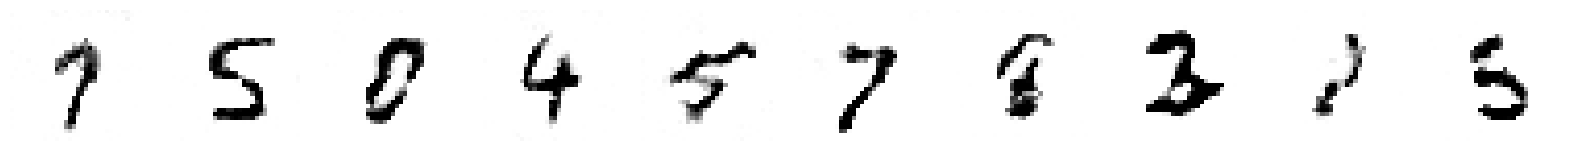

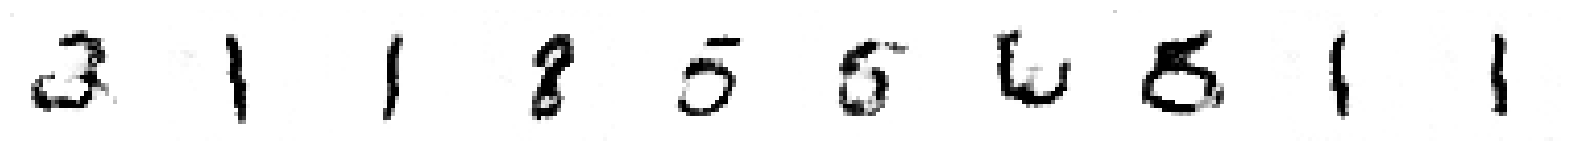

469/469 ━━━━━━━━━━━━━━━━━━━━ 327s 697ms/step - cdiv: -4.2251e-04 - fake: 5.3103e-04 - loss: -1.8133e-04 - real: 9.5354e-04 - reg: 2.4118e-04 - val_cdiv: -29.2950 - val_fake: -29.2917 - val_real: 0.0033
Epoch 78/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - cdiv: -3.9880e-04 - fake: -3.1131e-04 - loss: -1.3444e-04 - real: 8.7495e-05 - reg: 2.6436e-04

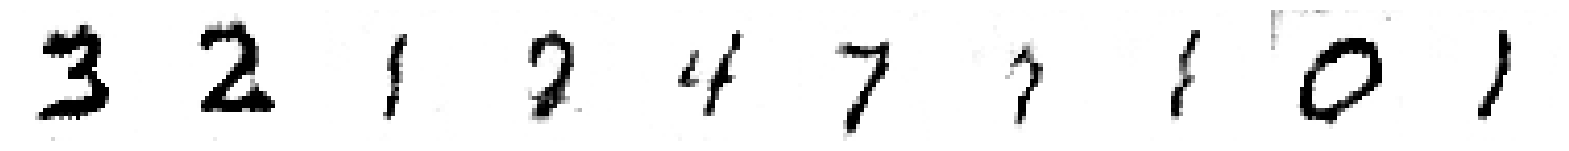

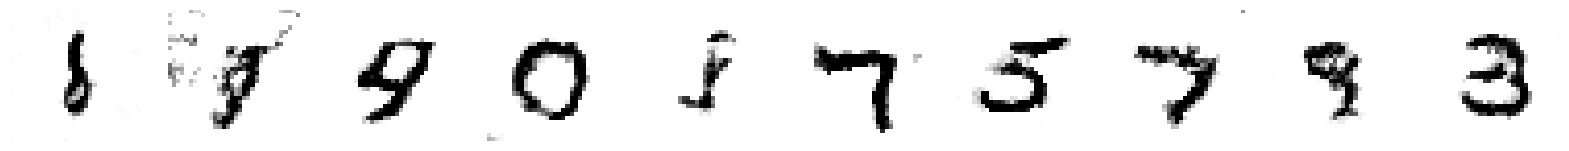

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 692ms/step - cdiv: -3.9833e-04 - fake: -3.1093e-04 - loss: -1.3400e-04 - real: 8.7402e-05 - reg: 2.6434e-04 - val_cdiv: -29.6027 - val_fake: -29.5958 - val_real: 0.0069
Epoch 79/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - cdiv: -4.1721e-04 - fake: -5.5501e-05 - loss: -1.8281e-04 - real: 3.6171e-04 - reg: 2.3440e-04

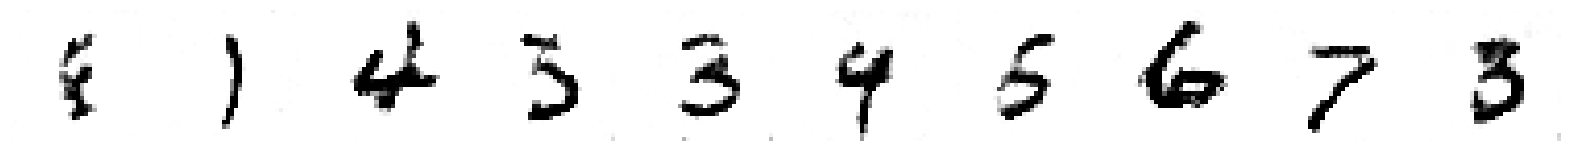

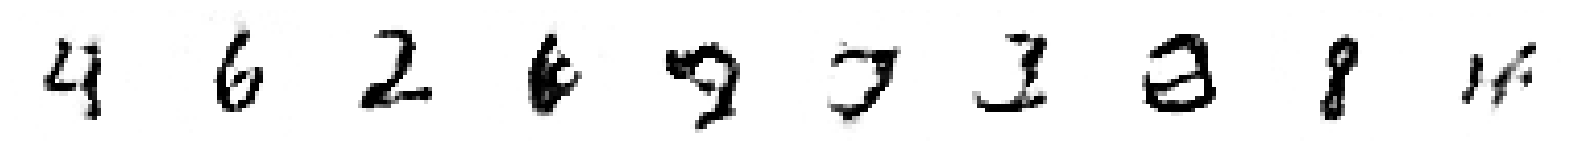

469/469 ━━━━━━━━━━━━━━━━━━━━ 326s 696ms/step - cdiv: -4.1638e-04 - fake: -5.5515e-05 - loss: -1.8203e-04 - real: 3.6086e-04 - reg: 2.3435e-04 - val_cdiv: -29.5399 - val_fake: -29.5316 - val_real: 0.0084
Epoch 80/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - cdiv: -6.2935e-04 - fake: 3.7175e-04 - loss: -3.5191e-04 - real: 0.0010 - reg: 2.7743e-04

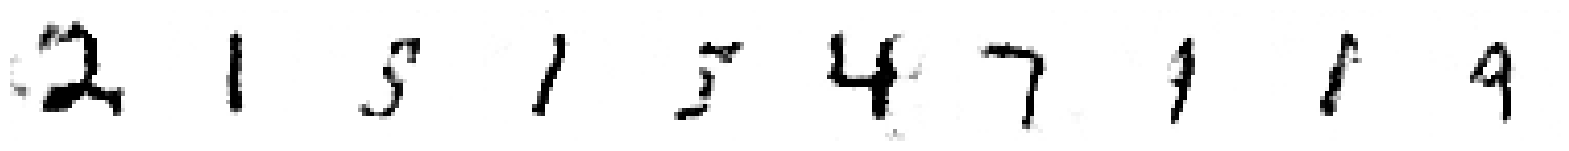

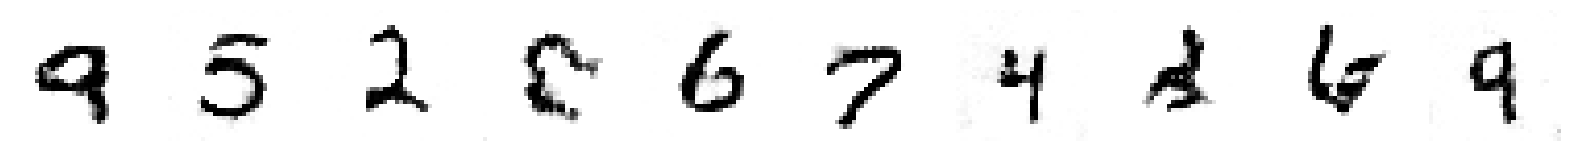

469/469 ━━━━━━━━━━━━━━━━━━━━ 329s 702ms/step - cdiv: -6.2869e-04 - fake: 3.7118e-04 - loss: -3.5120e-04 - real: 9.9987e-04 - reg: 2.7749e-04 - val_cdiv: -29.5954 - val_fake: -29.5887 - val_real: 0.0066
Epoch 81/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - cdiv: -1.6498e-04 - fake: 3.7752e-04 - loss: 8.9333e-05 - real: 5.4250e-04 - reg: 2.5431e-04

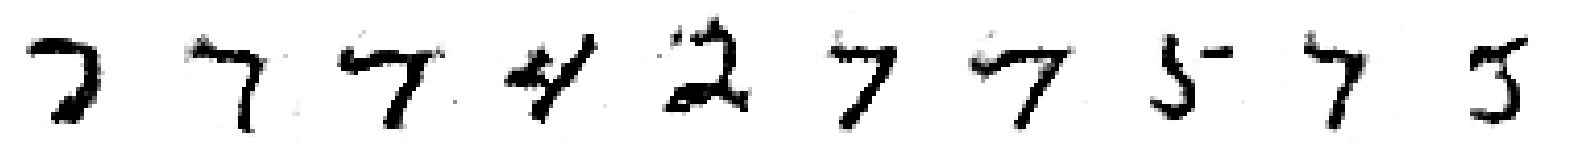

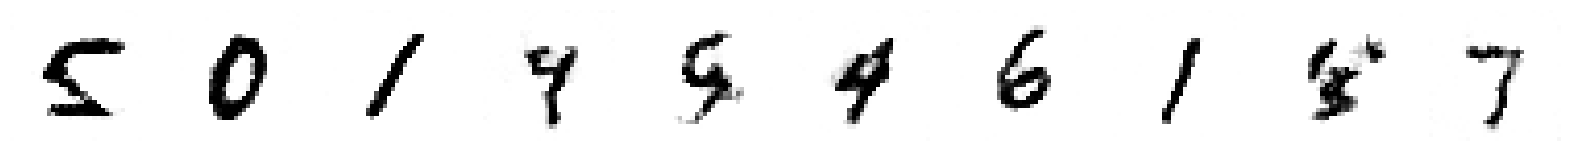

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 694ms/step - cdiv: -1.6463e-04 - fake: 3.7717e-04 - loss: 8.9680e-05 - real: 5.4180e-04 - reg: 2.5431e-04 - val_cdiv: -29.3509 - val_fake: -29.3485 - val_real: 0.0024
Epoch 82/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - cdiv: -5.2877e-04 - fake: -5.0596e-04 - loss: -2.6503e-04 - real: 2.2818e-05 - reg: 2.6374e-04

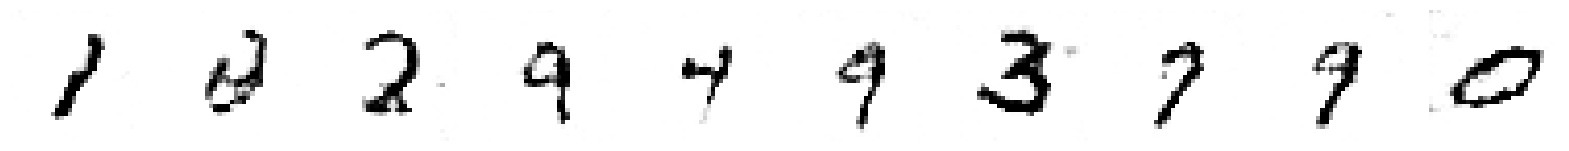

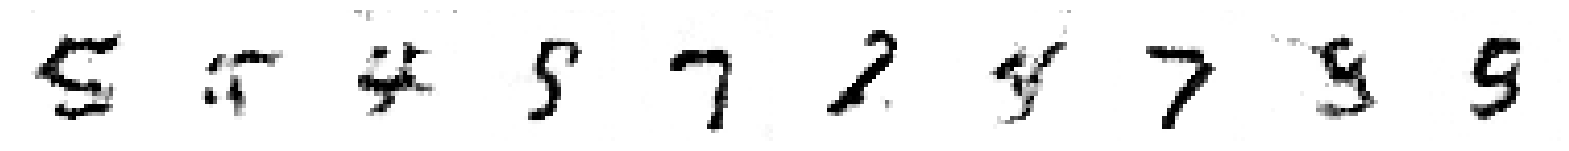

469/469 ━━━━━━━━━━━━━━━━━━━━ 328s 699ms/step - cdiv: -5.2790e-04 - fake: -5.0487e-04 - loss: -2.6423e-04 - real: 2.3032e-05 - reg: 2.6367e-04 - val_cdiv: -29.2773 - val_fake: -29.2705 - val_real: 0.0068
Epoch 83/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - cdiv: -2.0413e-04 - fake: -2.5769e-04 - loss: 1.1200e-05 - real: -5.3560e-05 - reg: 2.1533e-04

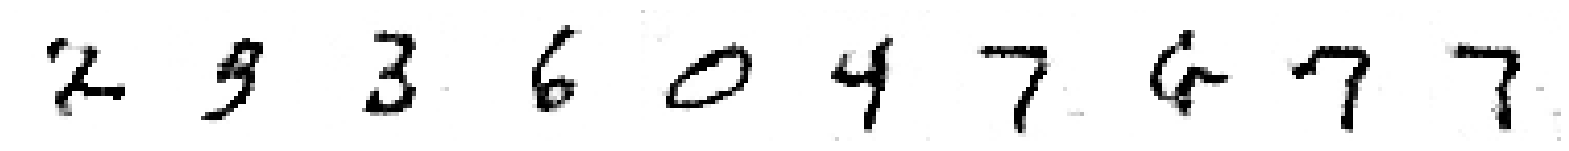

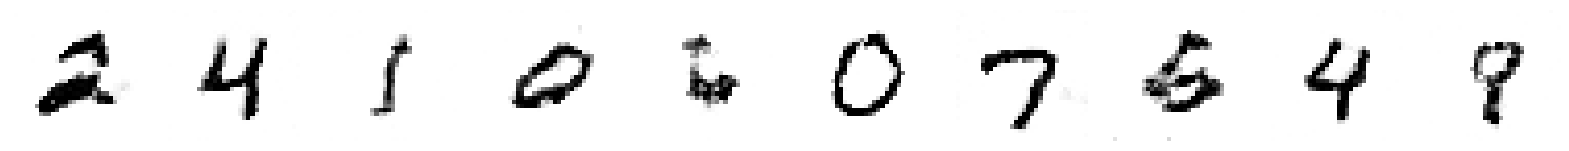

469/469 ━━━━━━━━━━━━━━━━━━━━ 327s 697ms/step - cdiv: -2.0344e-04 - fake: -2.5713e-04 - loss: 1.1808e-05 - real: -5.3689e-05 - reg: 2.1524e-04 - val_cdiv: -29.3343 - val_fake: -29.3321 - val_real: 0.0022
Epoch 84/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - cdiv: -4.4022e-04 - fake: -6.3423e-04 - loss: -2.5263e-04 - real: -1.9401e-04 - reg: 1.8759e-04

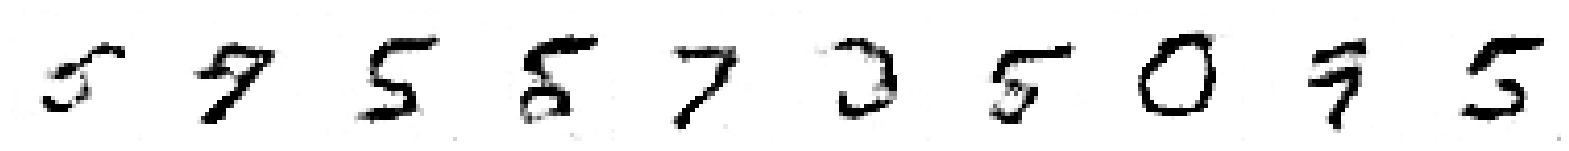

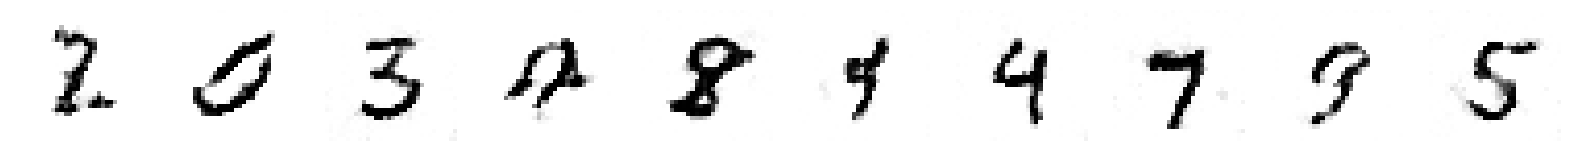

469/469 ━━━━━━━━━━━━━━━━━━━━ 328s 699ms/step - cdiv: -4.3921e-04 - fake: -6.3322e-04 - loss: -2.5167e-04 - real: -1.9401e-04 - reg: 1.8754e-04 - val_cdiv: -29.3216 - val_fake: -29.3174 - val_real: 0.0042
Epoch 85/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - cdiv: -7.4288e-04 - fake: -4.6435e-05 - loss: -5.5279e-04 - real: 6.9645e-04 - reg: 1.9009e-04

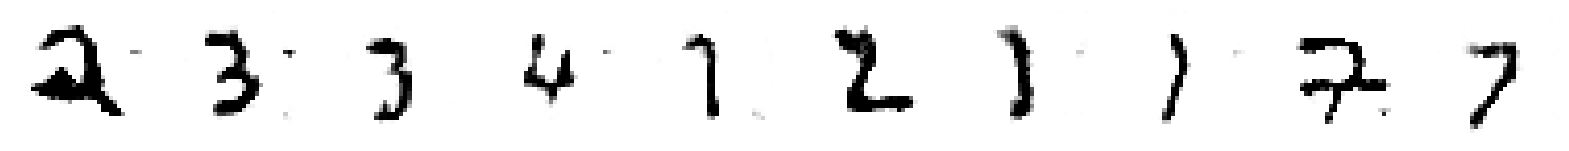

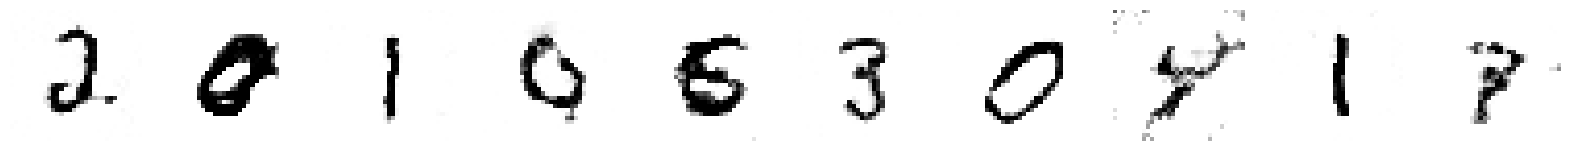

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 693ms/step - cdiv: -7.4246e-04 - fake: -4.6065e-05 - loss: -5.5230e-04 - real: 6.9640e-04 - reg: 1.9016e-04 - val_cdiv: -29.4514 - val_fake: -29.4417 - val_real: 0.0096
Epoch 86/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - cdiv: -7.3838e-04 - fake: -3.9499e-04 - loss: -4.3954e-04 - real: 3.4339e-04 - reg: 2.9884e-04

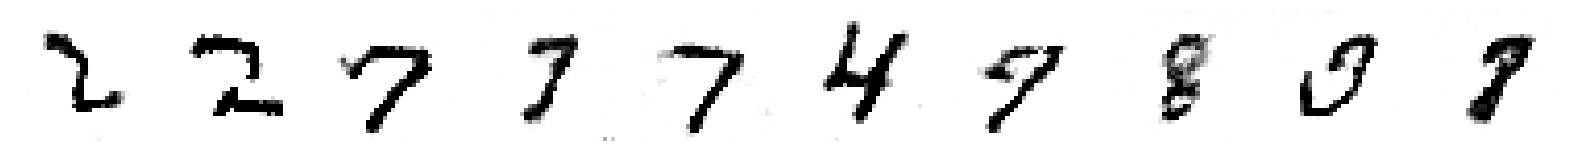

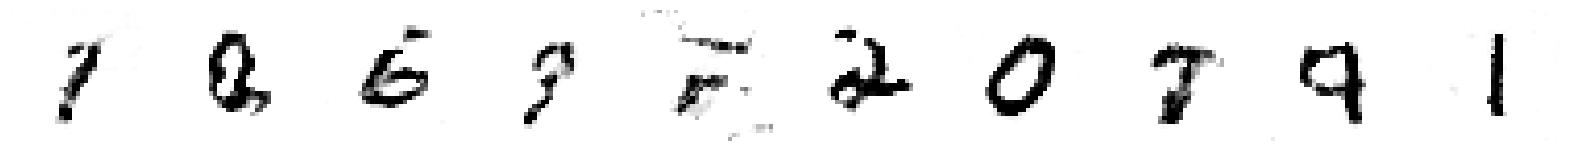

469/469 ━━━━━━━━━━━━━━━━━━━━ 322s 687ms/step - cdiv: -7.3747e-04 - fake: -3.9471e-04 - loss: -4.3872e-04 - real: 3.4276e-04 - reg: 2.9875e-04 - val_cdiv: -29.5897 - val_fake: -29.5756 - val_real: 0.0141
Epoch 87/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - cdiv: -2.7793e-04 - fake: 2.3898e-04 - loss: -2.5871e-05 - real: 5.1691e-04 - reg: 2.5205e-04

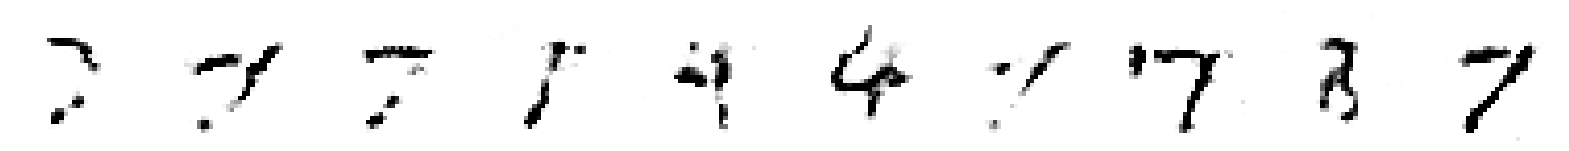

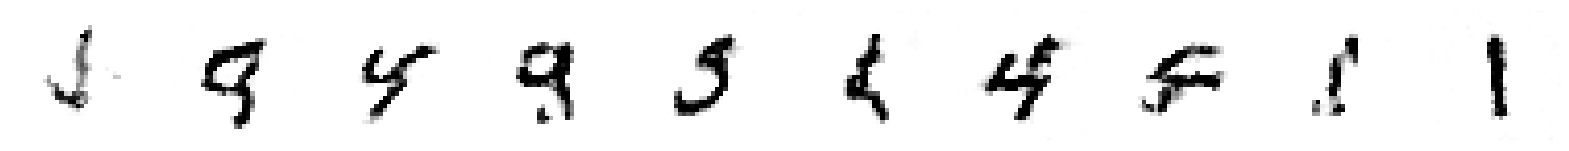

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 693ms/step - cdiv: -2.7729e-04 - fake: 2.3849e-04 - loss: -2.5317e-05 - real: 5.1578e-04 - reg: 2.5197e-04 - val_cdiv: -30.0283 - val_fake: -30.0150 - val_real: 0.0133
Epoch 88/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - cdiv: -0.0010 - fake: 3.6508e-04 - loss: -6.8663e-04 - real: 0.0014 - reg: 3.2359e-04

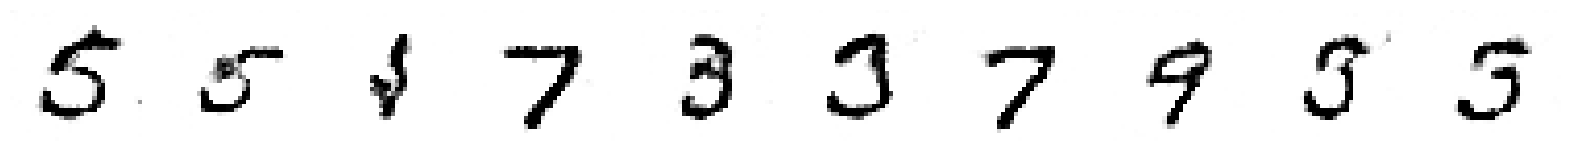

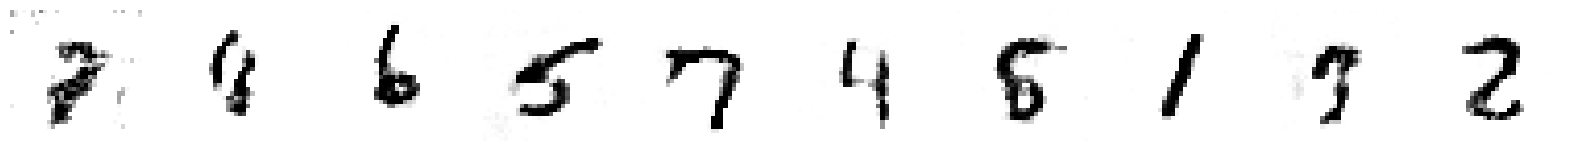

469/469 ━━━━━━━━━━━━━━━━━━━━ 321s 685ms/step - cdiv: -0.0010 - fake: 3.6383e-04 - loss: -6.8489e-04 - real: 0.0014 - reg: 3.2352e-04 - val_cdiv: -29.3974 - val_fake: -29.3970 - val_real: 4.1887e-04
Epoch 89/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - cdiv: 3.6084e-05 - fake: 4.5682e-04 - loss: 2.0926e-04 - real: 4.2073e-04 - reg: 1.7317e-04

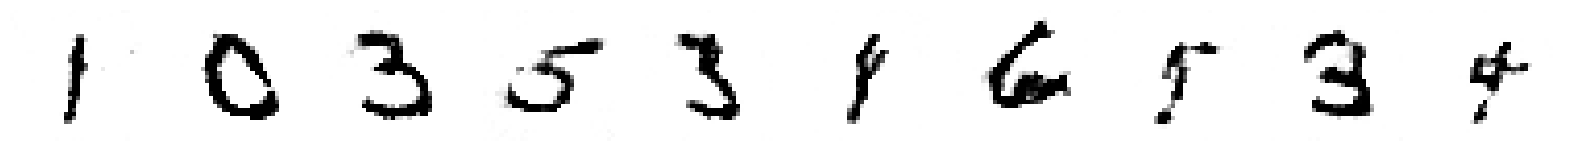

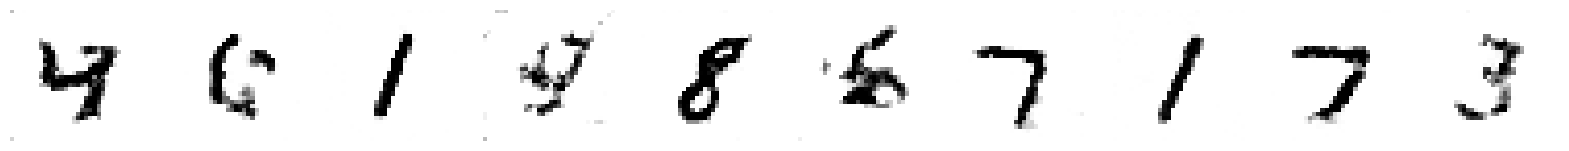

469/469 ━━━━━━━━━━━━━━━━━━━━ 323s 689ms/step - cdiv: 3.6097e-05 - fake: 4.5669e-04 - loss: 2.0931e-04 - real: 4.2059e-04 - reg: 1.7322e-04 - val_cdiv: -29.4253 - val_fake: -29.4202 - val_real: 0.0051
Epoch 90/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - cdiv: -9.8760e-04 - fake: -3.4151e-04 - loss: -7.2684e-04 - real: 6.4609e-04 - reg: 2.6075e-04

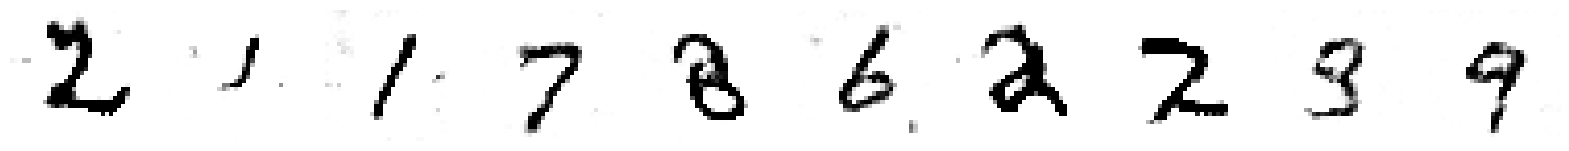

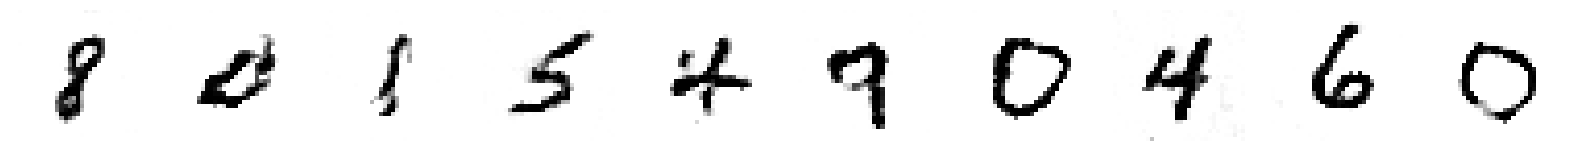

469/469 ━━━━━━━━━━━━━━━━━━━━ 321s 684ms/step - cdiv: -9.8605e-04 - fake: -3.4131e-04 - loss: -7.2535e-04 - real: 6.4475e-04 - reg: 2.6070e-04 - val_cdiv: -29.5792 - val_fake: -29.5738 - val_real: 0.0054
Epoch 91/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - cdiv: -7.2553e-04 - fake: 3.7772e-04 - loss: -4.5860e-04 - real: 0.0011 - reg: 2.6693e-04

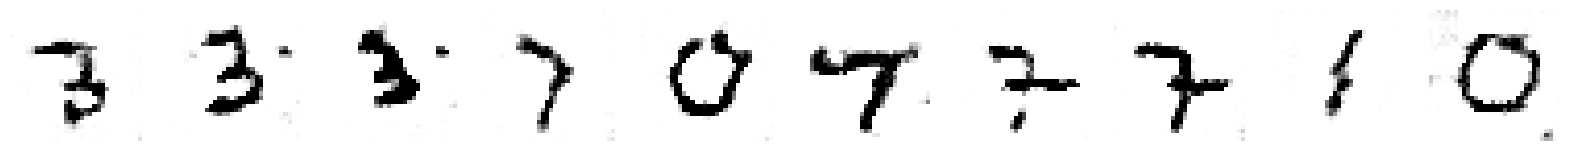

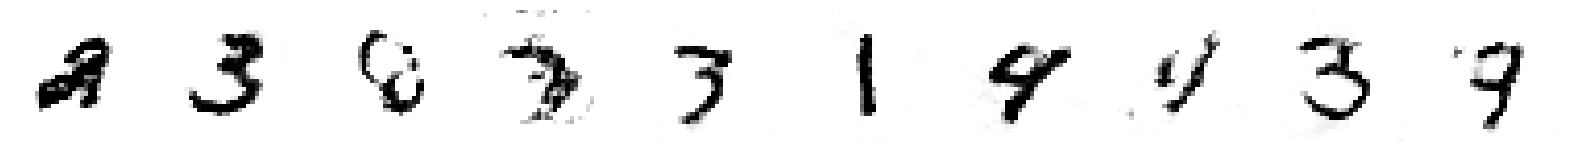

469/469 ━━━━━━━━━━━━━━━━━━━━ 319s 680ms/step - cdiv: -7.2414e-04 - fake: 3.7716e-04 - loss: -4.5726e-04 - real: 0.0011 - reg: 2.6688e-04 - val_cdiv: -29.6776 - val_fake: -29.6679 - val_real: 0.0098
Epoch 92/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - cdiv: -6.6433e-04 - fake: 1.8518e-04 - loss: -4.8333e-04 - real: 8.4952e-04 - reg: 1.8100e-04

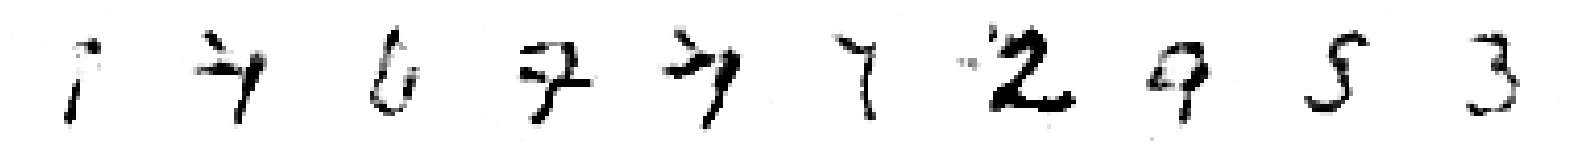

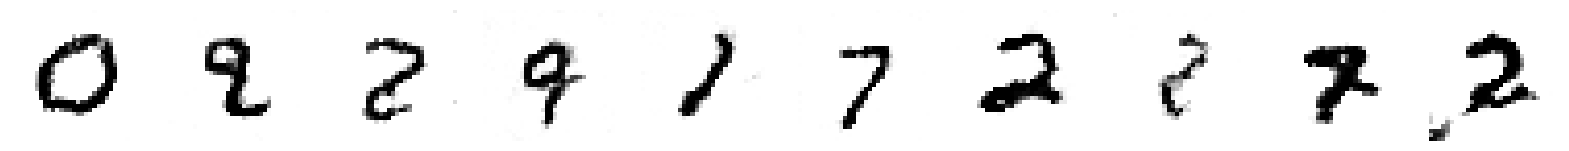

469/469 ━━━━━━━━━━━━━━━━━━━━ 324s 690ms/step - cdiv: -6.6352e-04 - fake: 1.8511e-04 - loss: -4.8248e-04 - real: 8.4863e-04 - reg: 1.8105e-04 - val_cdiv: -29.3063 - val_fake: -29.2988 - val_real: 0.0074
Epoch 93/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - cdiv: -6.8229e-04 - fake: -1.5917e-04 - loss: -4.4820e-04 - real: 5.2312e-04 - reg: 2.3408e-04

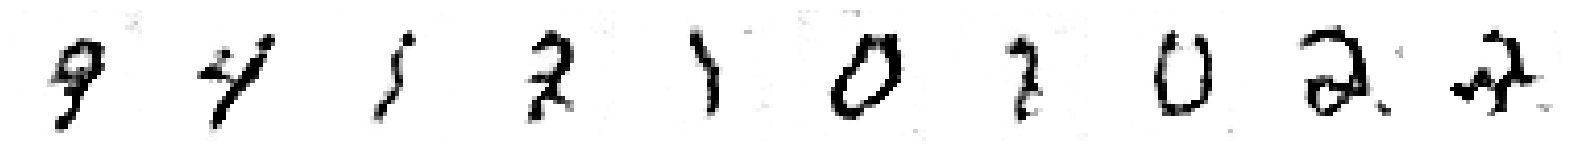

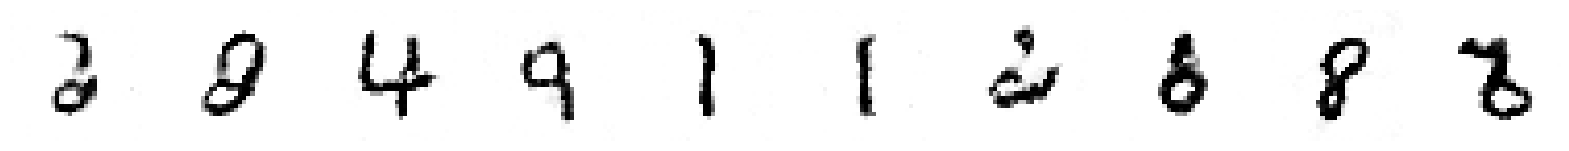

469/469 ━━━━━━━━━━━━━━━━━━━━ 318s 678ms/step - cdiv: -6.8095e-04 - fake: -1.5947e-04 - loss: -4.4690e-04 - real: 5.2148e-04 - reg: 2.3404e-04 - val_cdiv: -29.5812 - val_fake: -29.5703 - val_real: 0.0110
Epoch 94/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - cdiv: -2.5518e-04 - fake: 1.9706e-04 - loss: -9.7044e-05 - real: 4.5223e-04 - reg: 1.5813e-04

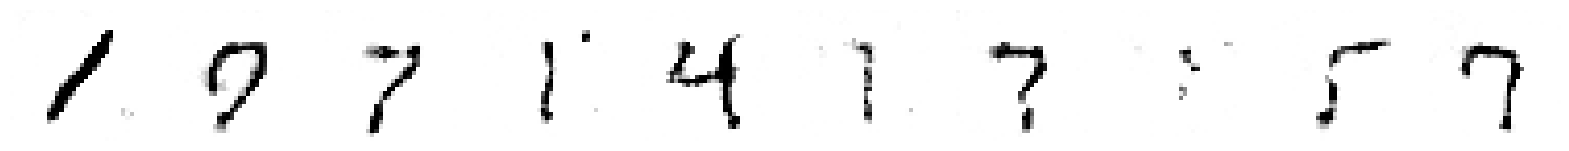

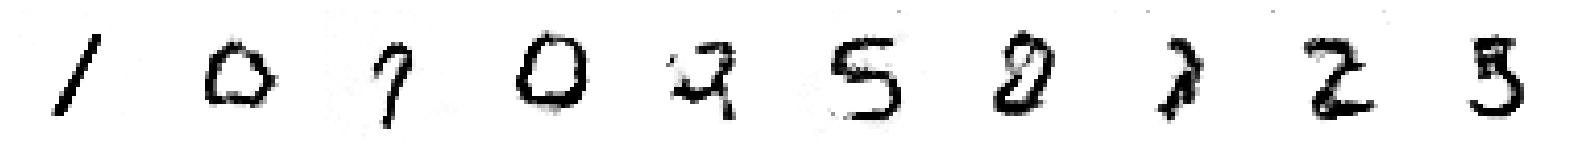

469/469 ━━━━━━━━━━━━━━━━━━━━ 322s 687ms/step - cdiv: -2.5515e-04 - fake: 1.9670e-04 - loss: -9.6996e-05 - real: 4.5185e-04 - reg: 1.5815e-04 - val_cdiv: -29.4631 - val_fake: -29.4528 - val_real: 0.0103
Epoch 95/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - cdiv: -9.7022e-04 - fake: 1.2159e-04 - loss: -6.8560e-04 - real: 0.0011 - reg: 2.8462e-04

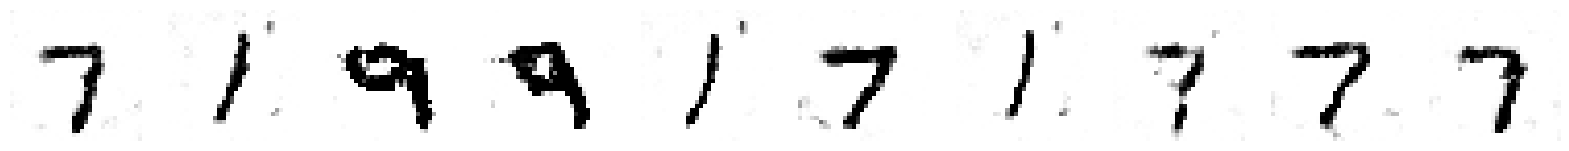

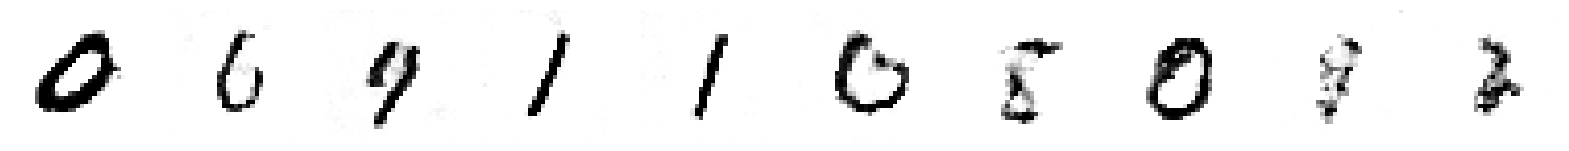

469/469 ━━━━━━━━━━━━━━━━━━━━ 324s 691ms/step - cdiv: -9.6877e-04 - fake: 1.2081e-04 - loss: -6.8420e-04 - real: 0.0011 - reg: 2.8457e-04 - val_cdiv: -29.3329 - val_fake: -29.3193 - val_real: 0.0136
Epoch 96/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - cdiv: -6.2836e-04 - fake: 8.3539e-04 - loss: -3.5326e-04 - real: 0.0015 - reg: 2.7510e-04

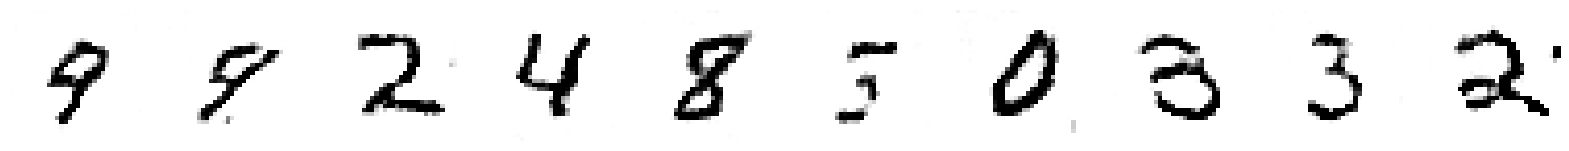

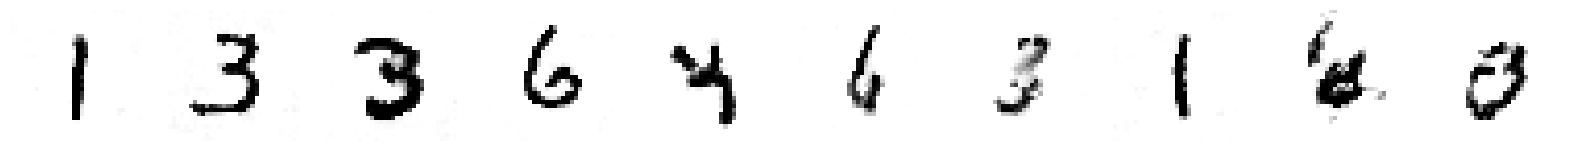

469/469 ━━━━━━━━━━━━━━━━━━━━ 324s 691ms/step - cdiv: -6.2761e-04 - fake: 8.3417e-04 - loss: -3.5247e-04 - real: 0.0015 - reg: 2.7514e-04 - val_cdiv: -29.4273 - val_fake: -29.4220 - val_real: 0.0054
Epoch 97/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - cdiv: -2.9666e-04 - fake: 3.3502e-04 - loss: -6.4791e-05 - real: 6.3168e-04 - reg: 2.3187e-04

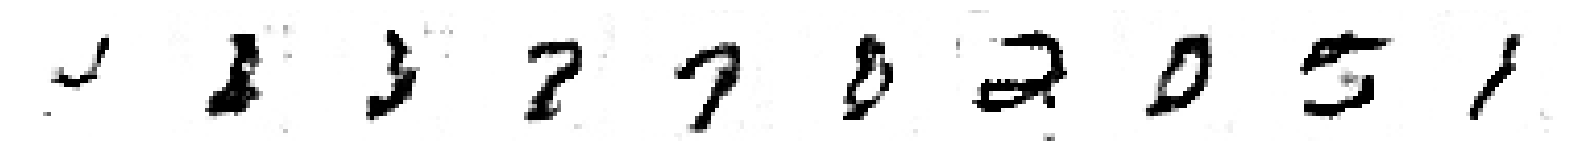

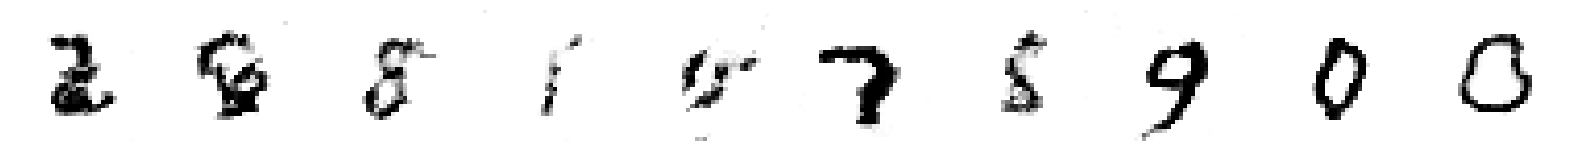

469/469 ━━━━━━━━━━━━━━━━━━━━ 324s 691ms/step - cdiv: -2.9636e-04 - fake: 3.3438e-04 - loss: -6.4472e-05 - real: 6.3074e-04 - reg: 2.3189e-04 - val_cdiv: -30.0863 - val_fake: -30.0804 - val_real: 0.0059
Epoch 98/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - cdiv: -8.5264e-04 - fake: 1.9991e-04 - loss: -5.8485e-04 - real: 0.0011 - reg: 2.6779e-04

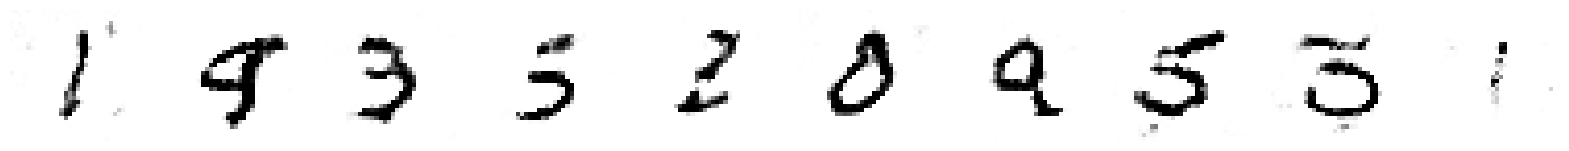

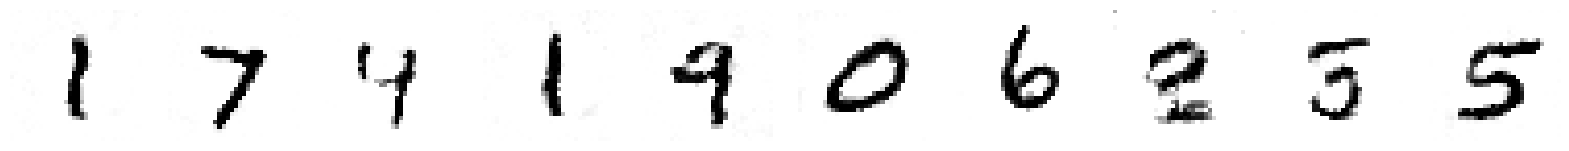

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 692ms/step - cdiv: -8.5131e-04 - fake: 1.9912e-04 - loss: -5.8356e-04 - real: 0.0011 - reg: 2.6775e-04 - val_cdiv: -29.7459 - val_fake: -29.7352 - val_real: 0.0107
Epoch 99/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - cdiv: -7.8824e-04 - fake: 3.4344e-04 - loss: -5.5529e-04 - real: 0.0011 - reg: 2.3295e-04

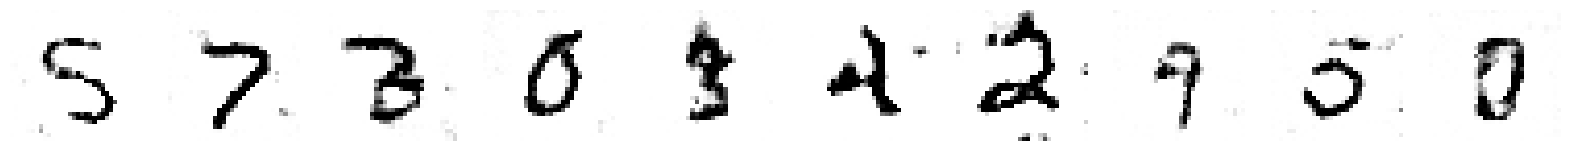

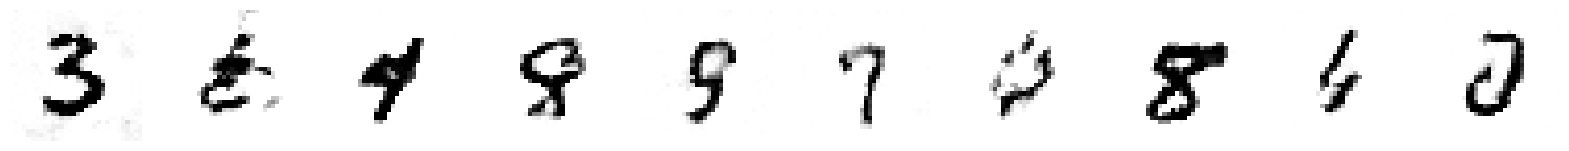

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 692ms/step - cdiv: -7.8679e-04 - fake: 3.4239e-04 - loss: -5.5385e-04 - real: 0.0011 - reg: 2.3294e-04 - val_cdiv: -29.5677 - val_fake: -29.5570 - val_real: 0.0107
Epoch 100/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - cdiv: -4.7630e-04 - fake: 5.4947e-04 - loss: -2.7072e-04 - real: 0.0010 - reg: 2.0558e-04

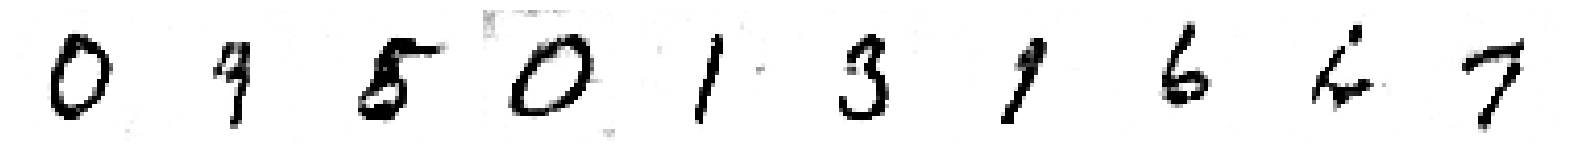

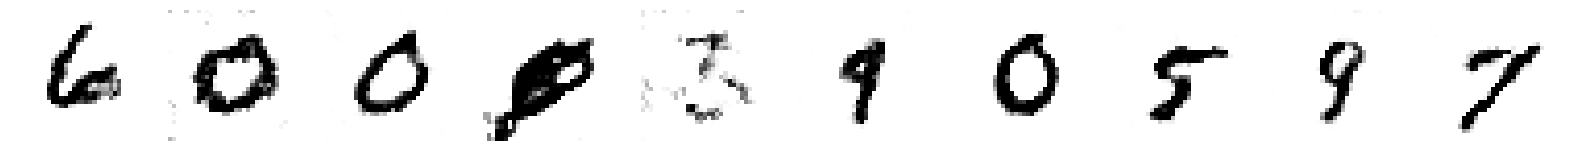

469/469 ━━━━━━━━━━━━━━━━━━━━ 322s 687ms/step - cdiv: -4.7603e-04 - fake: 5.4882e-04 - loss: -2.7035e-04 - real: 0.0010 - reg: 2.0568e-04 - val_cdiv: -29.4276 - val_fake: -29.4237 - val_real: 0.0039
Epoch 101/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - cdiv: -9.0922e-05 - fake: -9.8484e-05 - loss: 1.2078e-04 - real: -7.5618e-06 - reg: 2.1170e-04

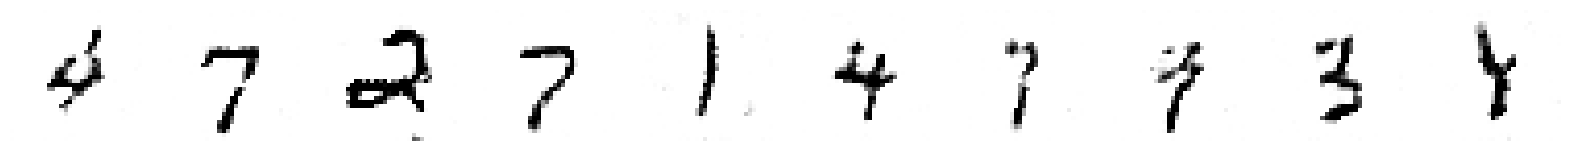

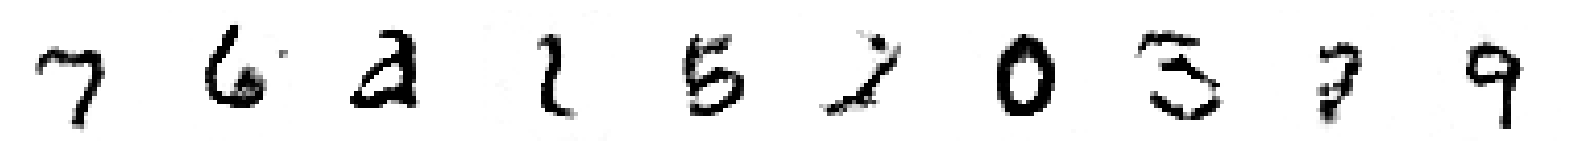

469/469 ━━━━━━━━━━━━━━━━━━━━ 324s 691ms/step - cdiv: -9.0320e-05 - fake: -9.8037e-05 - loss: 1.2133e-04 - real: -7.7167e-06 - reg: 2.1165e-04 - val_cdiv: -29.5223 - val_fake: -29.5158 - val_real: 0.0064
Epoch 102/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - cdiv: -9.1806e-04 - fake: 1.5839e-04 - loss: -6.3981e-04 - real: 0.0011 - reg: 2.7825e-04

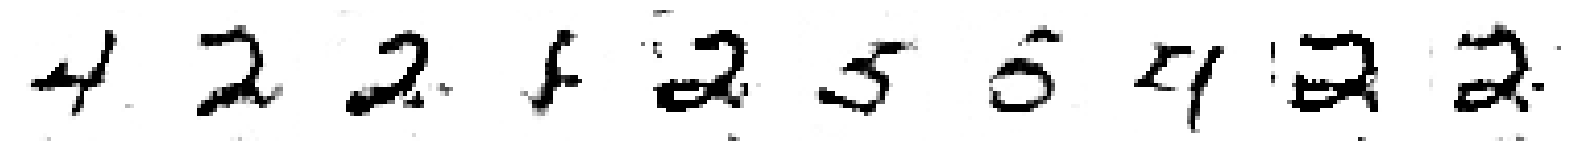

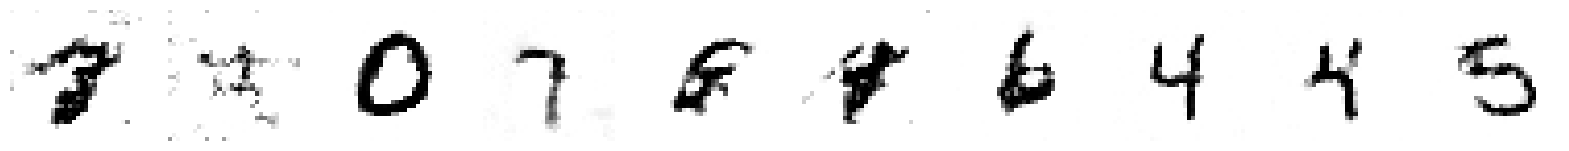

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 693ms/step - cdiv: -9.1700e-04 - fake: 1.5780e-04 - loss: -6.3870e-04 - real: 0.0011 - reg: 2.7830e-04 - val_cdiv: -29.3368 - val_fake: -29.3366 - val_real: 2.0400e-04
Epoch 103/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - cdiv: -3.5408e-04 - fake: 1.0319e-04 - loss: -6.4468e-05 - real: 4.5727e-04 - reg: 2.8961e-04

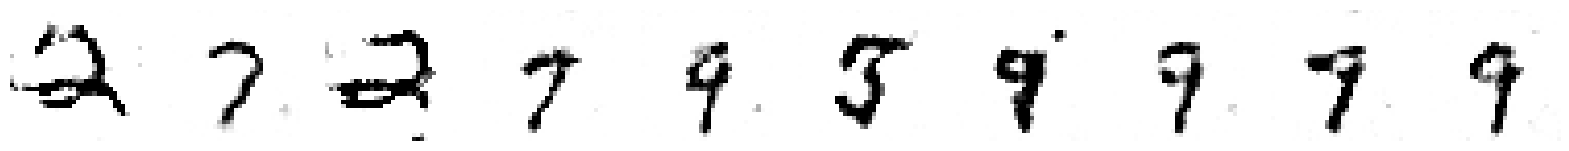

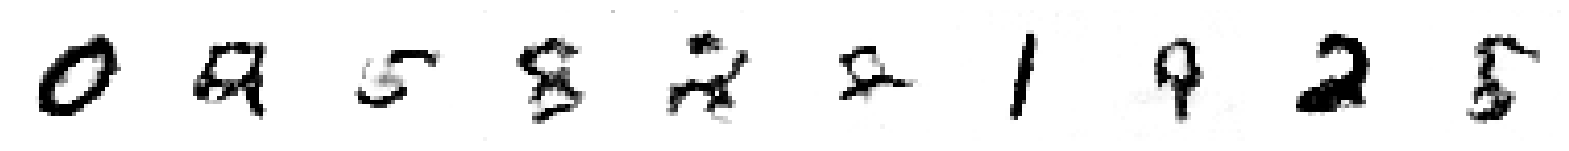

469/469 ━━━━━━━━━━━━━━━━━━━━ 326s 695ms/step - cdiv: -3.5353e-04 - fake: 1.0283e-04 - loss: -6.3937e-05 - real: 4.5636e-04 - reg: 2.8960e-04 - val_cdiv: -29.1225 - val_fake: -29.1086 - val_real: 0.0139
Epoch 104/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - cdiv: -7.8650e-04 - fake: 1.9501e-04 - loss: -4.8435e-04 - real: 9.8150e-04 - reg: 3.0215e-04

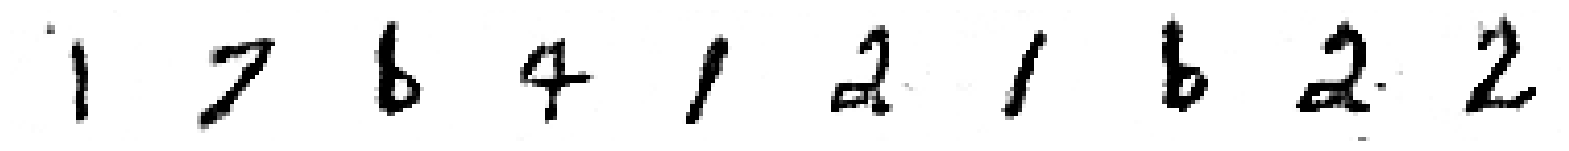

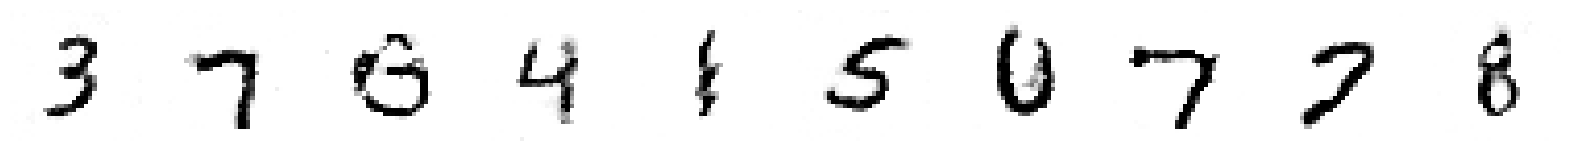

469/469 ━━━━━━━━━━━━━━━━━━━━ 327s 697ms/step - cdiv: -7.8624e-04 - fake: 1.9413e-04 - loss: -4.8406e-04 - real: 9.8037e-04 - reg: 3.0219e-04 - val_cdiv: -29.2394 - val_fake: -29.2280 - val_real: 0.0113
Epoch 105/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - cdiv: -2.9079e-04 - fake: 0.0011 - loss: 5.1118e-05 - real: 0.0014 - reg: 3.4190e-04

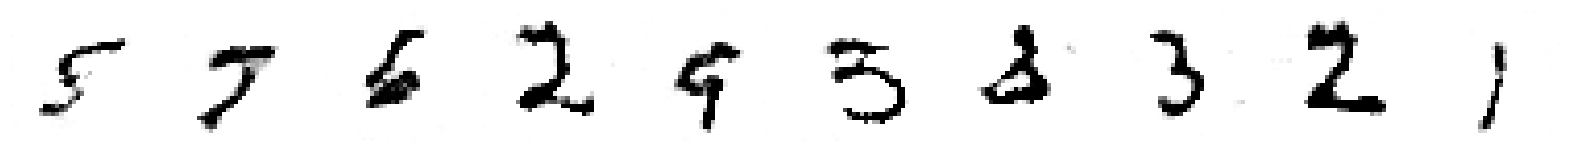

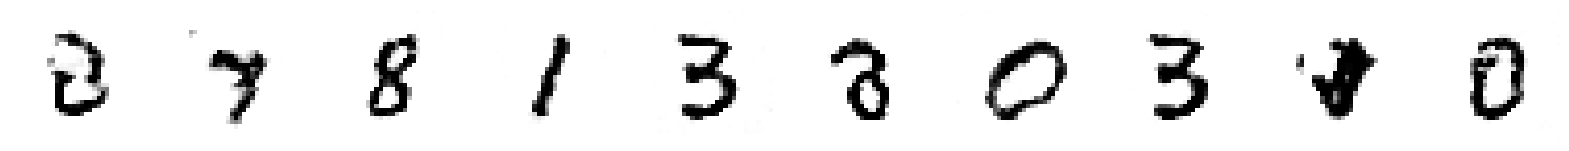

469/469 ━━━━━━━━━━━━━━━━━━━━ 322s 685ms/step - cdiv: -2.9027e-04 - fake: 0.0011 - loss: 5.1491e-05 - real: 0.0014 - reg: 3.4176e-04 - val_cdiv: -29.0224 - val_fake: -29.0124 - val_real: 0.0101
Epoch 106/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - cdiv: -9.5411e-04 - fake: 1.3868e-04 - loss: -6.3398e-04 - real: 0.0011 - reg: 3.2014e-04

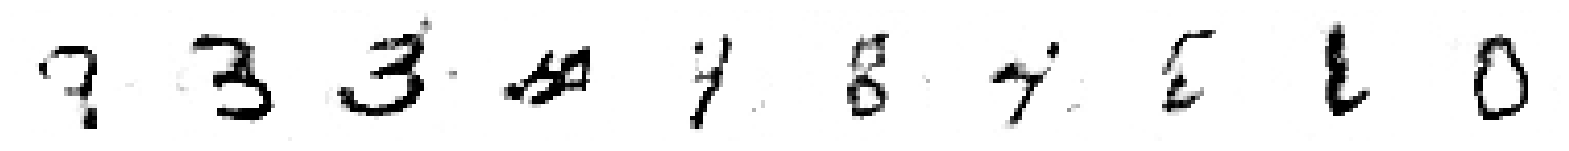

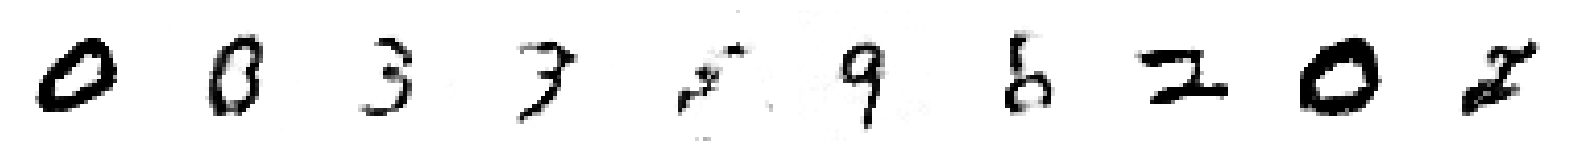

469/469 ━━━━━━━━━━━━━━━━━━━━ 321s 684ms/step - cdiv: -9.5245e-04 - fake: 1.3716e-04 - loss: -6.3237e-04 - real: 0.0011 - reg: 3.2008e-04 - val_cdiv: -29.1465 - val_fake: -29.1326 - val_real: 0.0139
Epoch 107/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - cdiv: -6.9476e-04 - fake: 0.0012 - loss: -4.1788e-04 - real: 0.0019 - reg: 2.7688e-04

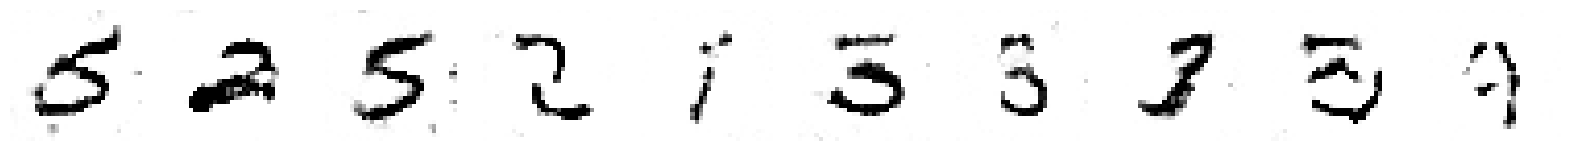

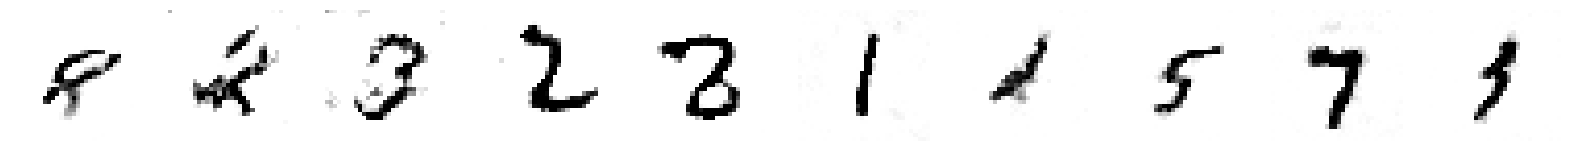

469/469 ━━━━━━━━━━━━━━━━━━━━ 324s 691ms/step - cdiv: -6.9348e-04 - fake: 0.0012 - loss: -4.1666e-04 - real: 0.0018 - reg: 2.7683e-04 - val_cdiv: -29.1934 - val_fake: -29.1846 - val_real: 0.0088
Epoch 108/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - cdiv: -3.7226e-04 - fake: 7.8429e-04 - loss: -1.9906e-04 - real: 0.0012 - reg: 1.7319e-04

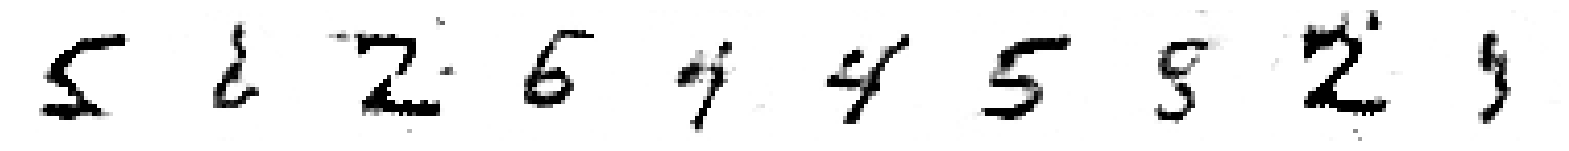

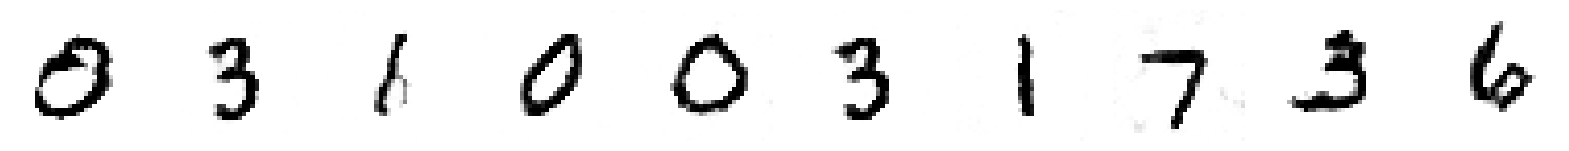

469/469 ━━━━━━━━━━━━━━━━━━━━ 323s 689ms/step - cdiv: -3.7187e-04 - fake: 7.8311e-04 - loss: -1.9861e-04 - real: 0.0012 - reg: 1.7327e-04 - val_cdiv: -28.9404 - val_fake: -28.9349 - val_real: 0.0055
Epoch 109/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - cdiv: -7.5168e-04 - fake: 2.5037e-04 - loss: -4.8898e-04 - real: 0.0010 - reg: 2.6270e-04

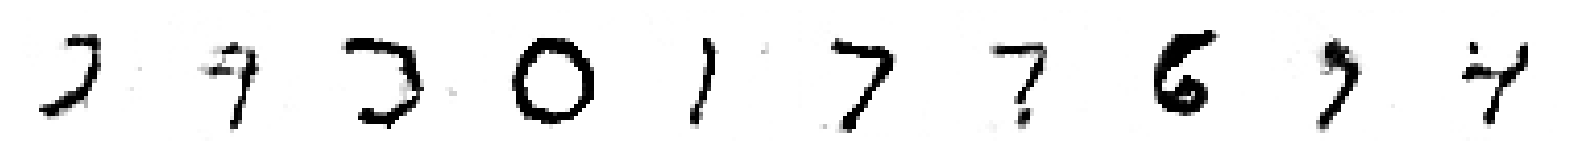

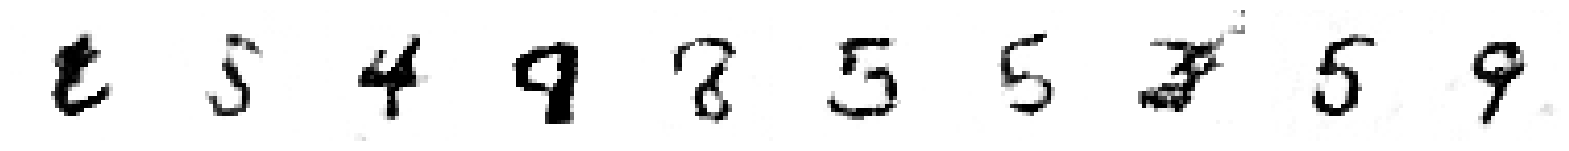

469/469 ━━━━━━━━━━━━━━━━━━━━ 321s 685ms/step - cdiv: -7.5120e-04 - fake: 2.4984e-04 - loss: -4.8847e-04 - real: 0.0010 - reg: 2.6274e-04 - val_cdiv: -28.8087 - val_fake: -28.8017 - val_real: 0.0069
Epoch 110/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - cdiv: -1.3002e-04 - fake: 2.3107e-04 - loss: 1.6536e-04 - real: 3.6109e-04 - reg: 2.9537e-04

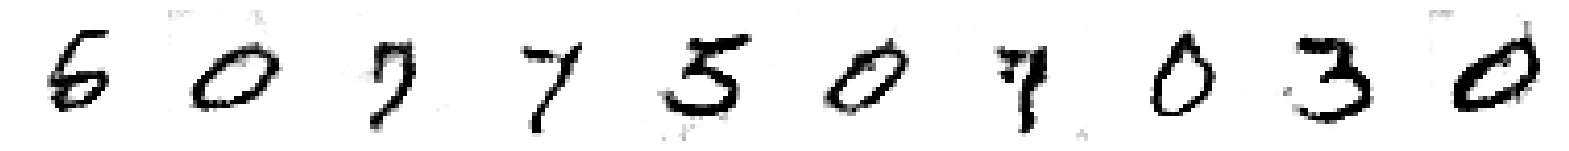

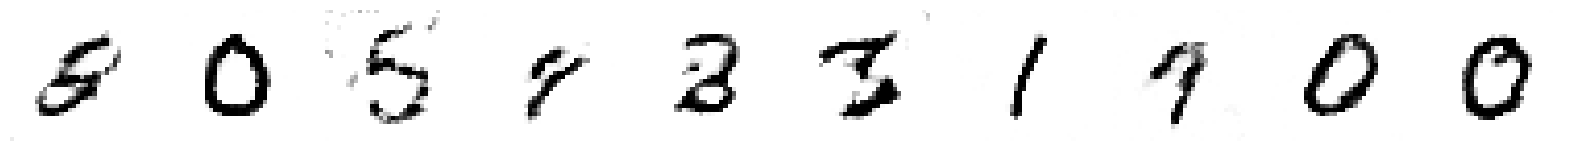

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 693ms/step - cdiv: -1.2958e-04 - fake: 2.3034e-04 - loss: 1.6567e-04 - real: 3.5992e-04 - reg: 2.9525e-04 - val_cdiv: -28.5838 - val_fake: -28.5736 - val_real: 0.0102
Epoch 111/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - cdiv: -4.7721e-04 - fake: 9.5058e-04 - loss: -2.1347e-04 - real: 0.0014 - reg: 2.6374e-04

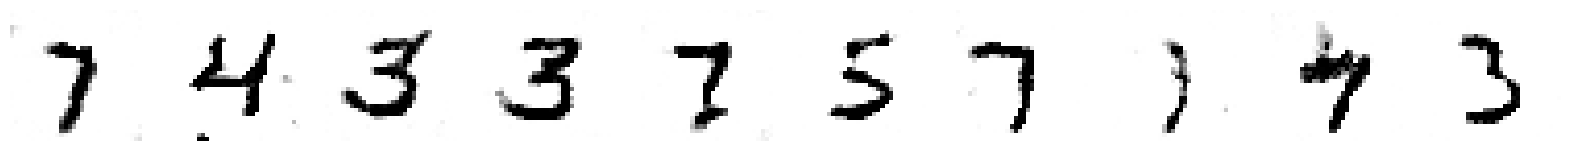

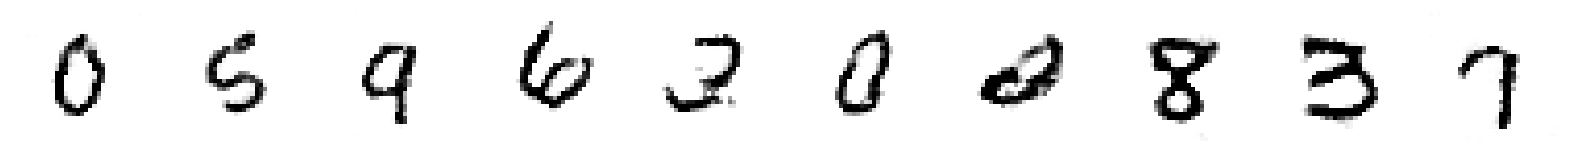

469/469 ━━━━━━━━━━━━━━━━━━━━ 323s 688ms/step - cdiv: -4.7655e-04 - fake: 9.4917e-04 - loss: -2.1285e-04 - real: 0.0014 - reg: 2.6370e-04 - val_cdiv: -28.4612 - val_fake: -28.4470 - val_real: 0.0142
Epoch 112/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - cdiv: -0.0011 - fake: 8.6795e-04 - loss: -7.3640e-04 - real: 0.0020 - reg: 3.8695e-04

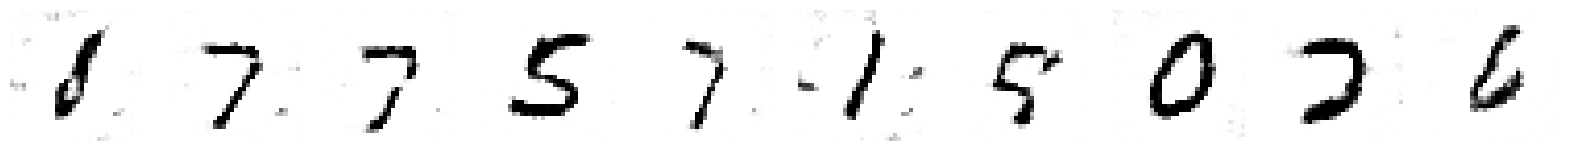

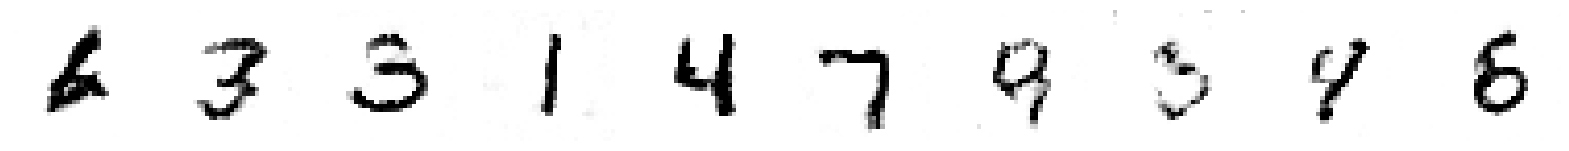

469/469 ━━━━━━━━━━━━━━━━━━━━ 328s 698ms/step - cdiv: -0.0011 - fake: 8.6572e-04 - loss: -7.3492e-04 - real: 0.0020 - reg: 3.8683e-04 - val_cdiv: -28.6944 - val_fake: -28.6854 - val_real: 0.0090
Epoch 113/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - cdiv: -9.4562e-04 - fake: -1.0588e-04 - loss: -6.2362e-04 - real: 8.3973e-04 - reg: 3.2200e-04

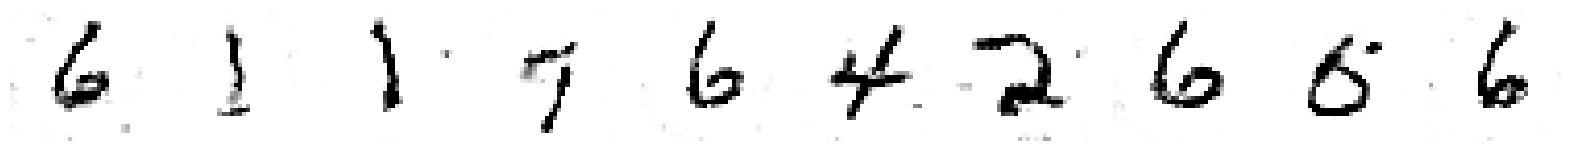

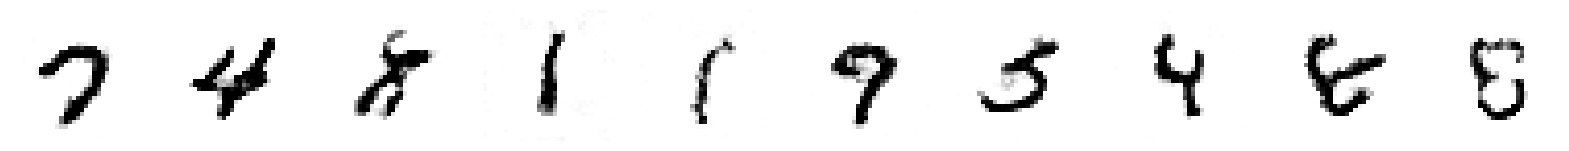

469/469 ━━━━━━━━━━━━━━━━━━━━ 324s 690ms/step - cdiv: -9.4380e-04 - fake: -1.0593e-04 - loss: -6.2191e-04 - real: 8.3787e-04 - reg: 3.2189e-04 - val_cdiv: -28.5380 - val_fake: -28.5299 - val_real: 0.0081
Epoch 114/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - cdiv: -2.5033e-04 - fake: 6.1130e-04 - loss: -3.6786e-05 - real: 8.6163e-04 - reg: 2.1355e-04

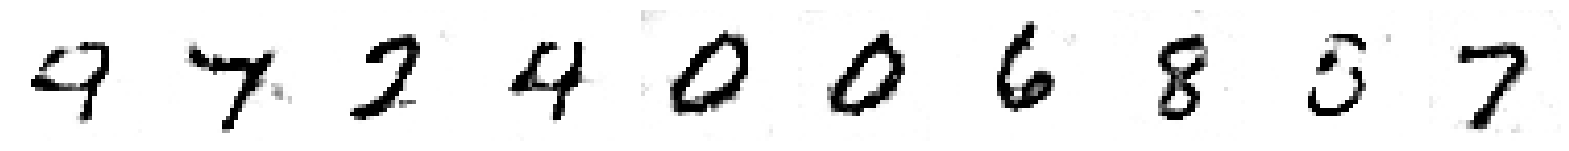

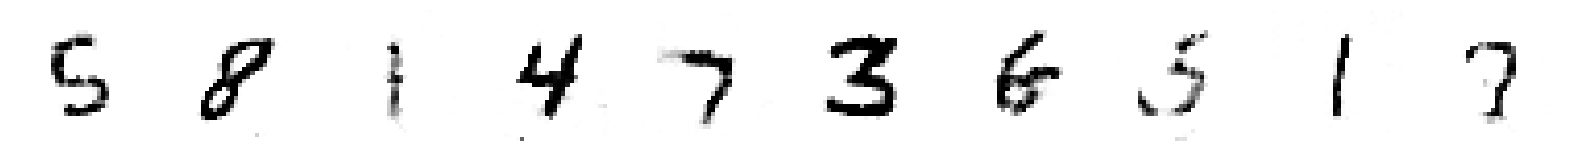

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 693ms/step - cdiv: -2.4976e-04 - fake: 6.1024e-04 - loss: -3.6226e-05 - real: 8.6000e-04 - reg: 2.1353e-04 - val_cdiv: -28.3761 - val_fake: -28.3706 - val_real: 0.0054
Epoch 115/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - cdiv: -0.0013 - fake: 5.9095e-04 - loss: -9.7224e-04 - real: 0.0019 - reg: 2.8891e-04

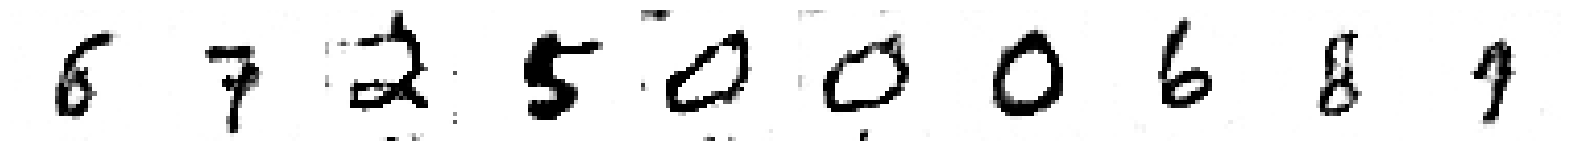

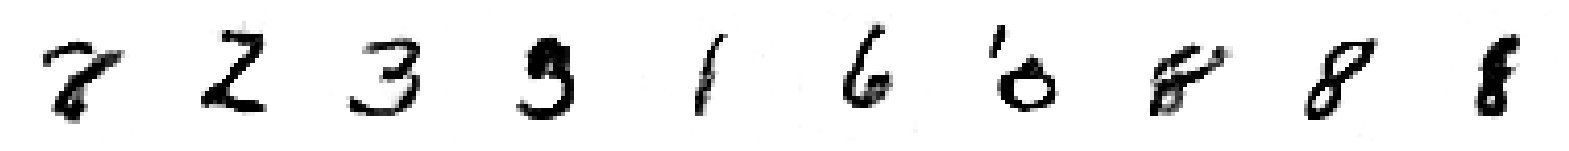

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 692ms/step - cdiv: -0.0013 - fake: 5.8963e-04 - loss: -9.7086e-04 - real: 0.0018 - reg: 2.8888e-04 - val_cdiv: -28.5304 - val_fake: -28.5186 - val_real: 0.0118
Epoch 116/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - cdiv: -7.4900e-04 - fake: 0.0014 - loss: -4.2619e-04 - real: 0.0021 - reg: 3.2281e-04

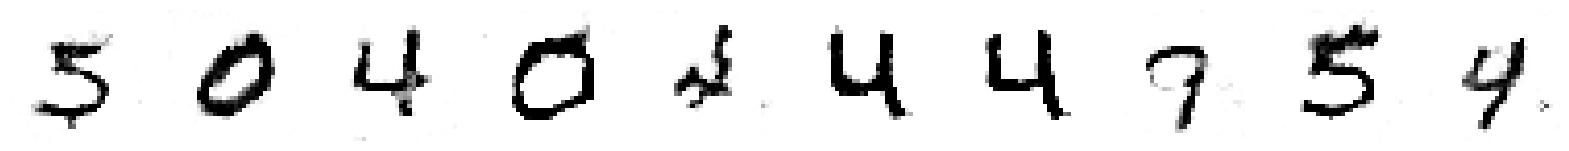

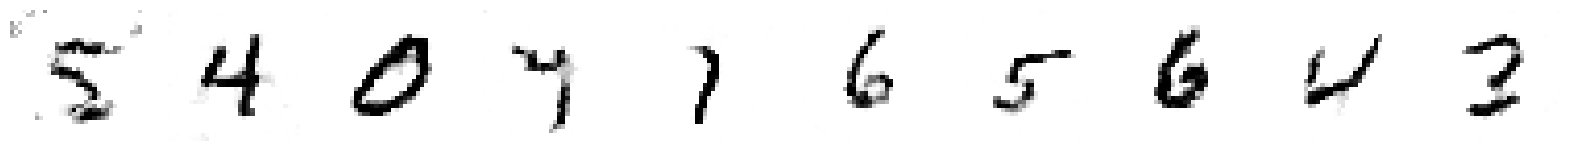

469/469 ━━━━━━━━━━━━━━━━━━━━ 329s 701ms/step - cdiv: -7.4782e-04 - fake: 0.0014 - loss: -4.2507e-04 - real: 0.0021 - reg: 3.2275e-04 - val_cdiv: -28.8169 - val_fake: -28.8099 - val_real: 0.0070
Epoch 117/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - cdiv: -7.3625e-04 - fake: 4.3322e-04 - loss: -4.6936e-04 - real: 0.0012 - reg: 2.6690e-04

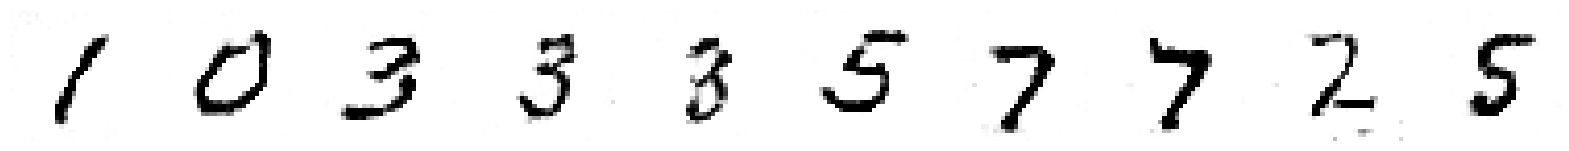

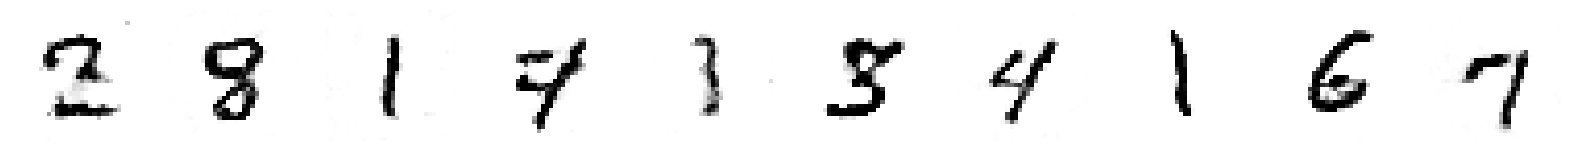

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 693ms/step - cdiv: -7.3584e-04 - fake: 4.3168e-04 - loss: -4.6892e-04 - real: 0.0012 - reg: 2.6692e-04 - val_cdiv: -28.7231 - val_fake: -28.7144 - val_real: 0.0086
Epoch 118/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - cdiv: -6.1795e-04 - fake: 7.6003e-04 - loss: -2.9132e-04 - real: 0.0014 - reg: 3.2663e-04

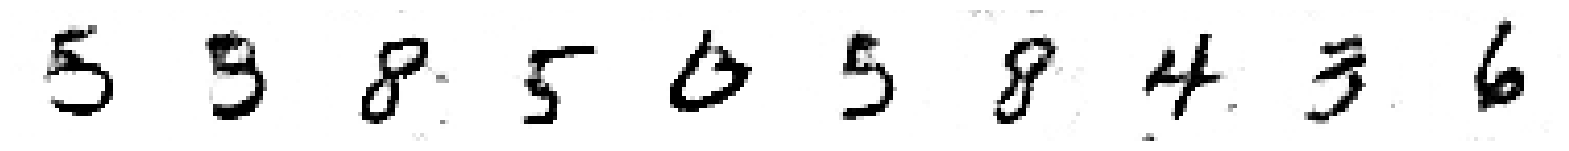

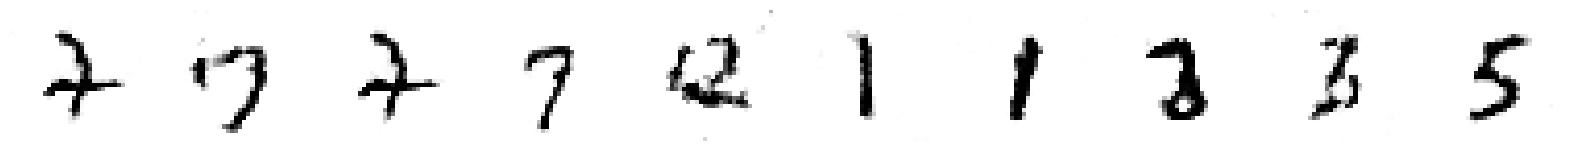

469/469 ━━━━━━━━━━━━━━━━━━━━ 328s 700ms/step - cdiv: -6.1624e-04 - fake: 7.5856e-04 - loss: -2.8970e-04 - real: 0.0014 - reg: 3.2654e-04 - val_cdiv: -28.2363 - val_fake: -28.2256 - val_real: 0.0107
Epoch 119/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - cdiv: -8.2121e-04 - fake: 0.0016 - loss: -5.3158e-04 - real: 0.0024 - reg: 2.8963e-04

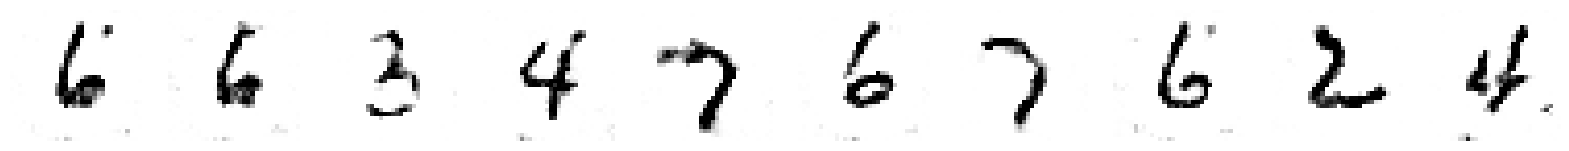

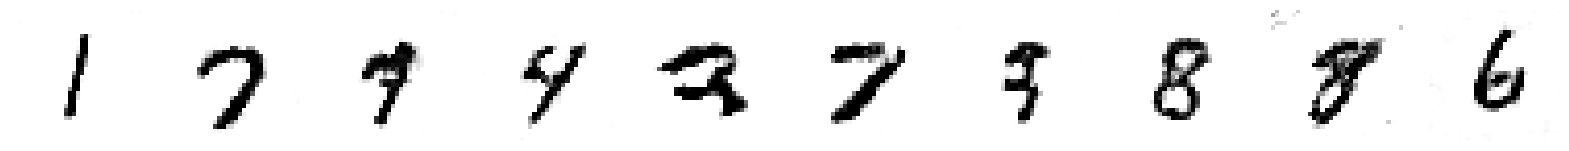

469/469 ━━━━━━━━━━━━━━━━━━━━ 328s 698ms/step - cdiv: -8.2011e-04 - fake: 0.0016 - loss: -5.3044e-04 - real: 0.0024 - reg: 2.8967e-04 - val_cdiv: -28.0944 - val_fake: -28.0865 - val_real: 0.0079
Epoch 120/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - cdiv: -5.0061e-04 - fake: 3.4593e-04 - loss: -1.9714e-04 - real: 8.4654e-04 - reg: 3.0347e-04

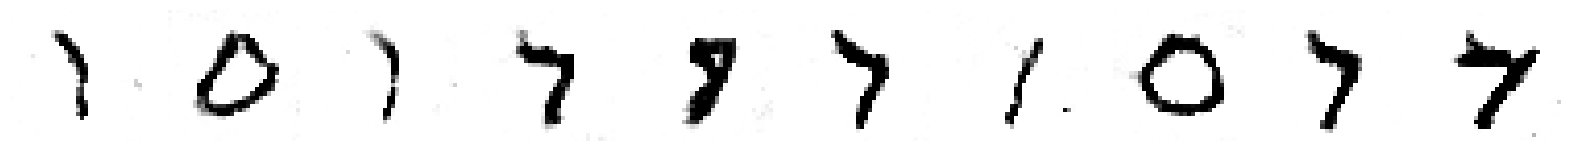

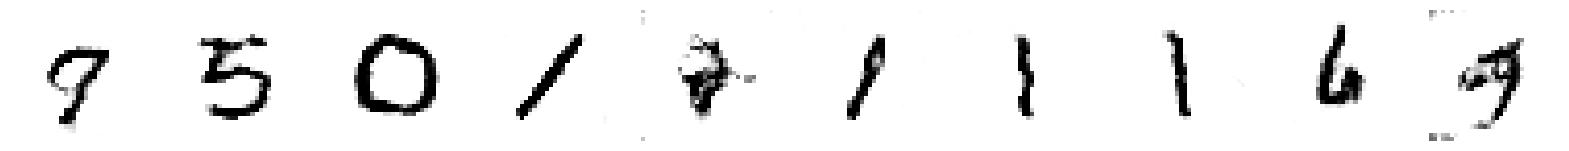

469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 693ms/step - cdiv: -4.9947e-04 - fake: 3.4516e-04 - loss: -1.9611e-04 - real: 8.4463e-04 - reg: 3.0336e-04 - val_cdiv: -27.9196 - val_fake: -27.9062 - val_real: 0.0135


In [ ]:
ebm.fit(
    x_train,
    shuffle=True,
    epochs=EPOCHS,
    validation_data=x_test,
    callbacks=[
        save_model_callback,
        tensorboard_callback,
        image_generator_callback,
    ],
)

In [ ]:
loss = ebm.history.history['loss']

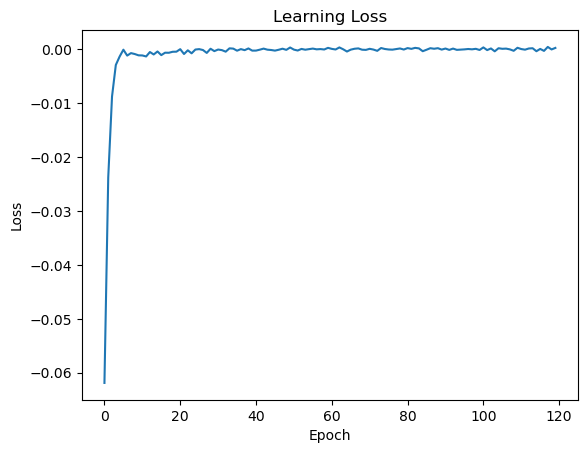

In [ ]:
plt.plot(loss)
plt.title('Learning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
print(ebm.history.history.keys())

dict_keys(['cdiv', 'fake', 'loss', 'real', 'reg', 'val_cdiv', 'val_fake', 'val_real'])


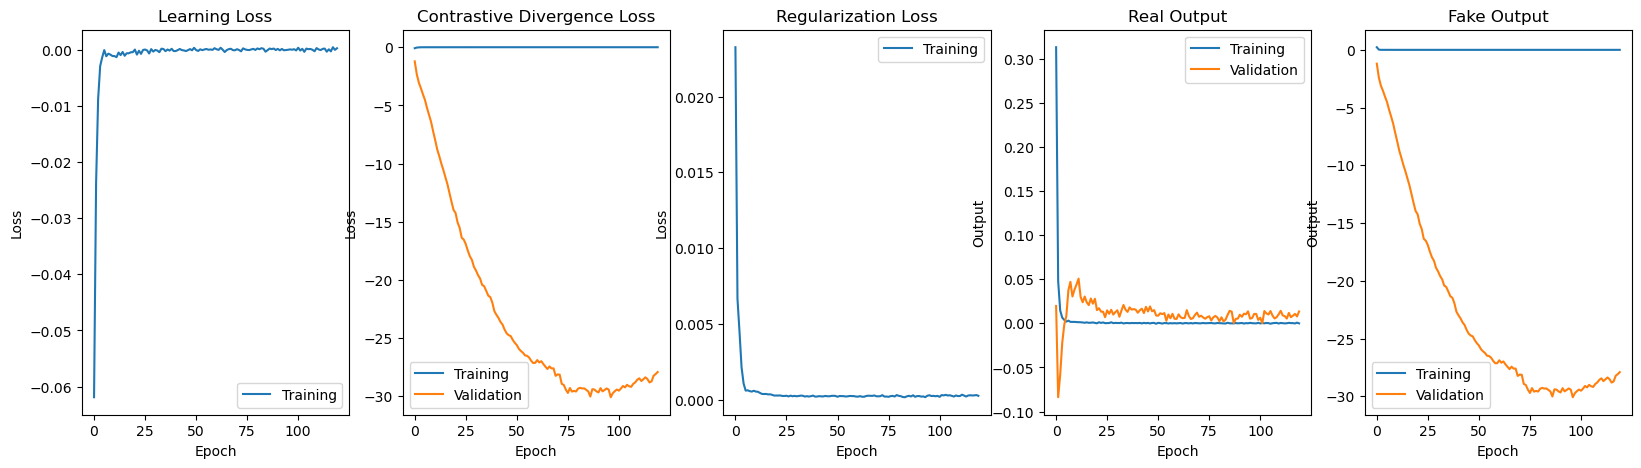

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

axs[0].plot(ebm.history.history['loss'], label='Training')
axs[0].set_title('Learning Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(ebm.history.history['cdiv'], label='Training')
axs[1].plot(ebm.history.history['val_cdiv'], label='Validation')
axs[1].set_title('Contrastive Divergence Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

axs[2].plot(ebm.history.history['reg'], label='Training')
axs[2].set_title('Regularization Loss')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()

axs[3].plot(ebm.history.history['real'], label='Training')
axs[3].plot(ebm.history.history['val_real'], label='Validation')
axs[3].set_title('Real Output')
axs[3].set_xlabel('Epoch')
axs[3].set_ylabel('Output')
axs[3].legend()

axs[4].plot(ebm.history.history['fake'], label='Training')
axs[4].plot(ebm.history.history['val_fake'], label='Validation')
axs[4].set_title('Fake Output')
axs[4].set_xlabel('Epoch')
axs[4].set_ylabel('Output')
axs[4].legend()

plt.show()

## Generate images

In [ ]:
start_imgs = (
    np.random.uniform(size=(10, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
)

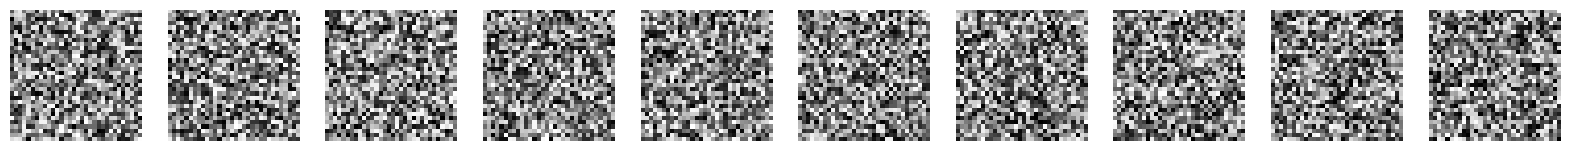

In [ ]:
display(start_imgs)

In [ ]:
gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps=1000,
    step_size=STEP_SIZE,
    noise=NOISE,
    return_img_per_step=True,
)

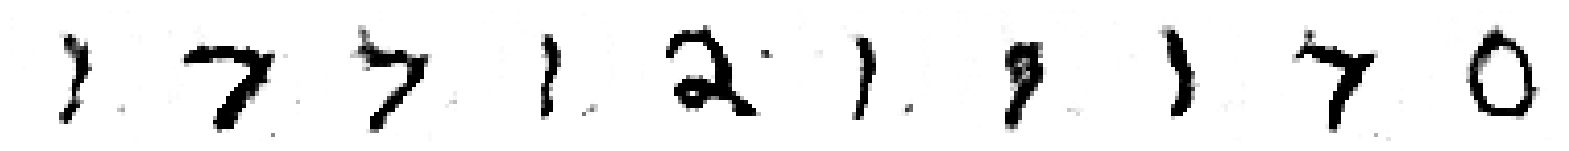

In [ ]:
display(gen_img[-1].numpy())

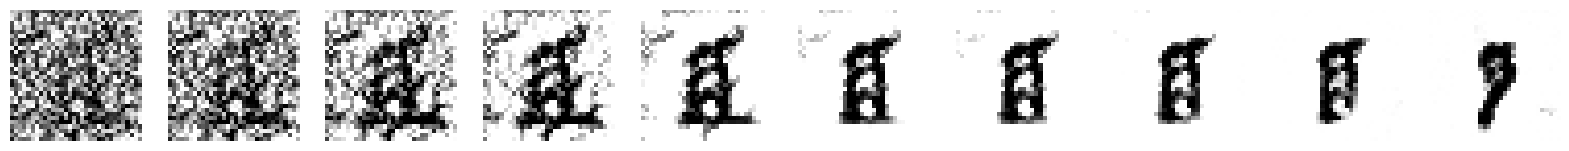

In [ ]:
imgs = []
for i in [0, 1, 3, 5, 10, 30, 50, 100, 300, 999]:
    imgs.append(gen_img[i].numpy()[6])

display(np.array(imgs))